# Setup Basic Tools
## Import Modules

In [2]:
import os
import sys
import csv, json
import math, random, ast, swifter
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import portion as P
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pprint import pprint
from collections import namedtuple

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

## Function: unify data format

In [3]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df



## Function: parse handover event
### Stage 1: rrc to handover dictionary

- Sheng-Ru latest version (2023-09-25)
    - 2023-10-27: add try ... except ... statement
    - 2023-11-13: add NR ARFCN

In [4]:
triggered_events = {
    'HO':     ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', ],
    'RLF':    ['MCGF', 'NASR', 'SCGF', ],
    'Others': ['CXNS', 'CXNR', 'SCLA', ],
}

rlf_events = {
    'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)', ],
    'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)', ],
}

In [5]:
def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    nr_arfcn = 0
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

### Stage 2: parse into readable dataframe
- 2023-11-21: add BSID

In [6]:
def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)
    
    if table.empty:
        selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Handover Not Found!!!')
        return table, new_D
    
    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    # table[['eNB_ID', 'next_eNB_ID',]] = table[['eNB_ID', 'next_eNB_ID']].astype('Int64')
    table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']] = \
        table[['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'TAC', 'MCC', 'MNC']].astype('Int64')
    
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1[col].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2[col].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

## Function: Profiling
- Category: HO, RLF
- Type: LTEH, ENBH, ..., MCGF, NASR, ...
- Cause: handoverFailure (1), otherFailure (2), ...

### Tools: interval operations

In [7]:
def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def interp(x, y, ratio):
    """
    Interpolation (線性內插法)

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

### Stage 1: setup an instance of profiles

In [8]:
def setup_profile_instance(df, tag, start, end, mode='dl', mets='lost', left=pd.Timestamp.min, right=pd.Timestamp.max, fix=False, scope=(-3, 3)):
    
    if pd.notna(end):
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    else:
        if fix:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[0]), left), min(start+pd.Timedelta(seconds=scope[1]), right))
        else:
            intv = P.closed(max(start+pd.Timedelta(seconds=scope[tag][0]), left), min(start+pd.Timedelta(seconds=scope[tag][1]), right))
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - start).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - start).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - start).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    
    if mets == 'lost':
        # calculate PLR
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
        table['PLR'] = table['PLR'] * 100
    elif mets == 'excl':
        # calculate ELR
        df_plot['excl_new'] = df_plot['excl'] & ~df_plot['lost']
        ts_group = df_plot.groupby(['cat_id'])
        table = ts_group['excl_new'].agg(['count','sum','mean']).copy().reset_index()
        table = table.rename(columns={'count':'tx_count', 'sum':'excl', 'mean':'ELR'})
        table['ELR'] = table['ELR'] * 100
    else:
        print(f'No metrics: {mets}!!')
        raise
    
    return table, intv

### Stage 2: setup profiles with one-trip data

In [9]:
def setup_profile(df, df_ho, mode='dl', mets='lost', sp_col=None, scope=None):
    # Initialize
    A = {tag: {'tables': [], 'intrs': []} for tag in scope.keys()}
    stable_intv = P.open(pd.Timestamp.min, pd.Timestamp.max)
    stable_pkt = 0
    stable_miss = 0
    stable_miss_rate = 0

    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row[sp_col]  # specific column name
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        
        # Set left/right bounds to avoid event overlapping with each other
        if prior_row is not None:
            if pd.notna(prior_row['end']):
                left = prior_row['end'] + (start - prior_row['end']) / 2
            else:
                left = prior_row['start'] + (start - prior_row['start']) / 2
        else:
            left = pd.Timestamp.min
        if post_row is not None:
            if pd.notna(end):
                right = end + (post_row['start'] - end) / 2
            else:
                right = start + (post_row['start'] - start) / 2
        else:
            right = pd.Timestamp.max
        
        # Setup a profile instance
        table, intv = setup_profile_instance(df, tag=tag, start=start, end=end, mode=mode, mets=mets, left=left, right=right, scope=scope)
        
        A[tag]['tables'].append(table)  # profile table instance
        A[tag]['intrs'].append(intr)  # handover interruption time
        
        # Update stable interval
        stable_intv = stable_intv - intv

    # Count lost and transferred packets under stable state
    for intv in stable_intv:
        lower = intv.lower; upper = intv.upper
        if mode == 'dl':
            df_tmp = df[(df['arr_time'] > lower) & (df['arr_time'] <= upper)].copy().reset_index(drop=True)
        elif mode == 'ul':
            df_tmp = df[(df['xmit_time'] > lower) & (df['xmit_time'] <= upper)].copy().reset_index(drop=True)
        else:
            print(f'No mode: {mode}!!')
            raise
        
        stable_pkt += len(df_tmp)
        if mets == 'lost':
            stable_miss += sum(df_tmp['lost'])
        elif mets == 'excl':
            stable_miss += sum(df_tmp['excl'] & ~df_tmp['lost'])
    
    stable_miss_rate = round(stable_miss / (stable_pkt + 1e-9) * 100, 3)
    
    # Calculate stable duration, proportion
    stable_duration = 0
    stable_intv = stable_intv & P.closed(df.iloc[0]['xmit_time'], df.iloc[-1]['xmit_time'])
    for intv in stable_intv:
        stable_duration += (intv.upper - intv.lower).total_seconds()
        
    total_duration = (df.iloc[-1]['xmit_time'] - df.iloc[0]['xmit_time']).total_seconds()
    stable_proportion = round(stable_duration / (total_duration + 1e-9) * 100, 3)
    
    return A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion

### Stage 3: merge profiles from all datasets

In [10]:
def merge_profile(tables, intrs, mets='lost'):
    
    intr = np.mean(intrs)
    if mets == 'lost':
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
    elif mets == 'excl':
        table = pd.DataFrame(columns=['cat_id','tx_count','excl','ELR'])
        table['excl'] = table['excl'].astype('Int32')
        table['ELR'] = table['ELR'].astype('float32')
    
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        
        if mets == 'lost':
            table['lost'] = table['lost_x'] + table['lost_y']
            table['PLR'] = 0
            table = table[['cat_id','tx_count','lost','PLR']]
        elif mets == 'excl':
            table['excl'] = table['excl_x'] + table['excl_y']
            table['ELR'] = 0
            table = table[['cat_id','tx_count','excl','ELR']]
    
    if mets == 'lost':    
        table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    elif mets == 'excl':
        table['ELR'] = table['excl'] / (table['tx_count'] + 1e-9) * 100
        table = table[['cat_id','tx_count','excl','ELR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    
    return table, intr

### Stage 4: approximate the scopes of events

In [11]:
def approx_scope(table, mets='lost', evt_type='RLF', stable_miss_rate=0):
    table['new'] = (table[mets] - table['tx_count'] * stable_miss_rate / 1e3).round()
    table_tmp = table[table['new'] > 0]
    
    if len(table_tmp) == 0:
        return 0
    
    lower = min(math.floor(table.iloc[0]['cat_id'] * 10), -1)
    upper = max(math.ceil(table.iloc[-1]['cat_id'] * 10), 1)

    # total = sum(table_tmp[mets])
    total = sum(table_tmp['new'])
    if evt_type == 'RLF':
        thr = round(total * 0.9973)
    elif evt_type == 'HO':
        # thr = round(total * 0.9876)
        thr = round(total * 0.9545)
        # thr = round(total * 0.8664)
        # thr = round(total * 0.6827)
    else:
        print(f'No category: {evt_type}!!')
        raise

    scope_candidate = []
    scope_duration = []
    for i in range(lower, 0):
        for j in range(1, upper+1):
            k = i/10; l = j/10
            _table_tmp = table_tmp[(table_tmp['cat_id'] >= k) & (table_tmp['cat_id'] < l)]
            # miss = sum(_table_tmp[mets])
            miss = sum(_table_tmp['new'])
            # print(miss, thr)
            if miss >= thr:
                scope_candidate.append((k, l))
                scope_duration.append(l-k)
    
    if len(scope_duration) == 0:
        return 0
    
    min_value = min(scope_duration)
    min_scope = [scp for scp, value in zip(scope_candidate, scope_duration) if value == min_value]
    print(min_scope)

    return min_scope[0]

## Function: Evaluation

In [12]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(coef_table, x_list, type, center=0):
    _coef = list(coef_table.loc[type])
    
    if center != 0:
        x_list = [x - center for x in x_list]
        
    lower_bd = _coef[0]
    upper_bd = _coef[1]
    coef = _coef[2:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

def generate_random_boolean(probability_true):
    return random.random() < probability_true

# Setup Profile for a specific dataset

In [13]:
# data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/UDP_Bandlock_All_RM500Q"
# devices = ['qc00', 'qc02', 'qc03']
# trips = ['#01', '#02', '#03', '#04']

# filepaths = []
# for tr in trips:
#     for dev in devices:
#         filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
#     break

# filepaths

data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown"
devices = ['sm01',]
trips = ['#01',]

filepaths = []
for tr in trips:
    for dev in devices:
        filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
    break

filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv']]

## Step 1: Category
- args: df_dl, df_ho
- return: classifying dict, labelled df_dl

In [14]:
Category_scope = {
    'dl_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'ul_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'dl_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'ul_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)}
}

## Step 2: Type

In [15]:
columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
sp_col = 'type'
lookup = {
    'LTEH': 'HO',
    'ENBH': 'HO',
    'MCGH': 'HO',
    'MNBH': 'HO',
    'SCGM': 'HO',
    'SCGA': 'HO',
    'SCGR-I': 'HO',
    'SCGR-II': 'HO',
    'SCGC-I': 'HO',
    'SCGC-II': 'HO',
    'MCGF': 'RLF',
    'NASR': 'RLF',
    'SCGF': 'RLF',
}

scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

pprint(scope, sort_dicts=False)

{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-10.0, 10.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-10.0, 10.0)},
 'ul_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-10.0, 10.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-10.0, 10.0)},
 'dl_excl': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             '

In [16]:
D = {mm: {tag: {'tables': [], 'intrs': [], 'count': []} for tag in scope[mm].keys()} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}
E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}

N = len(filepaths)
for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
    print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
    df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
    df_dl = set_data(pd.read_csv(dl_filepath))
    df_ul = set_data(pd.read_csv(ul_filepath))
    
    for mode, df in zip(['dl', 'ul'], [df_dl, df_ul]):
        for mets in ['lost', 'excl']:
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion  = \
                setup_profile(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in scope[f'{mode}_{mets}'].keys():
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['tables']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
    # if i > 5:     
    #     break

HOType_D = D.copy()
HOType_E = E.copy()

0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH na

### Plot

LTEH
Number of Event: 8
Average Duration: 0.025270624999999998 seconds


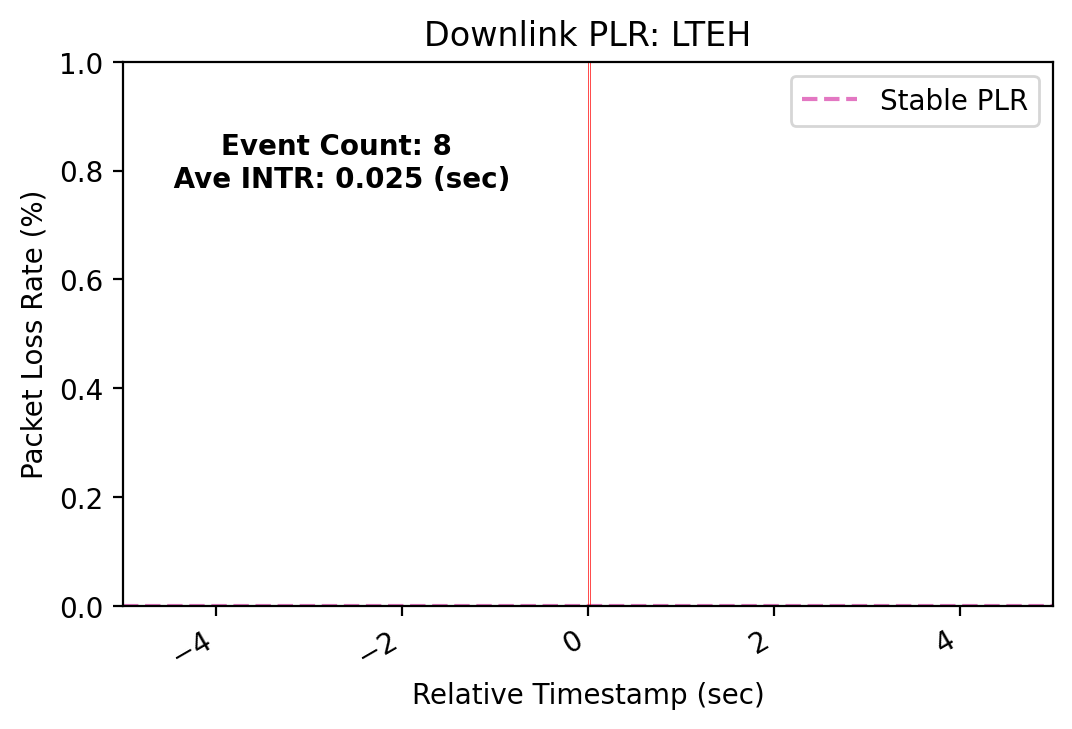

Number of Event: 8
Average Duration: 0.025270624999999998 seconds
[(-0.5, 1.6), (-0.4, 1.7)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.5, 1.6) 0.36


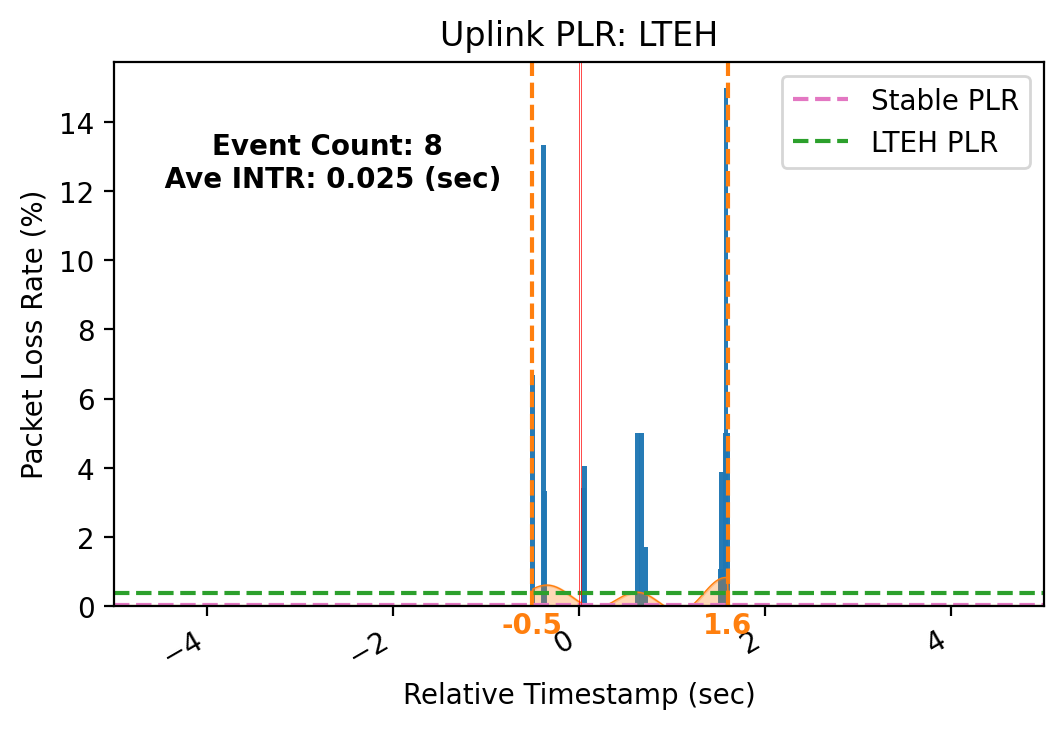

Number of Event: 8
Average Duration: 0.025270624999999998 seconds
[(-3.5, 0.9)]
Downlink Stable ELR: 0.5792
Downlink ELR (-3.5, 0.9) 8.726


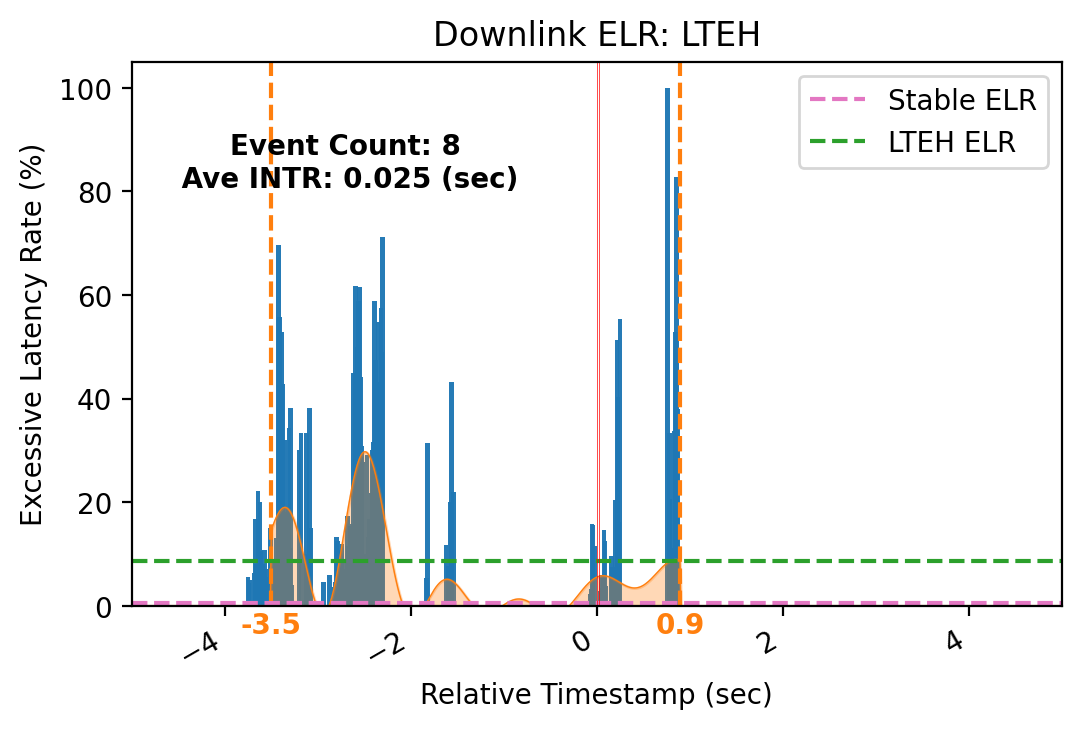

Number of Event: 8
Average Duration: 0.025270624999999998 seconds
[(-4.0, 3.5), (-3.9, 3.6)]
Uplink Stable ELR: 10.9631
Uplink ELR (-4.0, 3.5) 54.81


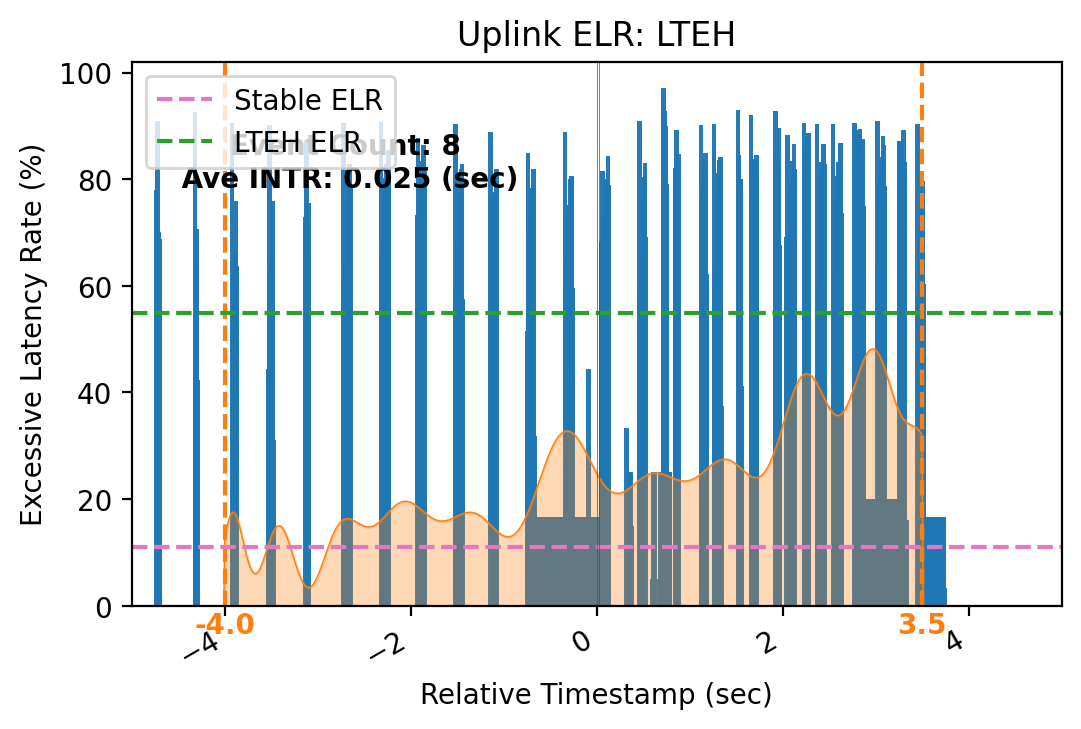

ENBH
Number of Event: 21
Average Duration: 0.023054190476190478 seconds
[(-0.1, 0.6)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 0.6) 4.076


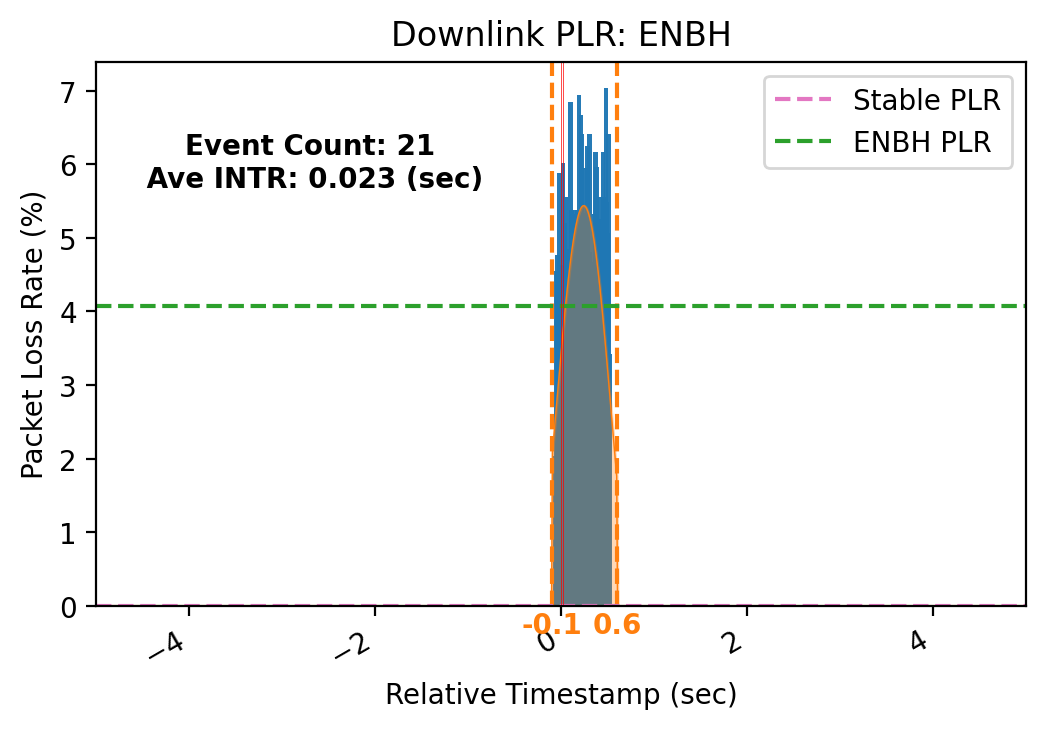

Number of Event: 21
Average Duration: 0.023054190476190478 seconds
[(-0.1, 2.1)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.1, 2.1) 0.234


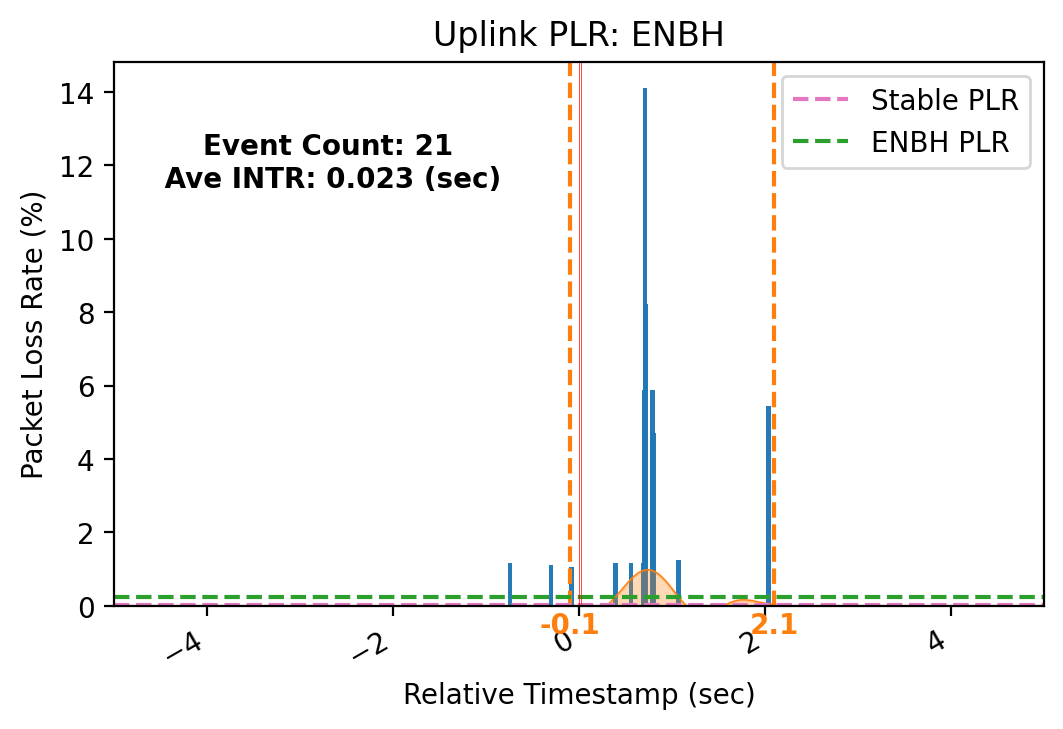

Number of Event: 21
Average Duration: 0.023054190476190478 seconds
[(-1.0, 1.4)]
Downlink Stable ELR: 0.5792
Downlink ELR (-1.0, 1.4) 5.477


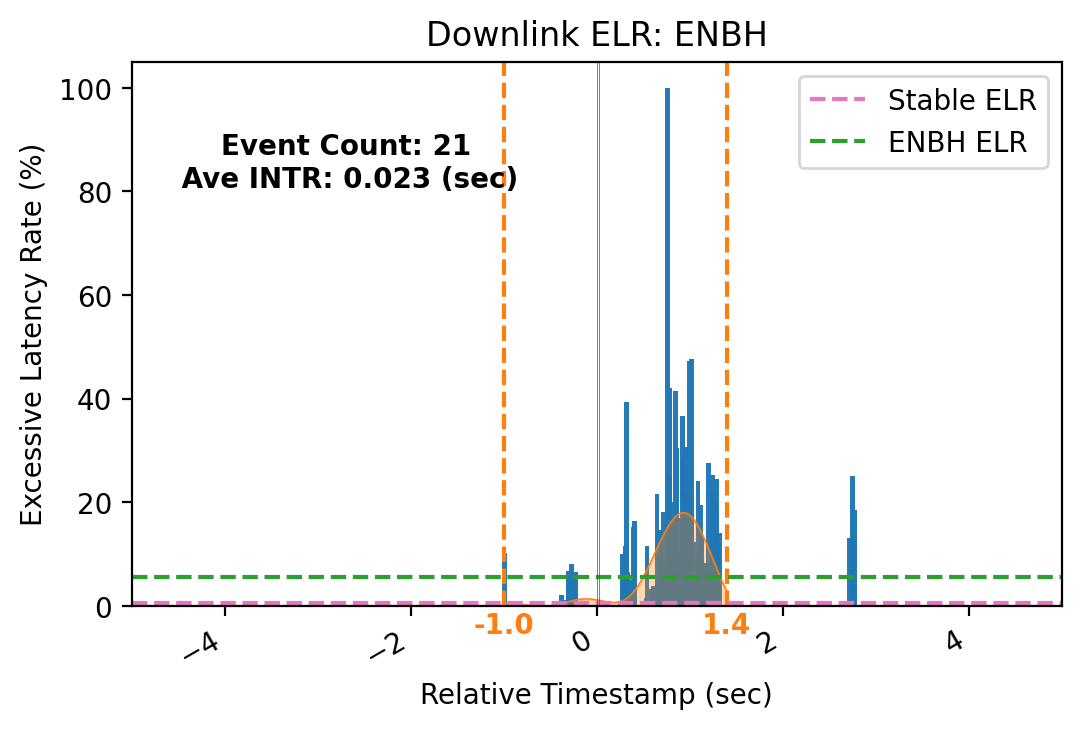

Number of Event: 21
Average Duration: 0.023054190476190478 seconds
[(-5.0, 1.0)]
Uplink Stable ELR: 10.9631
Uplink ELR (-5.0, 1.0) 7.628


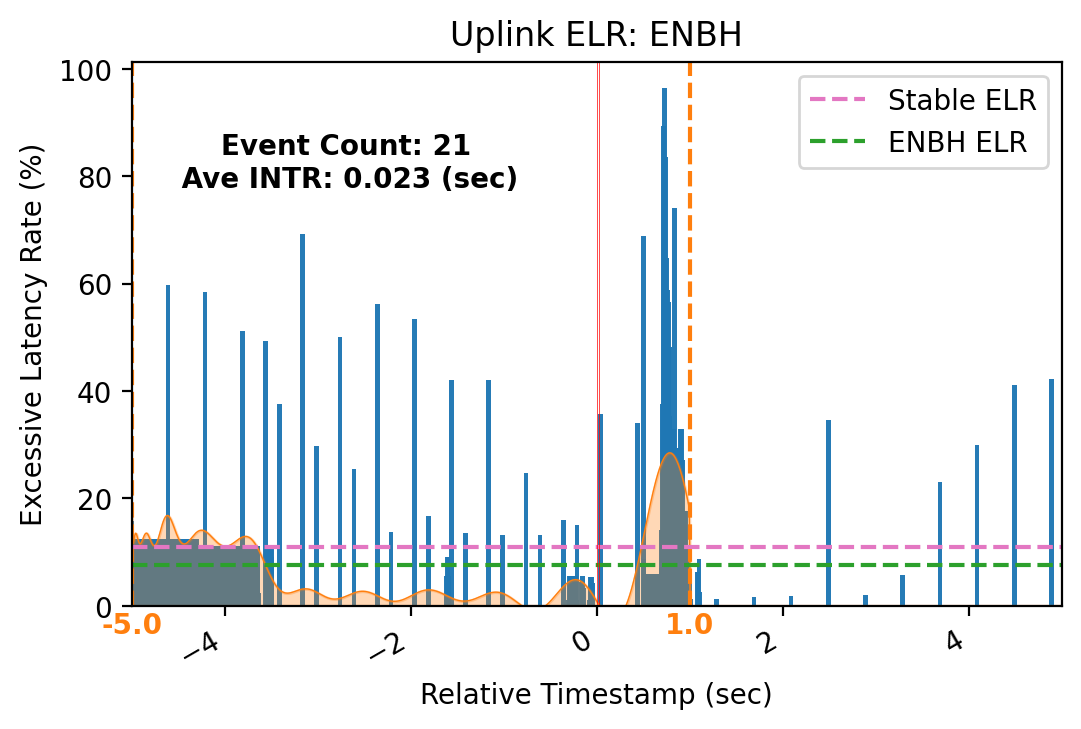

MCGH
Number of Event: 31
Average Duration: 0.01799535483870968 seconds
[(-0.3, 0.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.3, 0.8) 5.58


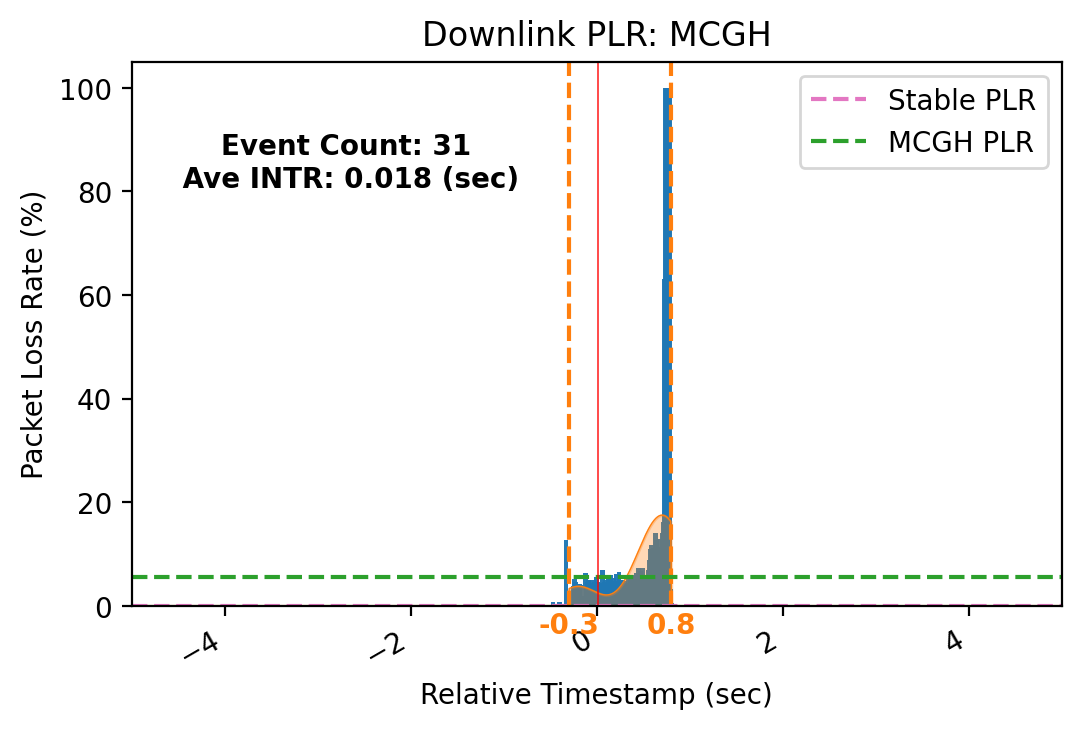

Number of Event: 31
Average Duration: 0.01799535483870968 seconds
[(-0.1, 0.8)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.1, 0.8) 0.193


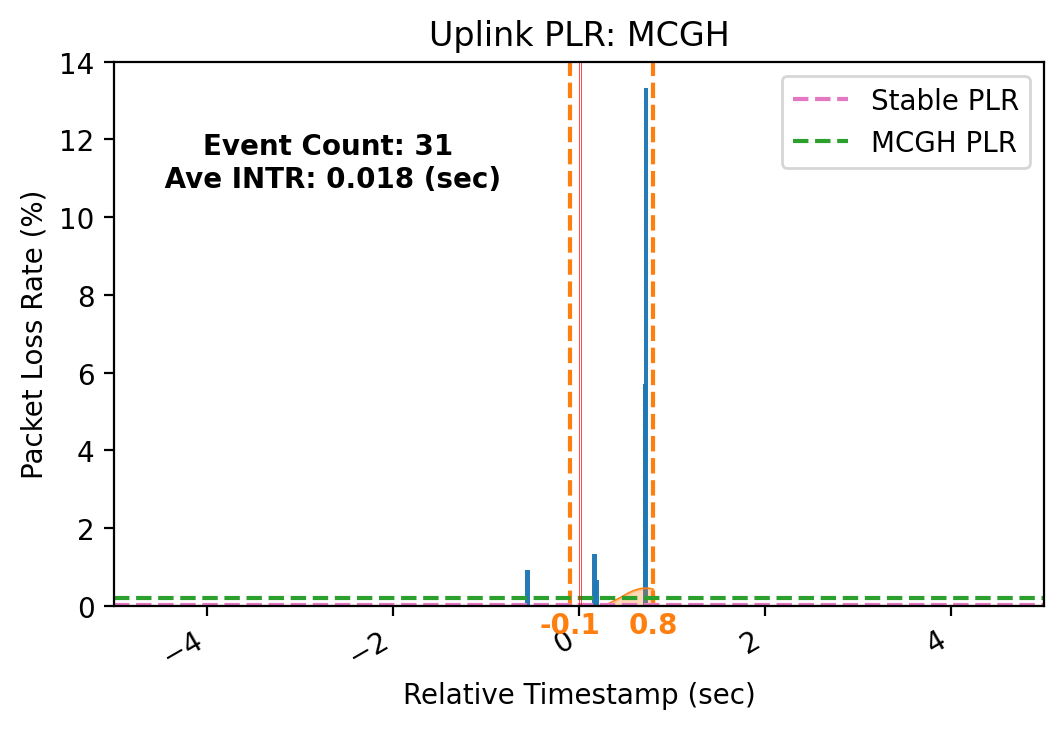

Number of Event: 31
Average Duration: 0.01799535483870968 seconds
[(-0.4, 0.9)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.4, 0.9) 1.324


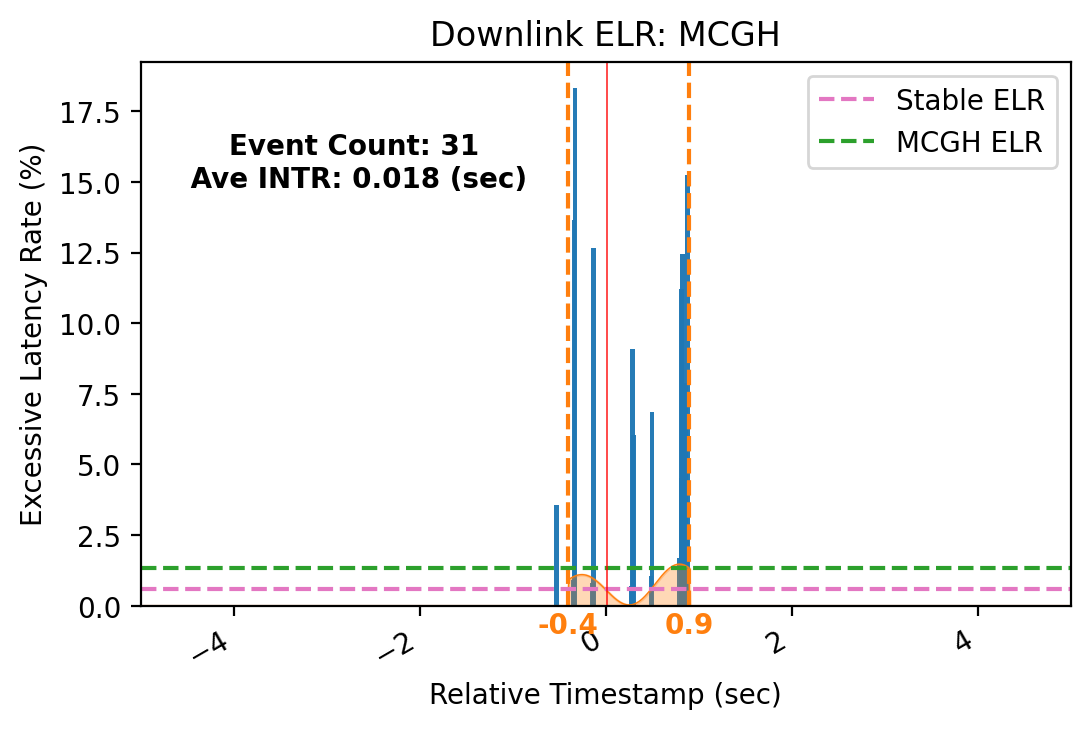

Number of Event: 31
Average Duration: 0.01799535483870968 seconds
[(-0.2, 0.8)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.2, 0.8) 2.783


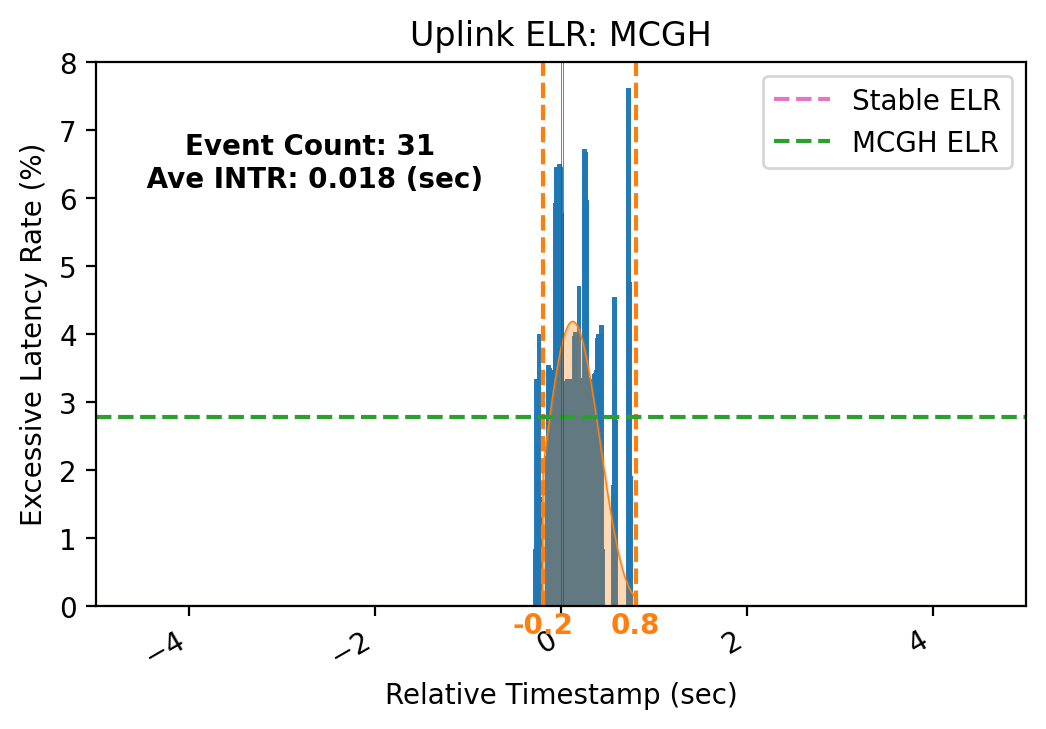

MNBH
Number of Event: 91
Average Duration: 0.019868076923076922 seconds
[(-0.6, 0.9), (-0.5, 1.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.6, 0.9) 3.557


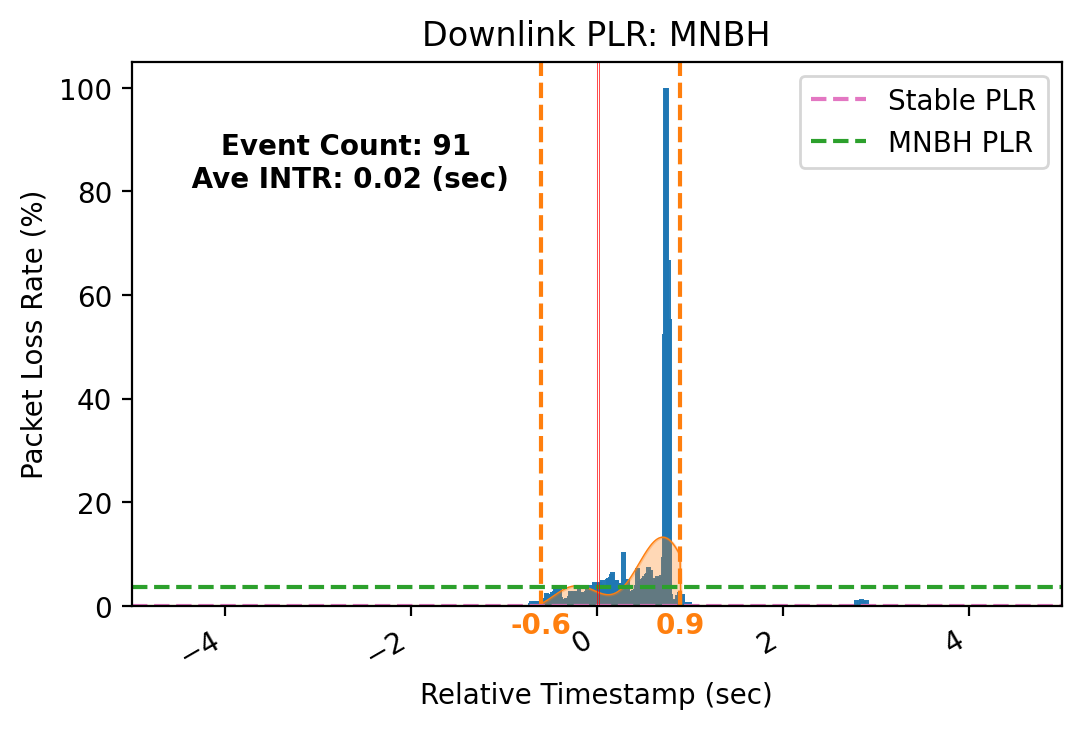

Number of Event: 91
Average Duration: 0.019868076923076922 seconds
[(-0.4, 1.0)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.4, 1.0) 0.398


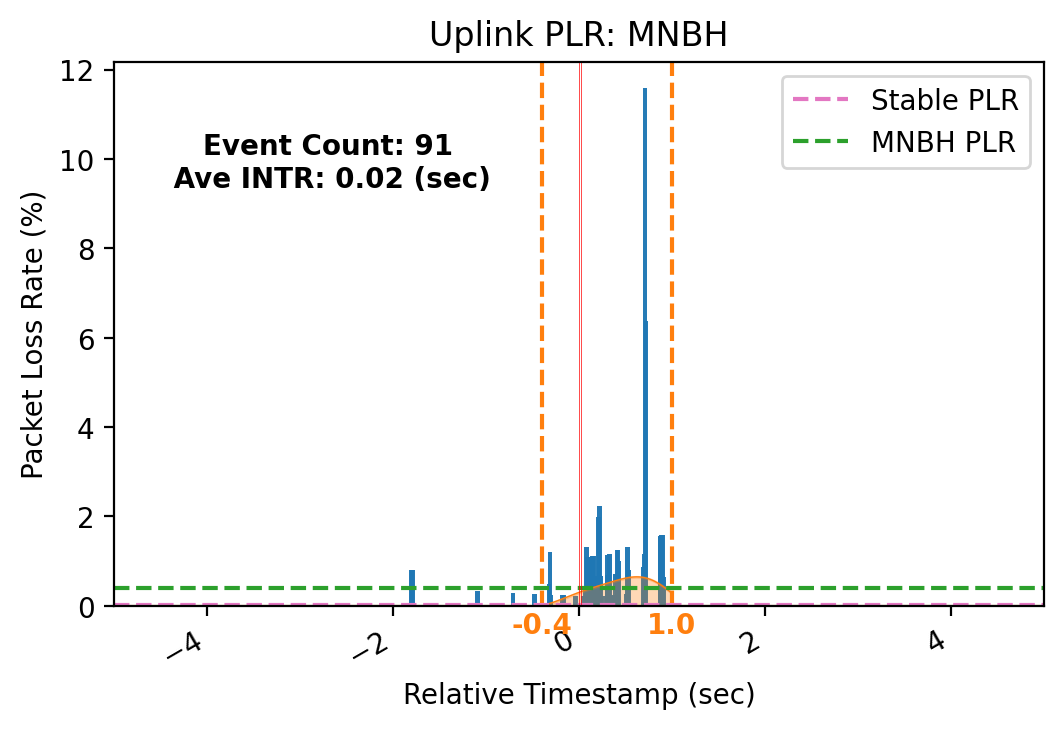

Number of Event: 91
Average Duration: 0.019868076923076922 seconds
[(-0.7, 0.9)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.7, 0.9) 2.821


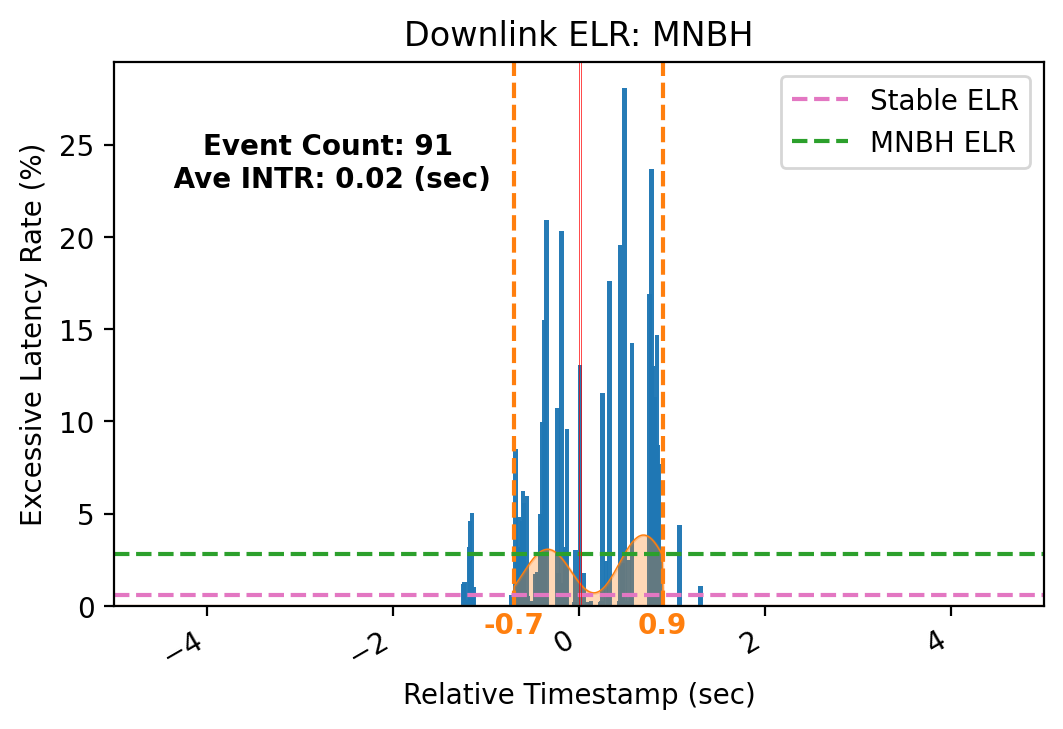

Number of Event: 91
Average Duration: 0.019868076923076922 seconds
[(-4.2, 4.6)]
Uplink Stable ELR: 10.9631
Uplink ELR (-4.2, 4.6) 6.232


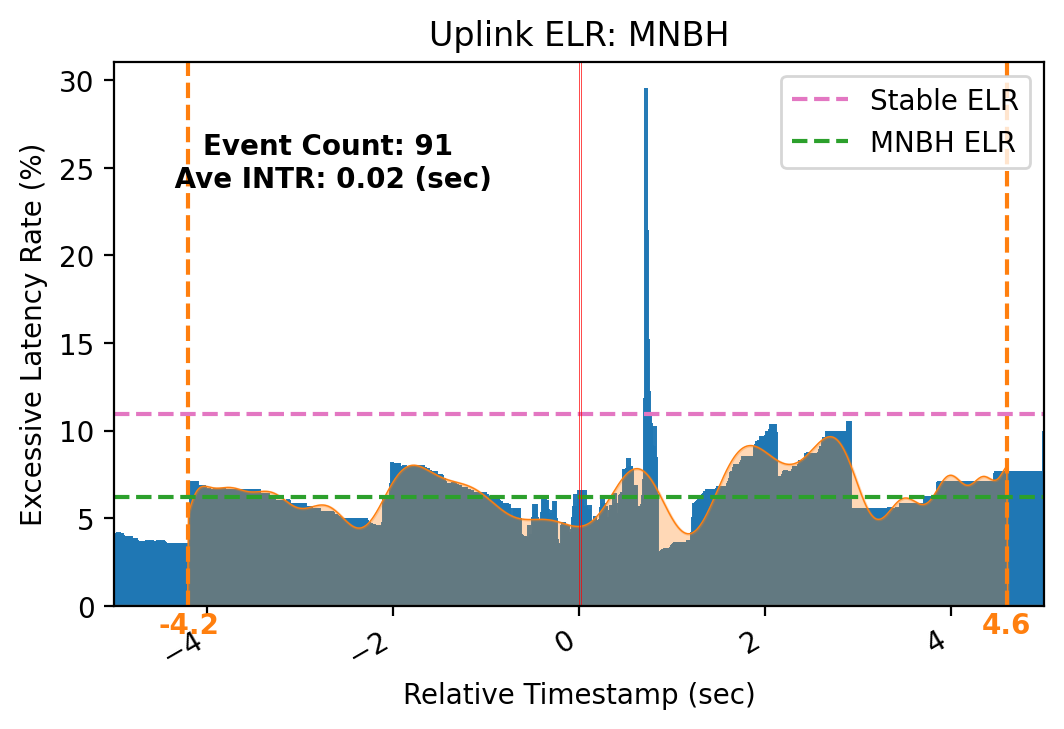

SCGM
Number of Event: 116
Average Duration: 0.01684015517241379 seconds
[(-1.0, 0.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-1.0, 0.8) 0.701


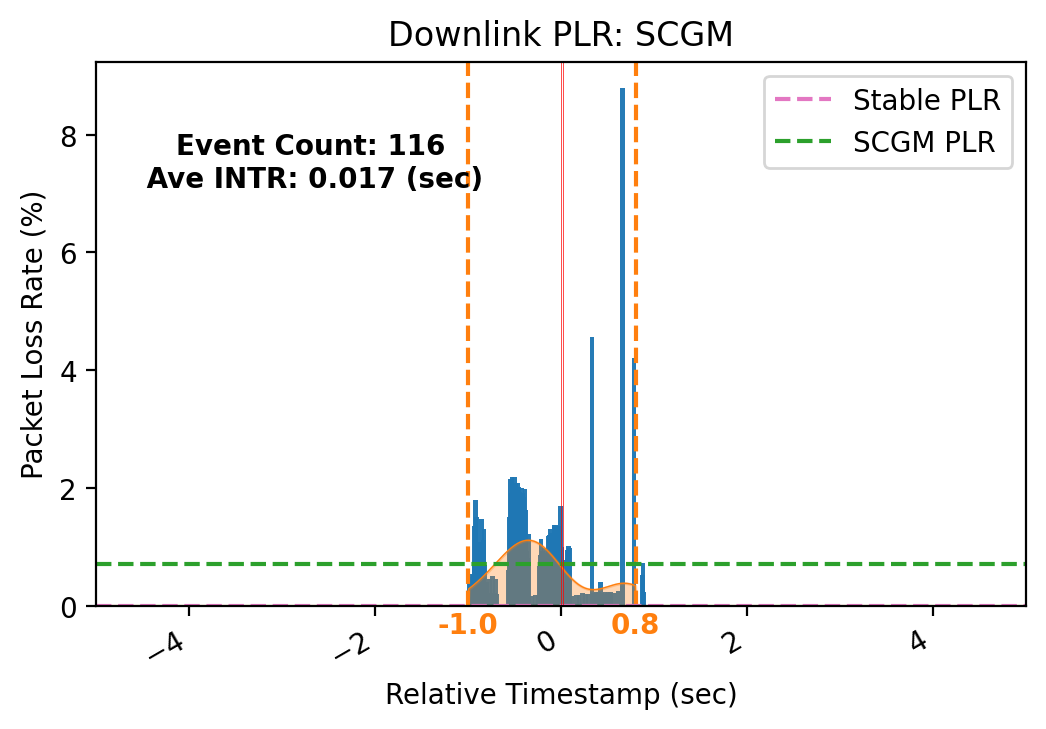

Number of Event: 116
Average Duration: 0.01684015517241379 seconds
[(-0.9, 0.5)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.9, 0.5) 0.097


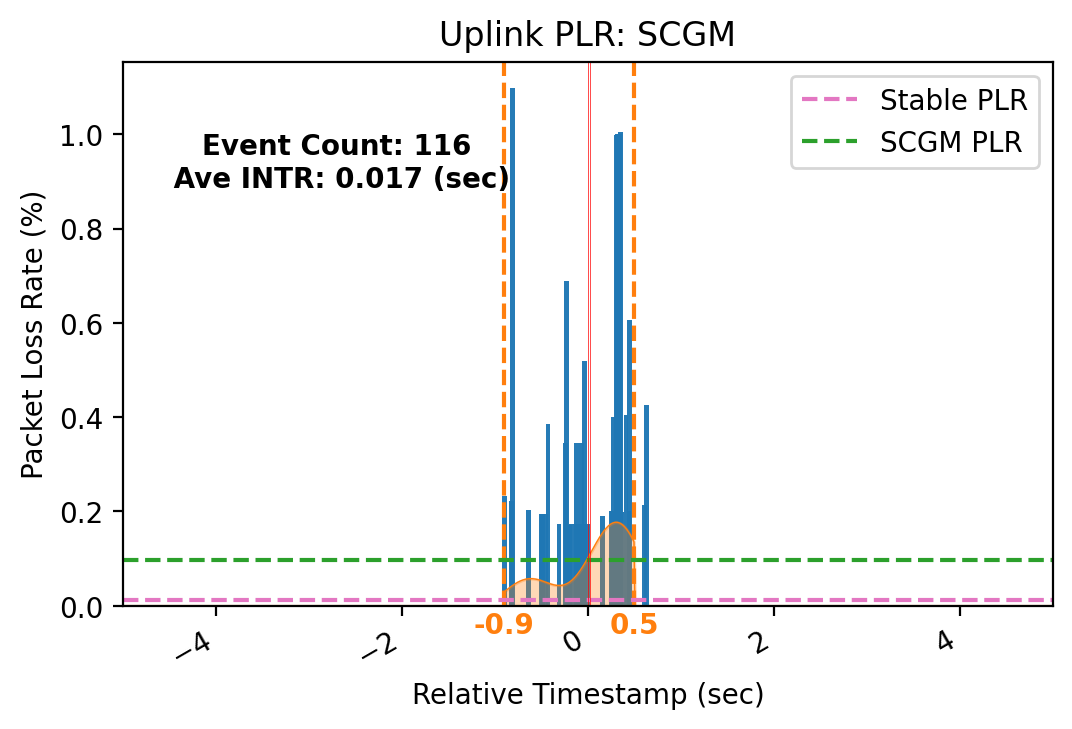

Number of Event: 116
Average Duration: 0.01684015517241379 seconds
[(-1.7, 1.1)]
Downlink Stable ELR: 0.5792
Downlink ELR (-1.7, 1.1) 1.483


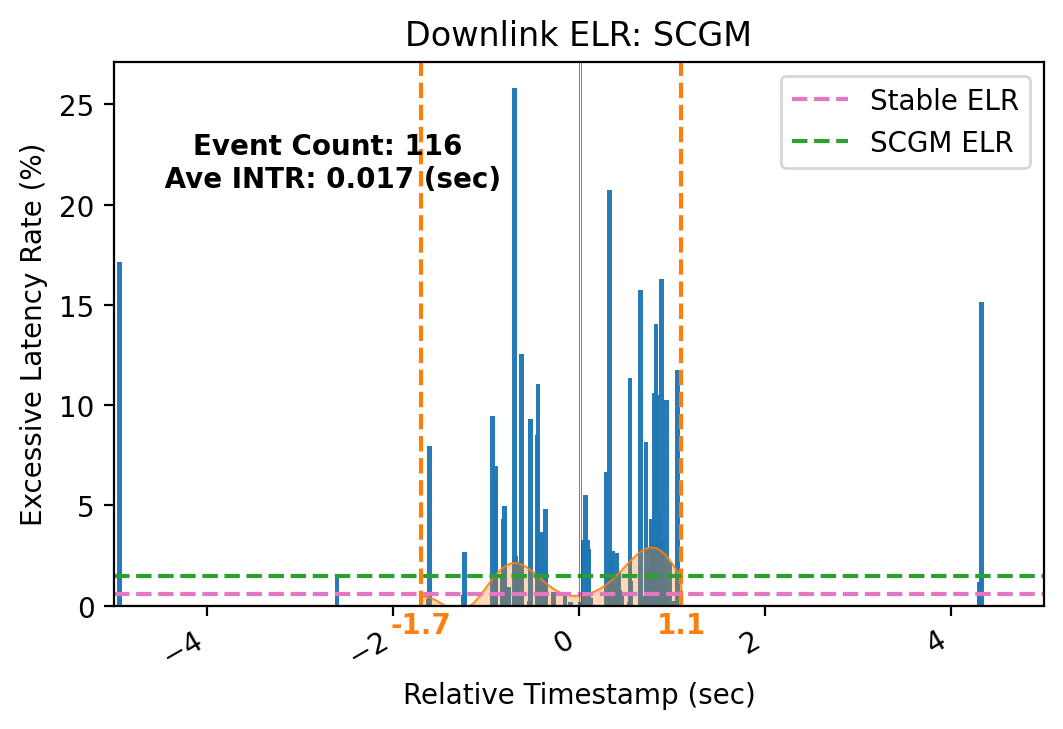

Number of Event: 116
Average Duration: 0.01684015517241379 seconds
[(-0.9, 4.1), (-0.8, 4.2), (-0.7, 4.3)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.9, 4.1) 4.463


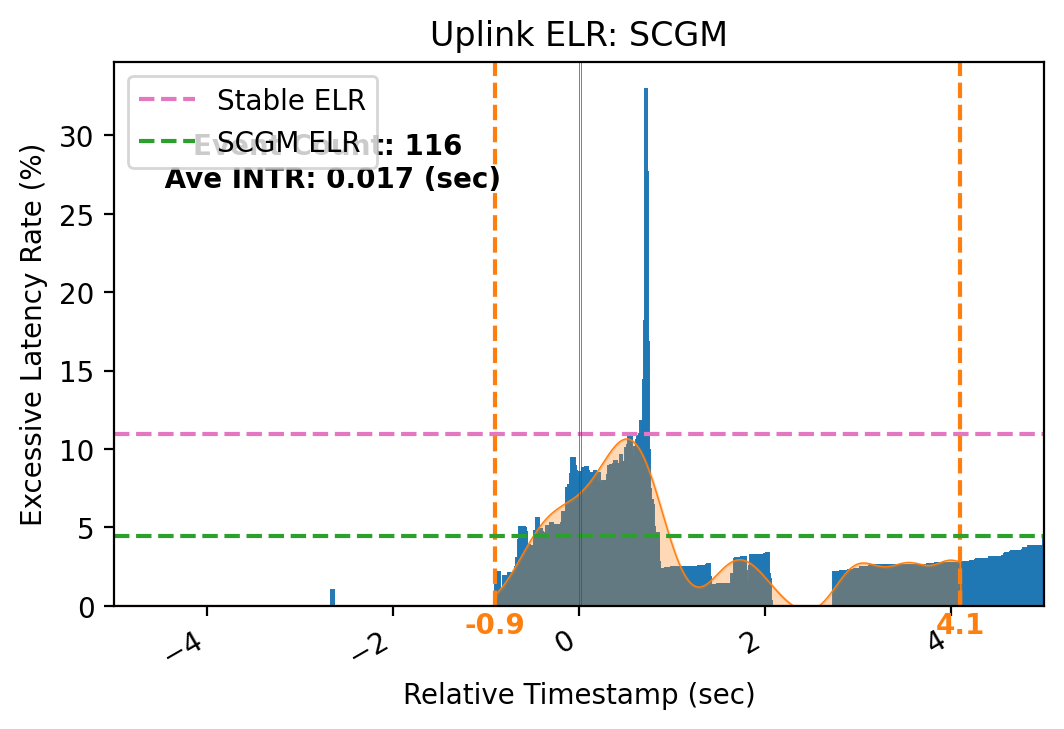

SCGA
Number of Event: 9
Average Duration: 0.02942822222222222 seconds
[(-0.1, 0.9)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 0.9) 0.739


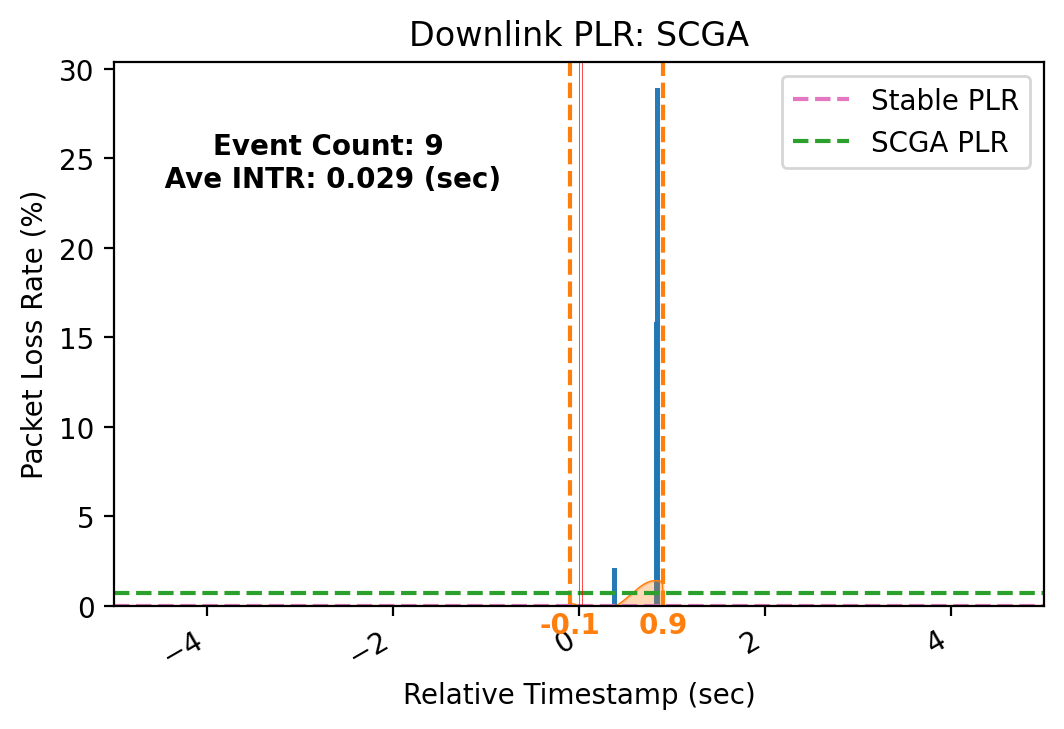

Number of Event: 9
Average Duration: 0.02942822222222222 seconds
[(-0.1, 1.2)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.1, 1.2) 6.014


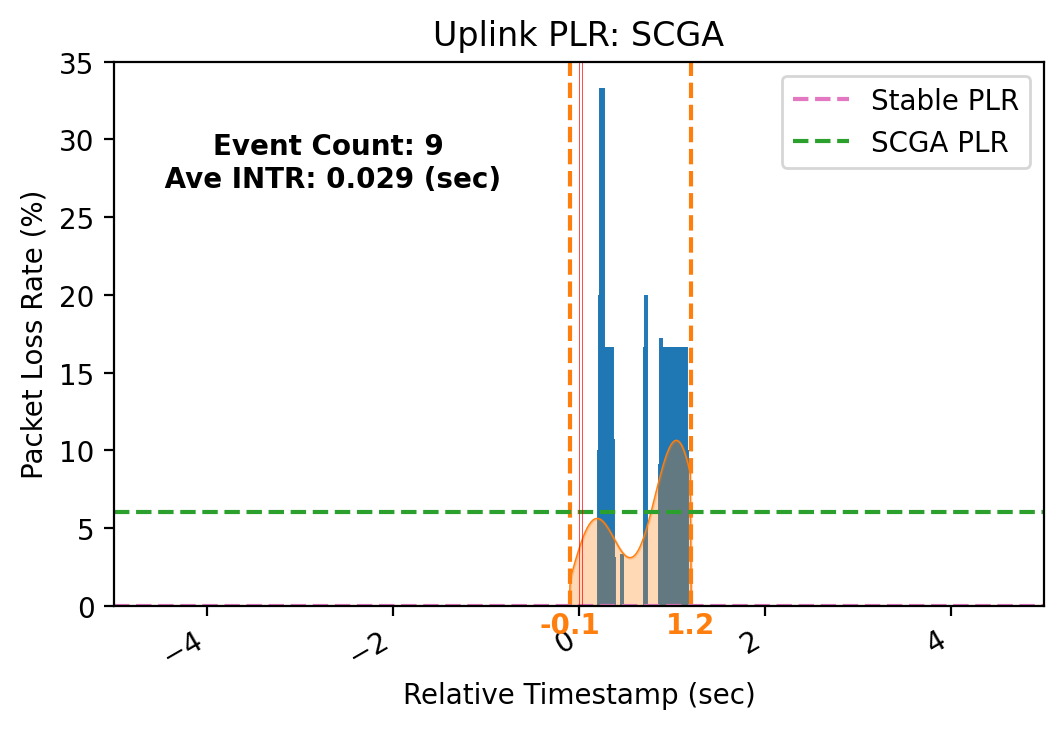

Number of Event: 9
Average Duration: 0.02942822222222222 seconds
[(-0.2, 1.3)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.2, 1.3) 14.929


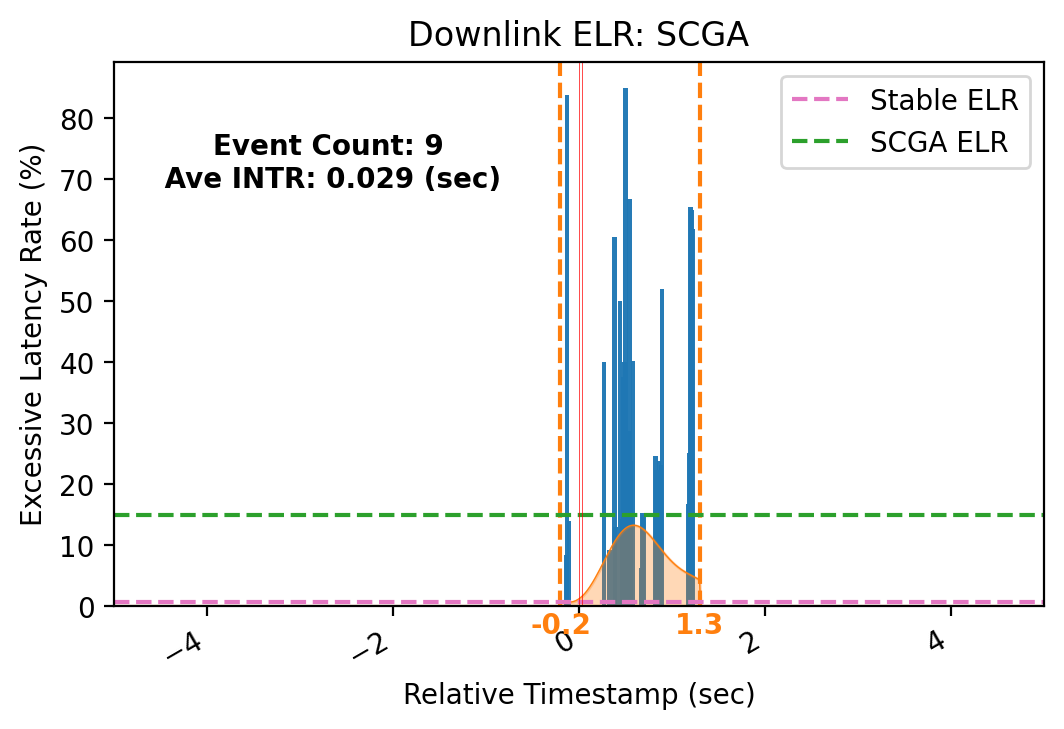

Number of Event: 9
Average Duration: 0.02942822222222222 seconds
[(-0.1, 0.9)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.1, 0.9) 30.029


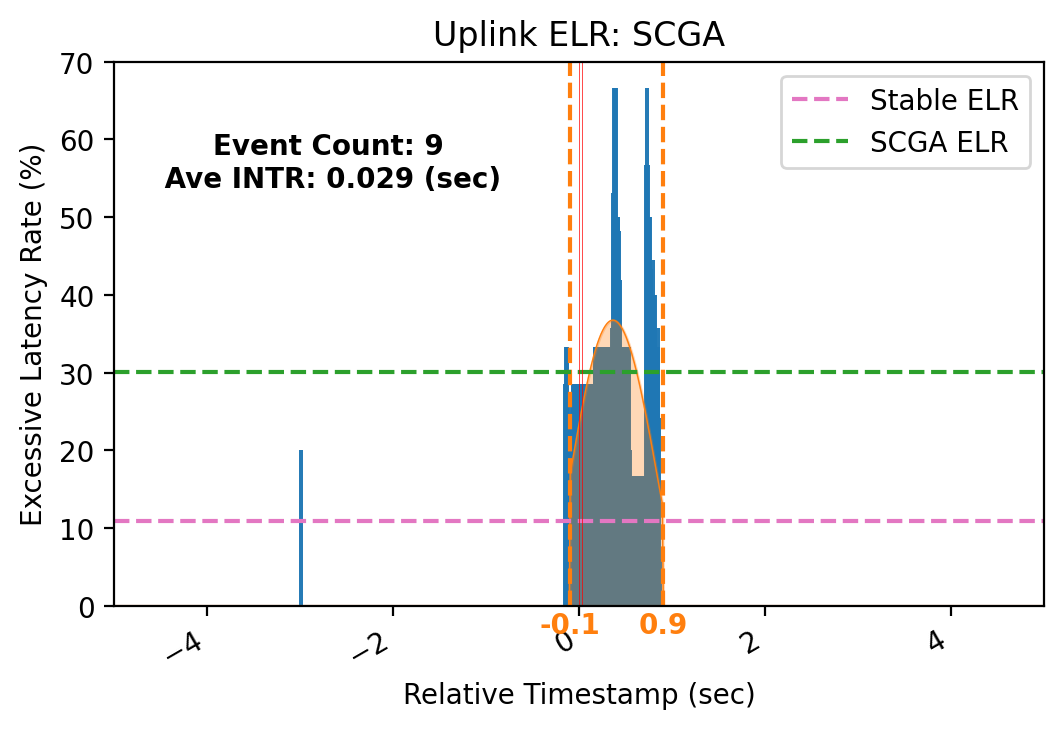

SCGR-I
Number of Event: 2
Average Duration: 0.0364925 seconds


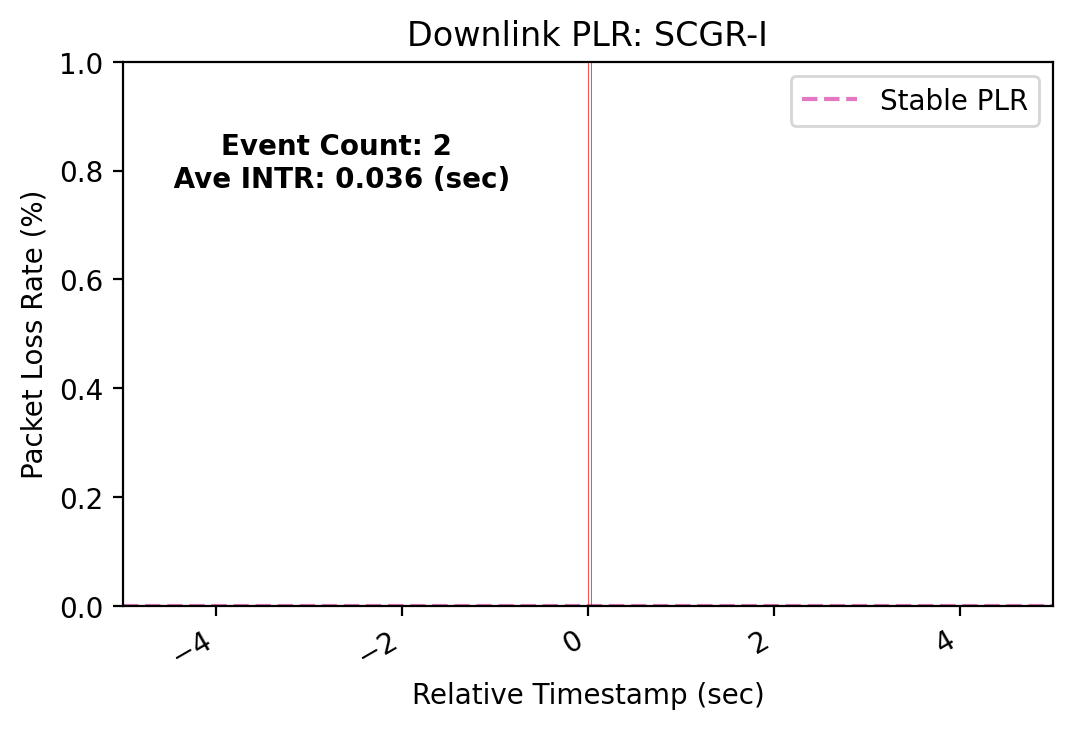

Number of Event: 2
Average Duration: 0.0364925 seconds
[(-4.1, 0.4)]
Uplink Stable PLR: 0.0118
Uplink PLR (-4.1, 0.4) 0.42


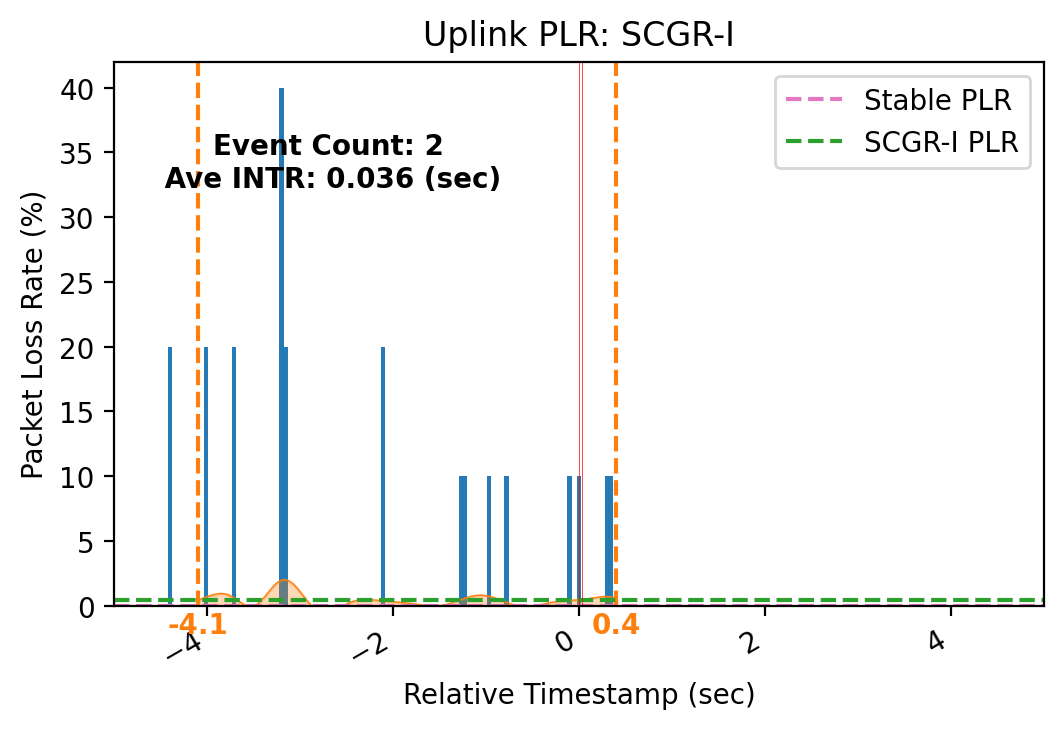

Number of Event: 2
Average Duration: 0.0364925 seconds
[(-0.6, 1.0)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.6, 1.0) 2.349


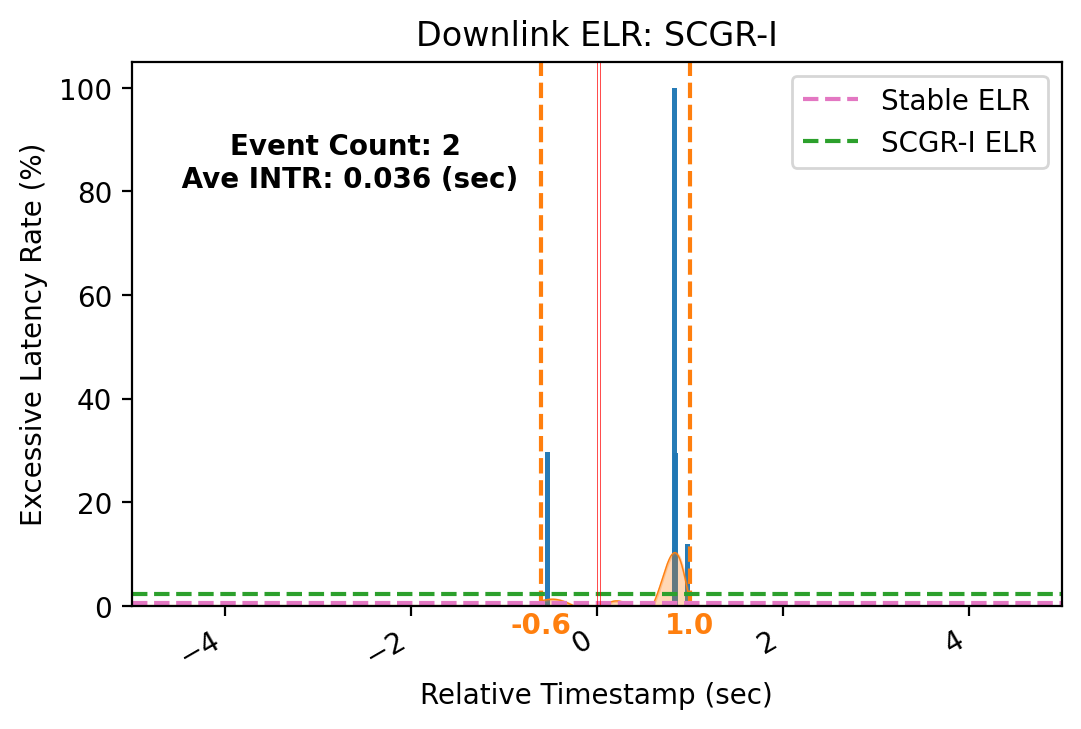

Number of Event: 2
Average Duration: 0.0364925 seconds
[(-4.8, 0.8)]
Uplink Stable ELR: 10.9631
Uplink ELR (-4.8, 0.8) 99.192


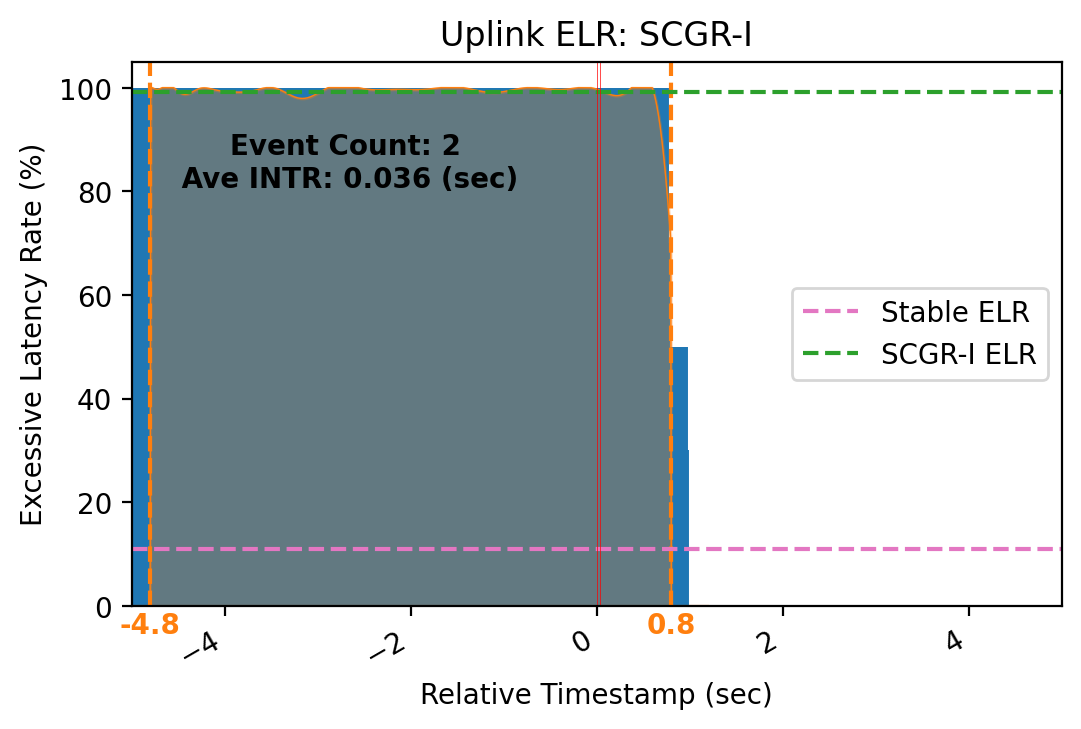

SCGR-II
Number of Event: 3
Average Duration: 0.035036 seconds


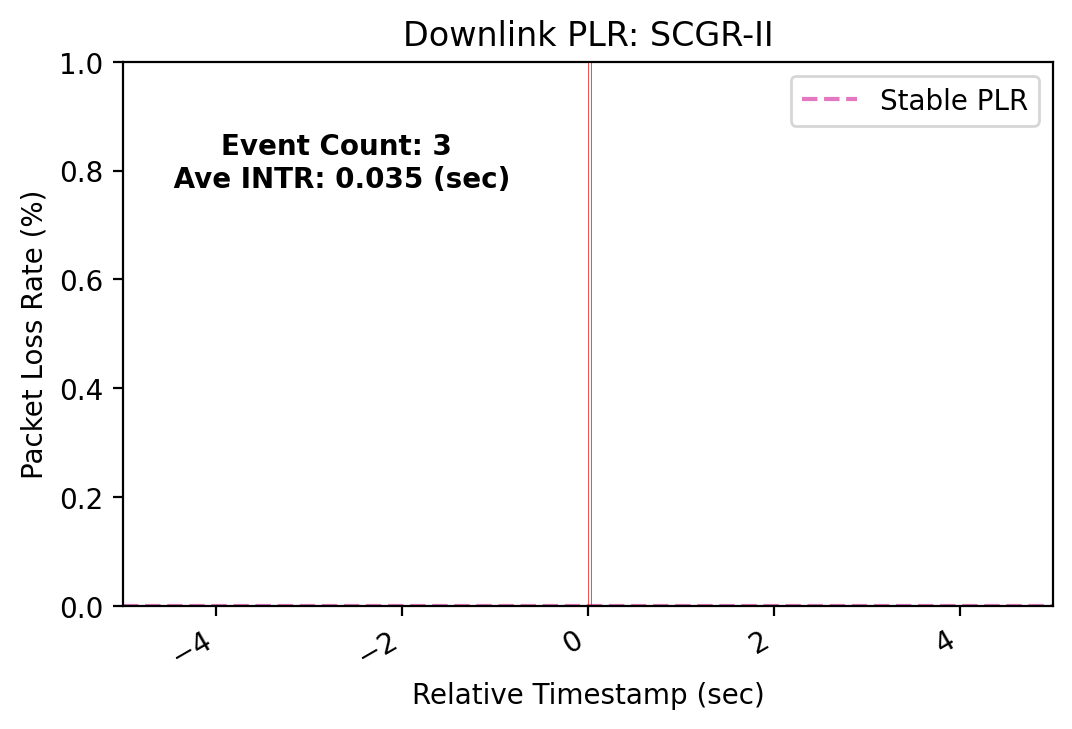

Number of Event: 3
Average Duration: 0.035036 seconds


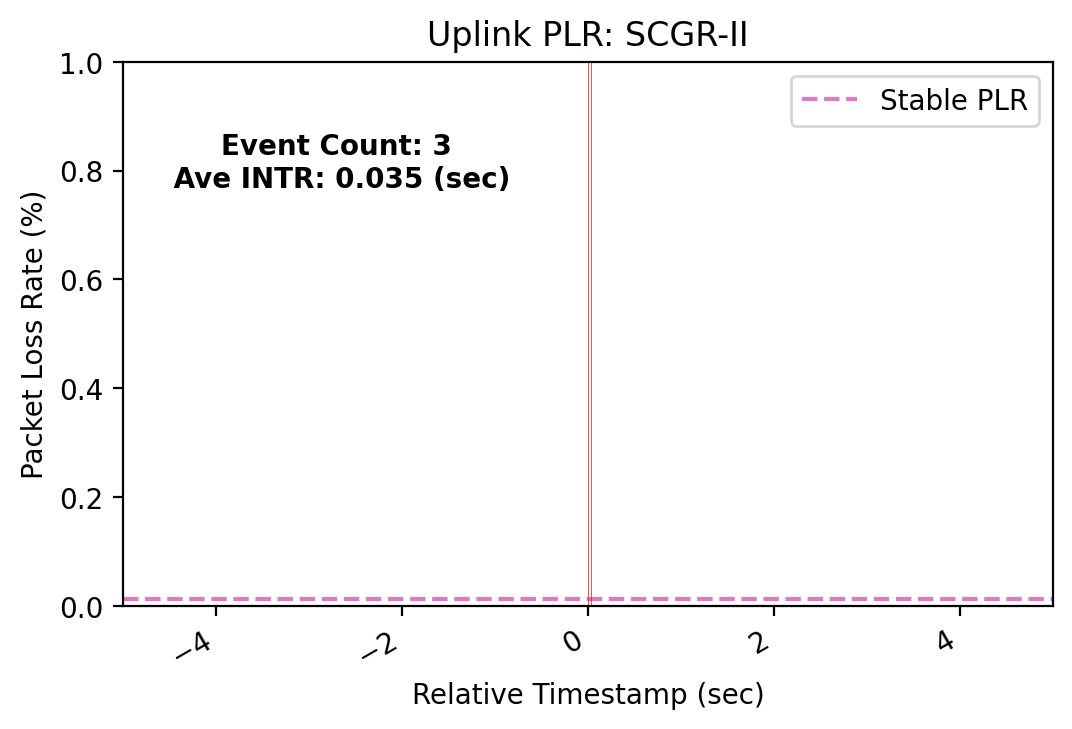

Number of Event: 3
Average Duration: 0.035036 seconds
[(-0.1, 0.1)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.1, 0.1) 17.695


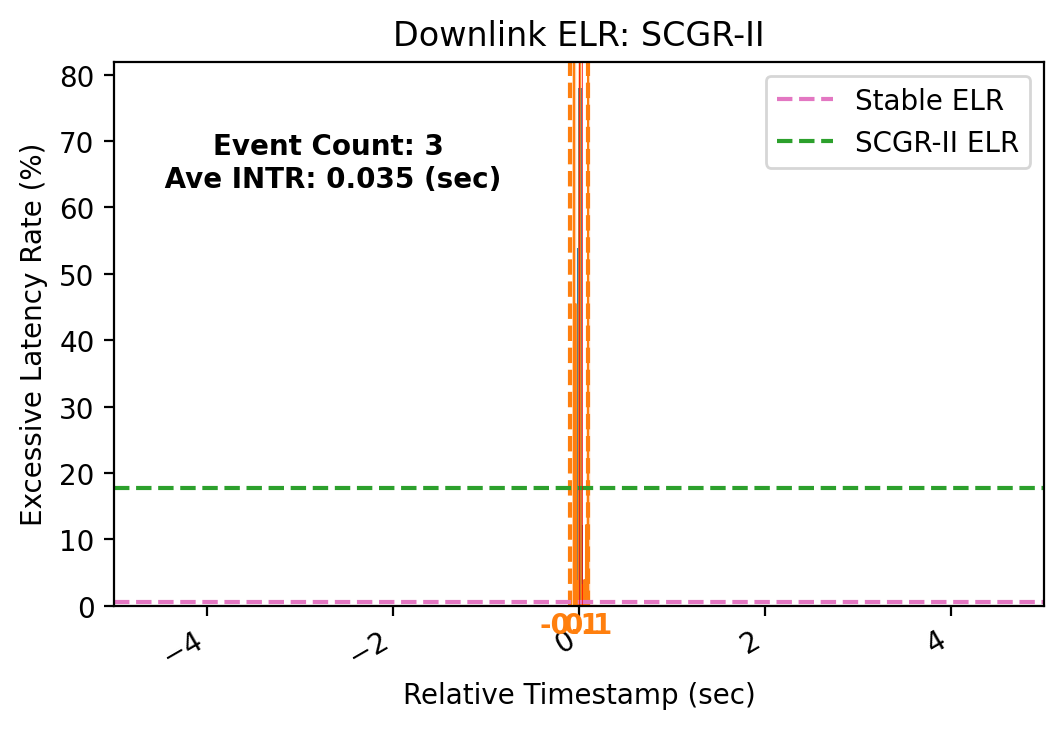

Number of Event: 3
Average Duration: 0.035036 seconds
[(-0.1, 0.2)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.1, 0.2) 3.835


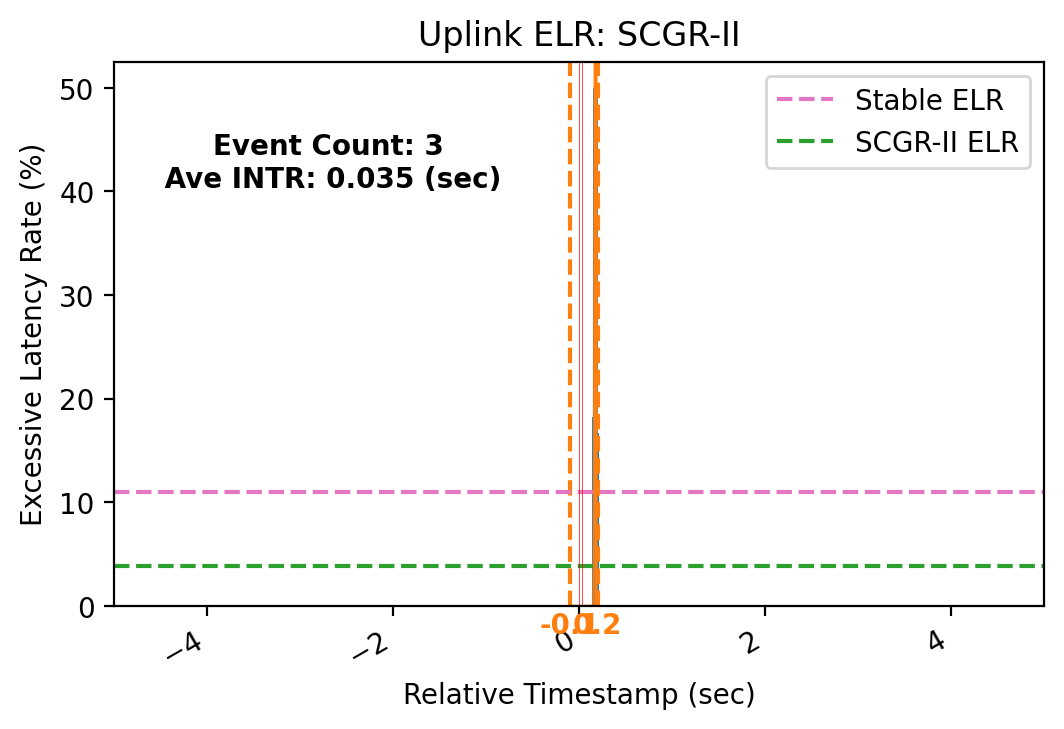

SCGC-I
Number of Event: 1
Average Duration: 0.434864 seconds
[(-2.8, 0.1)]
Downlink Stable PLR: 0.0
Downlink PLR (-2.8, 0.1) 3.489


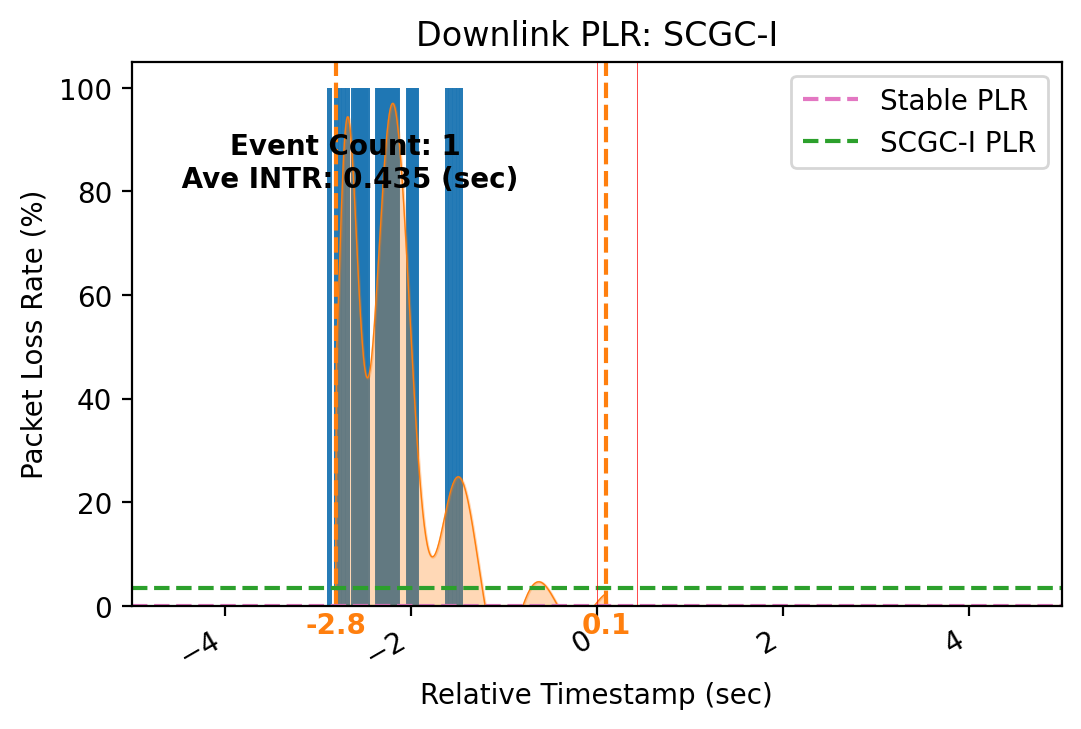

Number of Event: 1
Average Duration: 0.434864 seconds
[(-1.4, 0.2)]
Uplink Stable PLR: 0.0118
Uplink PLR (-1.4, 0.2) 1.384


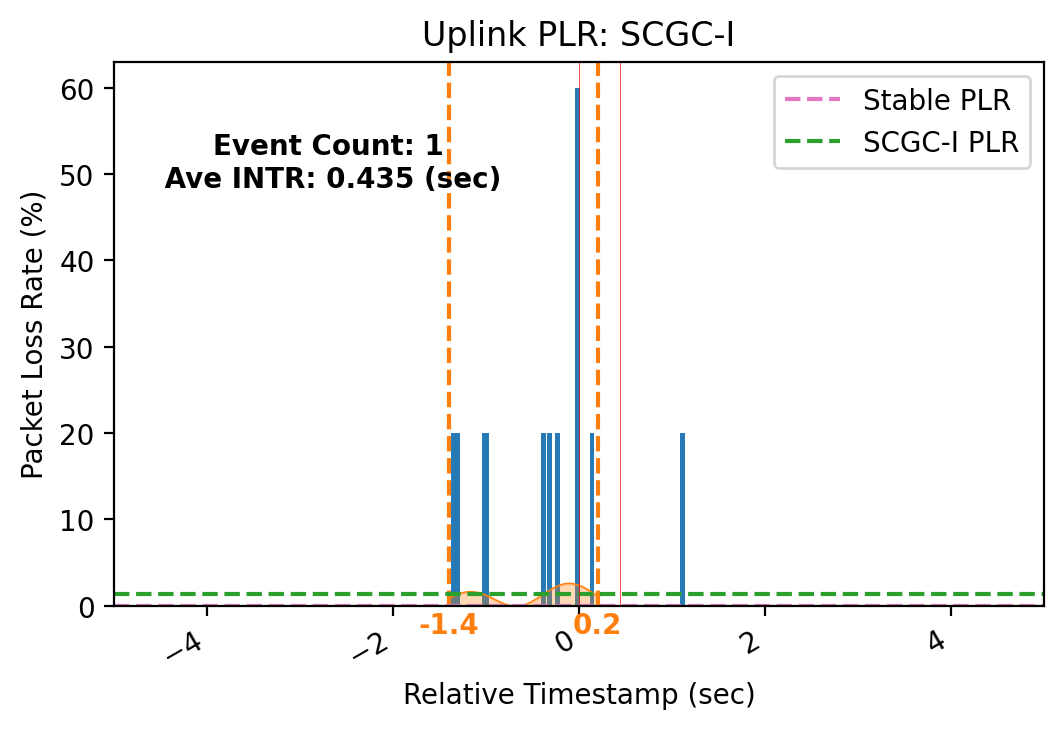

Number of Event: 1
Average Duration: 0.434864 seconds
[(-2.9, 1.3)]
Downlink Stable ELR: 0.5792
Downlink ELR (-2.9, 1.3) 23.275


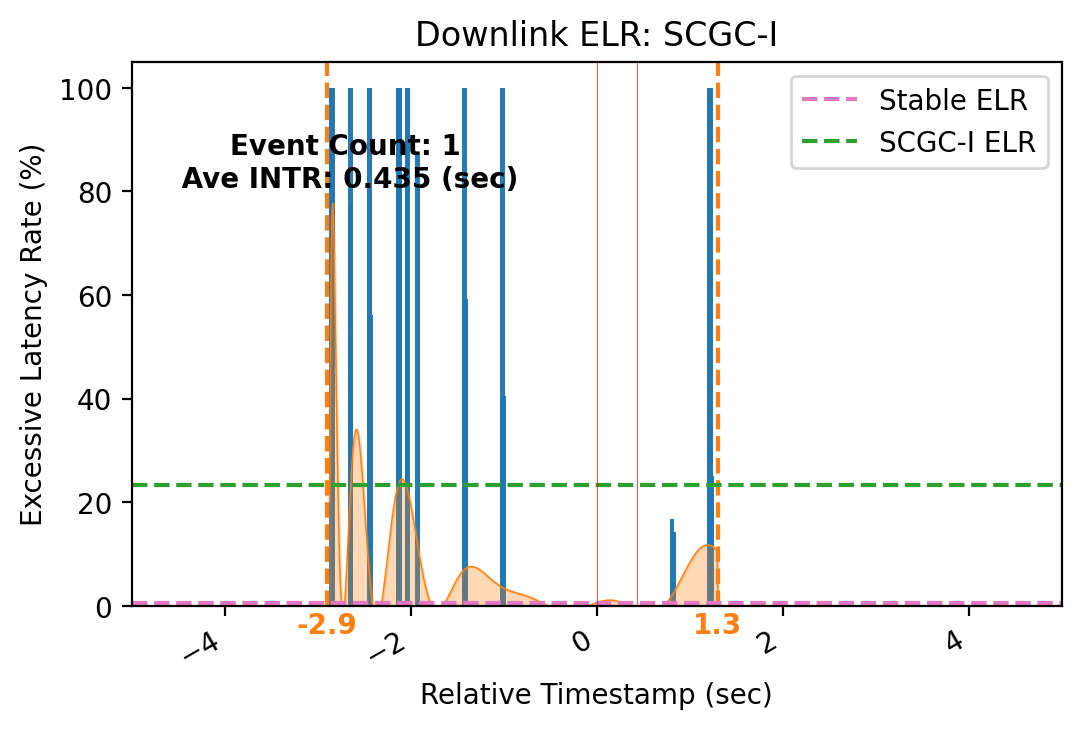

Number of Event: 1
Average Duration: 0.434864 seconds
[(-2.8, 0.9)]
Uplink Stable ELR: 10.9631
Uplink ELR (-2.8, 0.9) 97.886


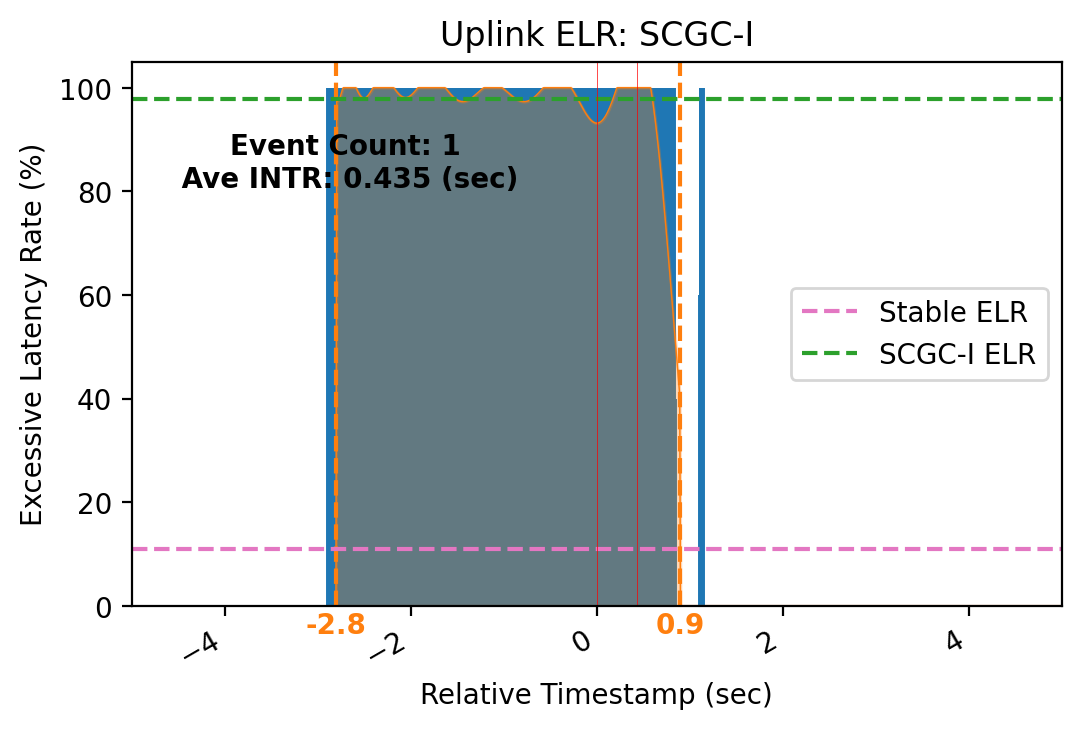

SCGC-II
Number of Event: 8
Average Duration: 0.463513 seconds
[(-0.1, 1.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 1.0) 1.064


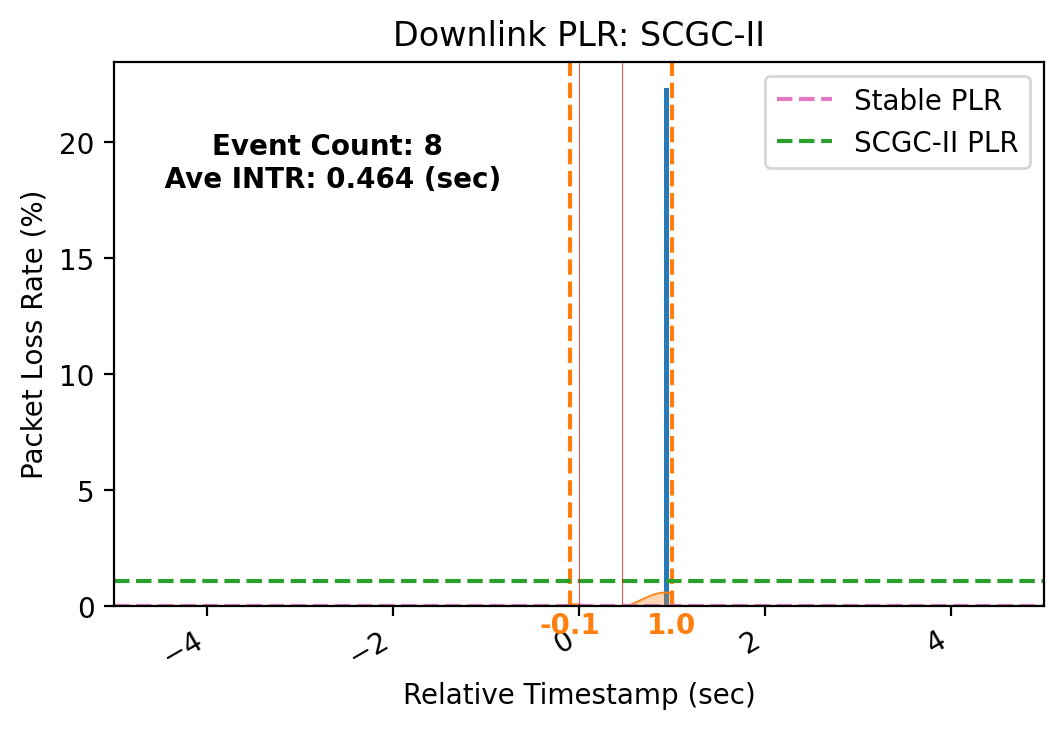

Number of Event: 8
Average Duration: 0.463513 seconds
[(-0.1, 1.3)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.1, 1.3) 2.995


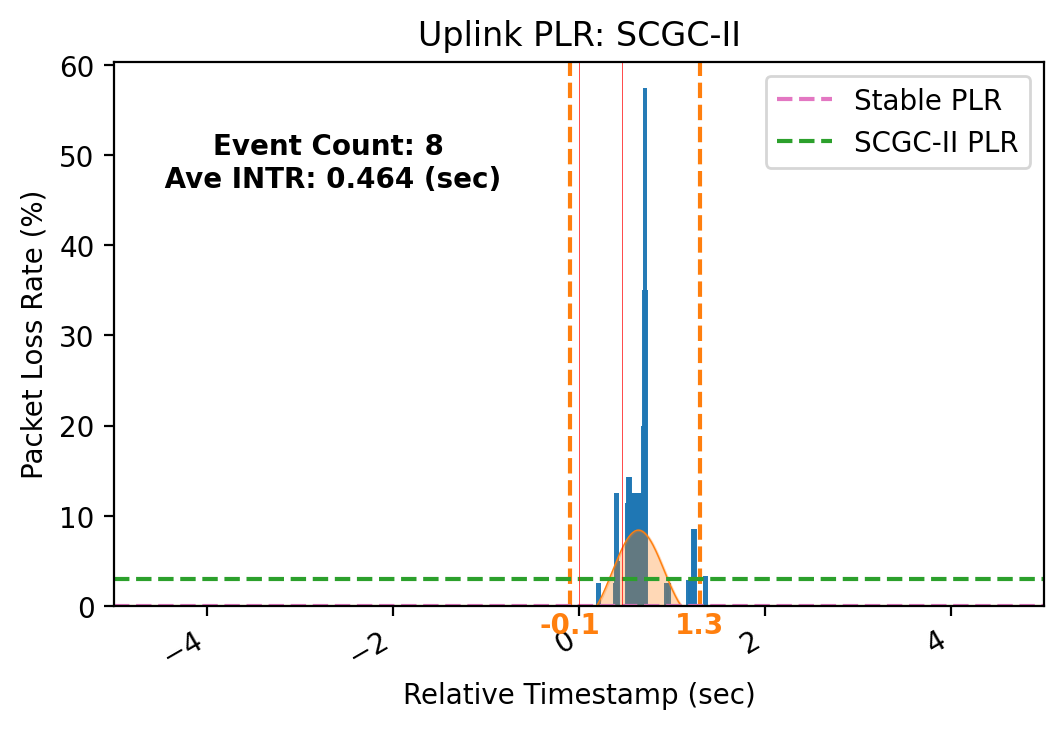

Number of Event: 8
Average Duration: 0.463513 seconds
[(-0.1, 1.4)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.1, 1.4) 9.05


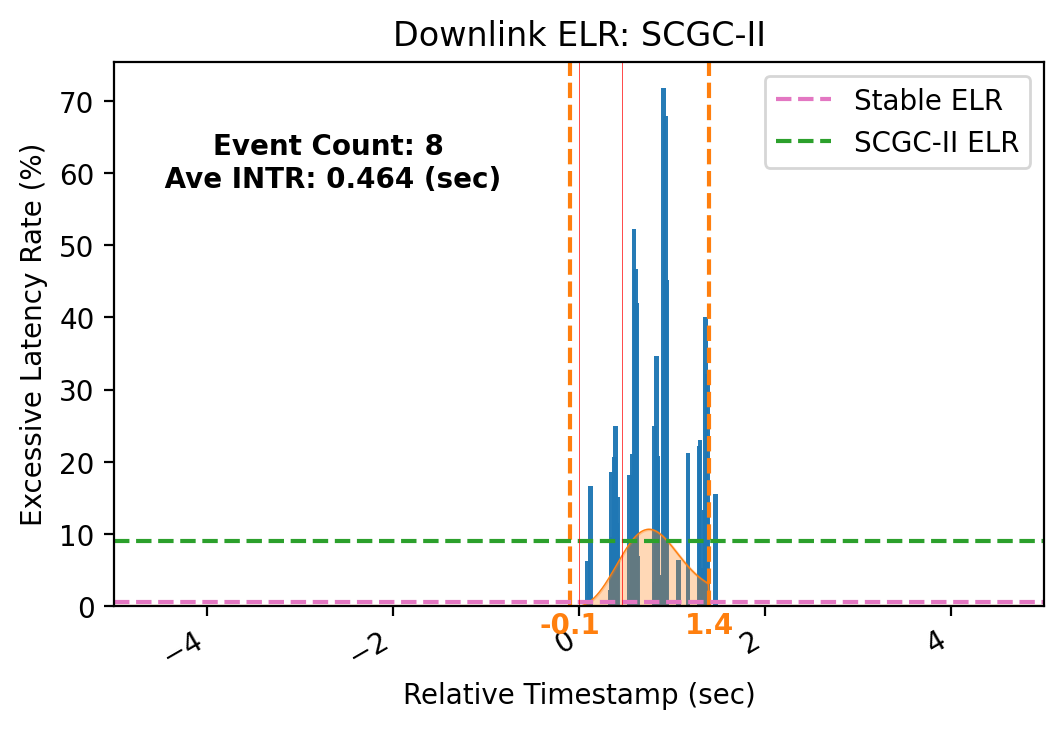

Number of Event: 8
Average Duration: 0.463513 seconds
[(-0.1, 1.3)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.1, 1.3) 9.299


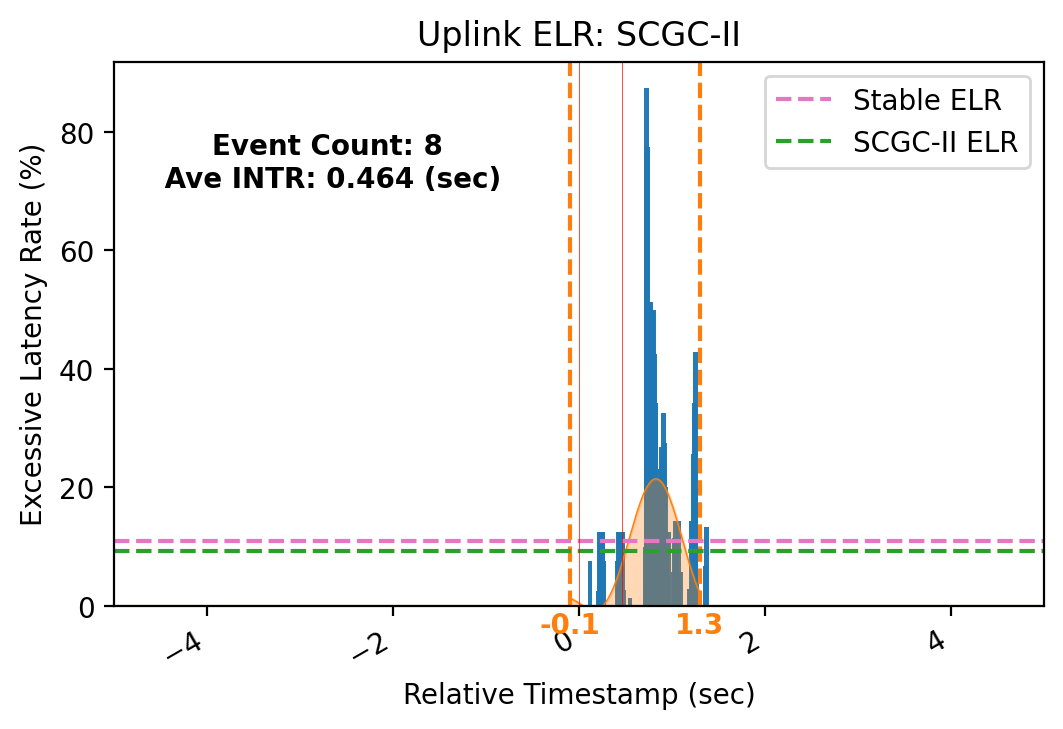

MCGF
Number of Event: 15
Average Duration: 0.08446086666666665 seconds
[(-4.3, 1.0)]
Downlink Stable PLR: 0.0
Downlink PLR (-4.3, 1.0) 30.041


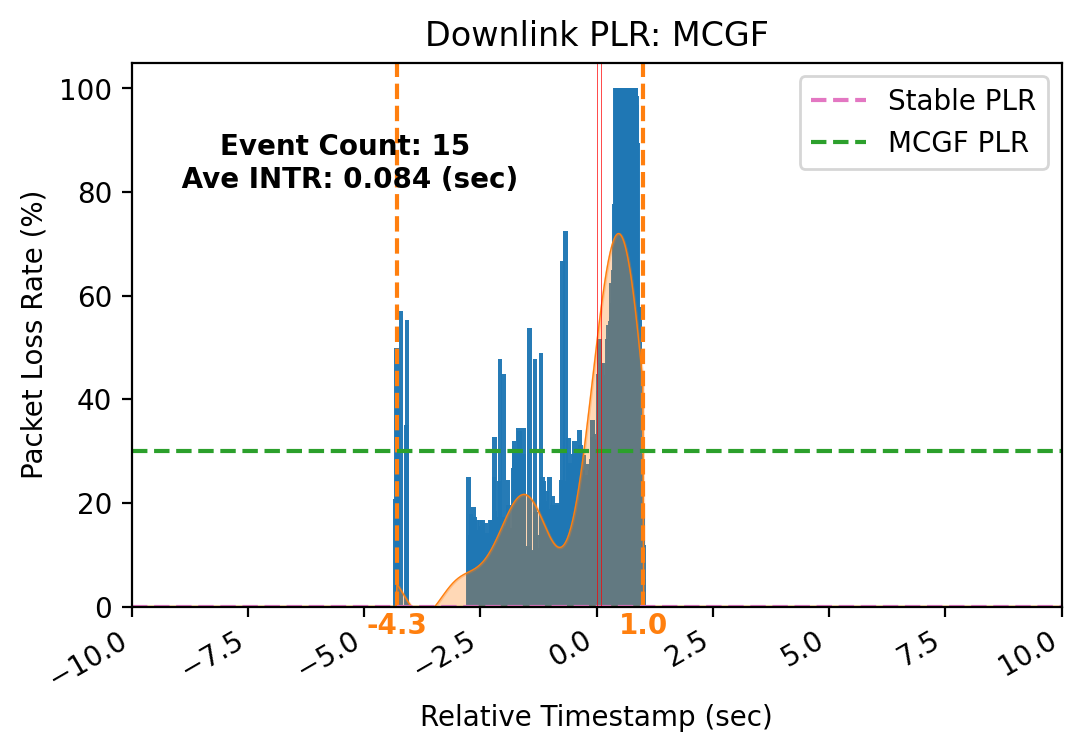

Number of Event: 15
Average Duration: 0.08446086666666665 seconds
[(-0.5, 1.2)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.5, 1.2) 8.1


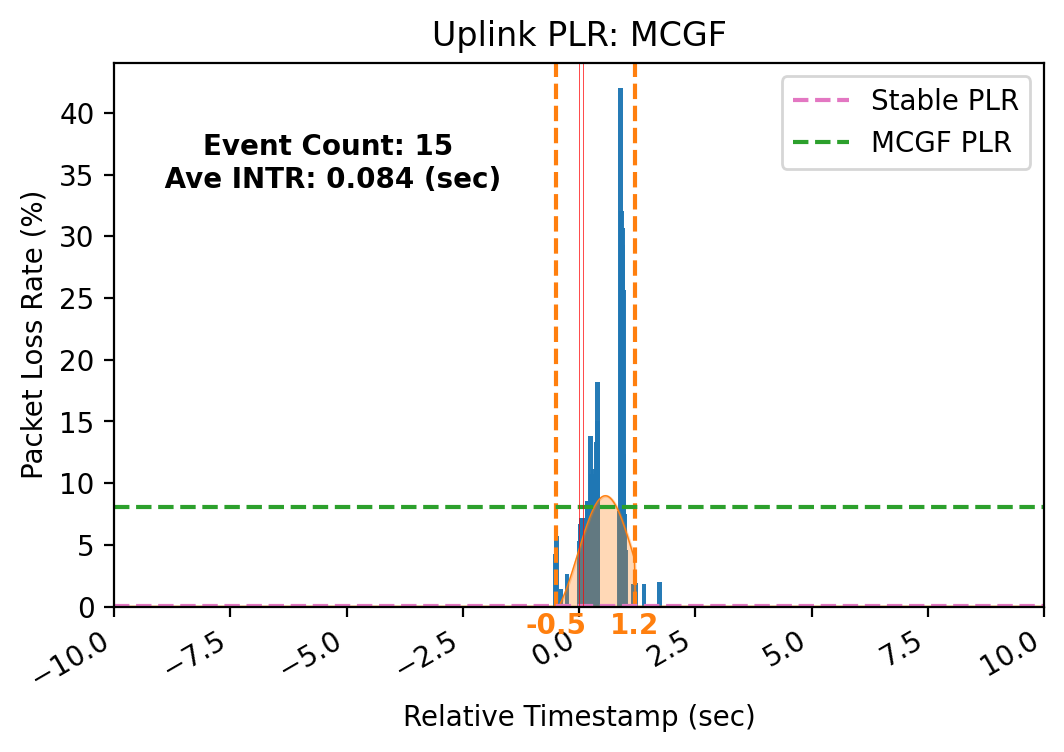

Number of Event: 15
Average Duration: 0.08446086666666665 seconds
[(-9.0, 6.3)]
Downlink Stable ELR: 0.5792
Downlink ELR (-9.0, 6.3) 7.655


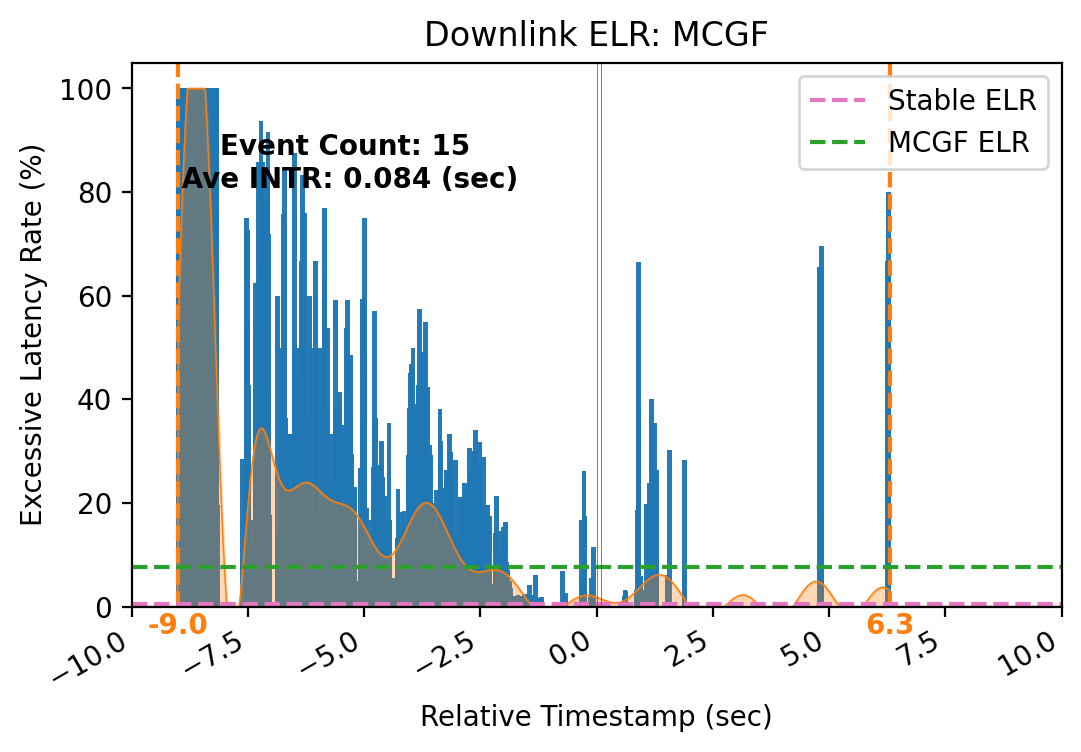

Number of Event: 15
Average Duration: 0.08446086666666665 seconds
[(-1.1, 1.8)]
Uplink Stable ELR: 10.9631
Uplink ELR (-1.1, 1.8) 25.962


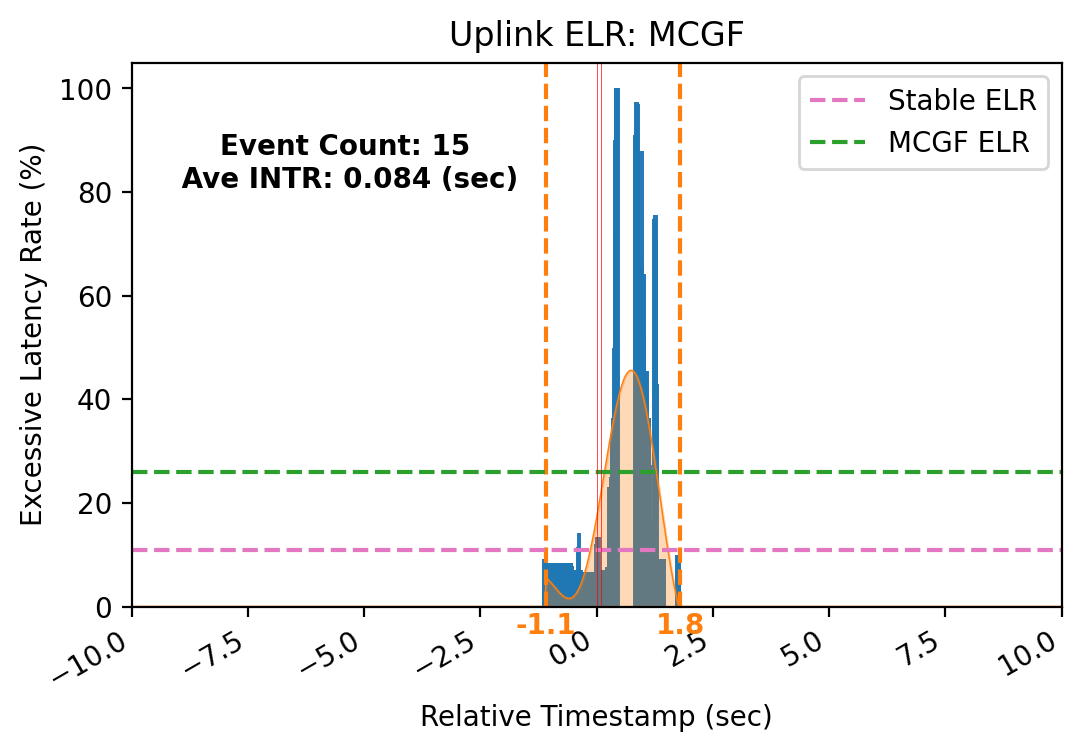

SCGF
Number of Event: 5
Average Duration: 0.0795852 seconds
[(-0.1, 0.8)]
Downlink Stable PLR: 0.0
Downlink PLR (-0.1, 0.8) 7.9


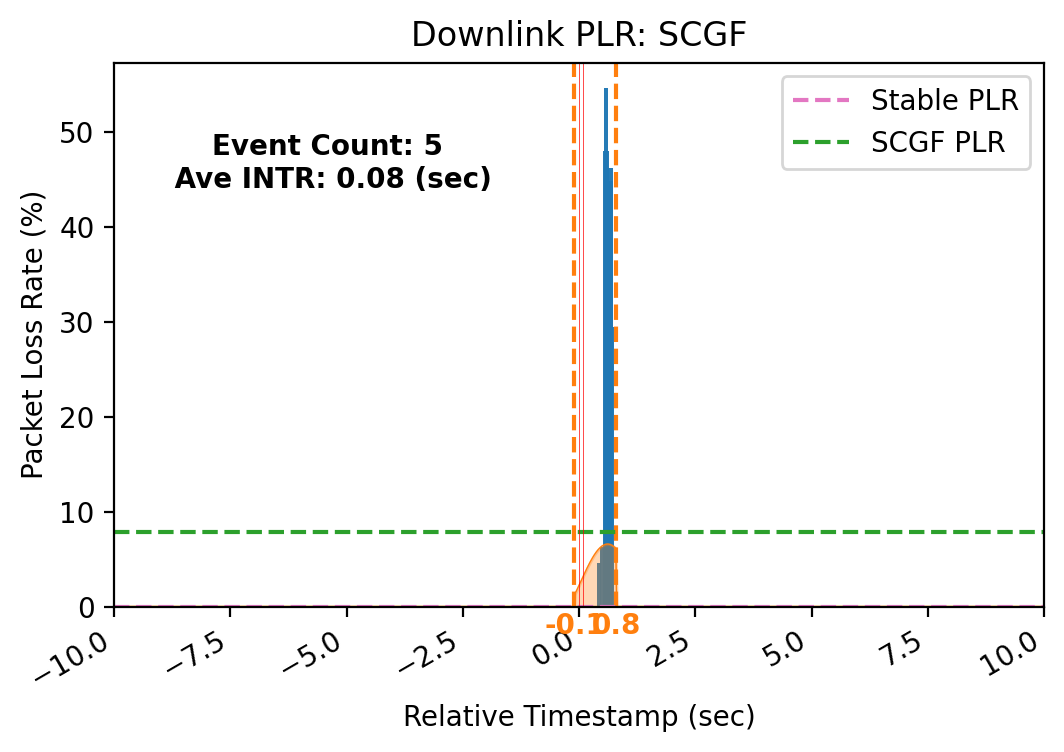

Number of Event: 5
Average Duration: 0.0795852 seconds
[(-0.1, 1.2)]
Uplink Stable PLR: 0.0118
Uplink PLR (-0.1, 1.2) 0.282


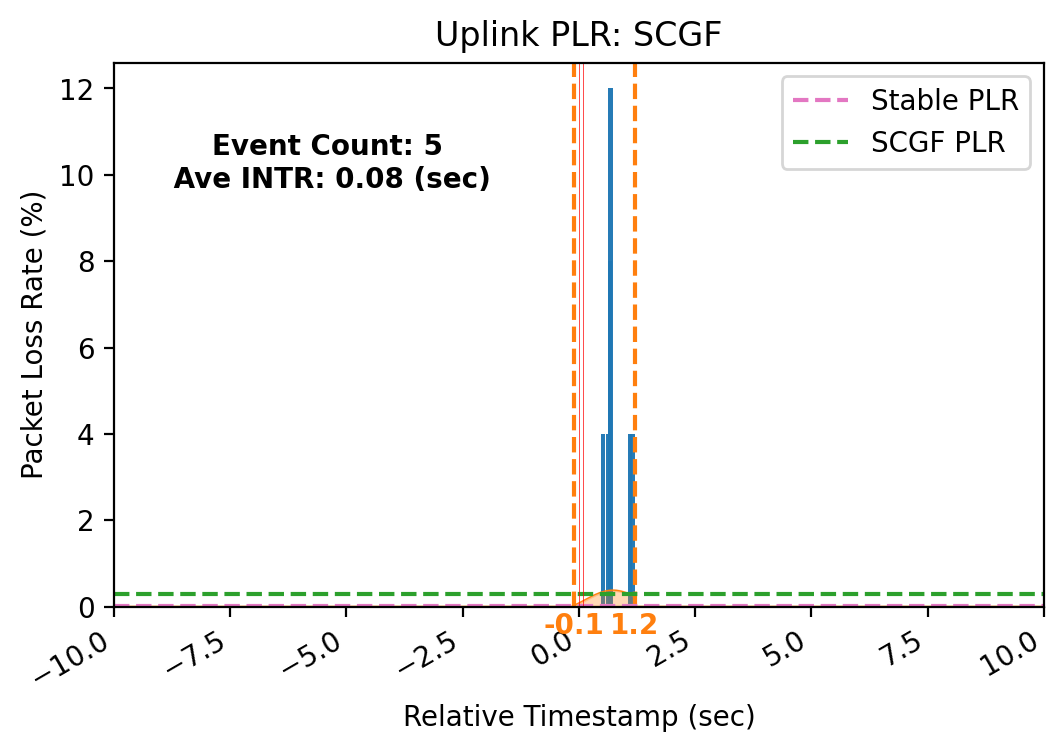

Number of Event: 5
Average Duration: 0.0795852 seconds
[(-0.1, 1.3)]
Downlink Stable ELR: 0.5792
Downlink ELR (-0.1, 1.3) 13.261


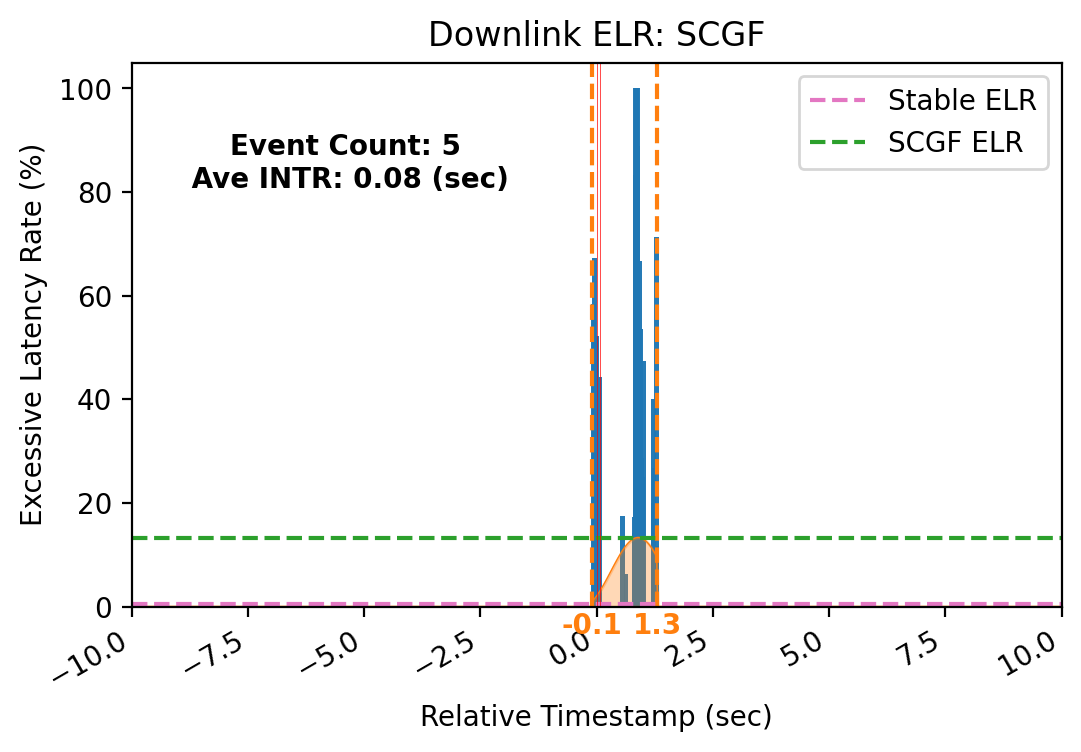

Number of Event: 5
Average Duration: 0.0795852 seconds
[(-0.1, 1.2)]
Uplink Stable ELR: 10.9631
Uplink ELR (-0.1, 1.2) 26.859


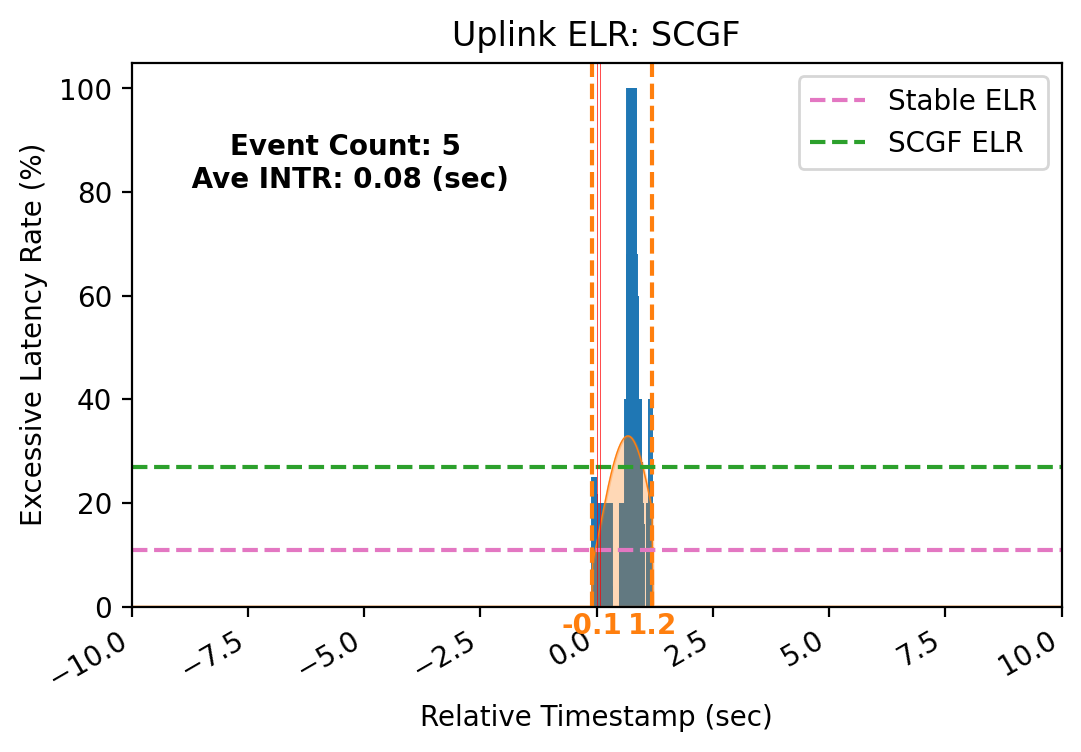

{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-0.1, 0.6),
             'MCGH': (-0.3, 0.8),
             'MNBH': (-0.6, 0.9),
             'SCGM': (-1.0, 0.8),
             'SCGA': (-0.1, 0.9),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-2.8, 0.1),
             'SCGC-II': (-0.1, 1.0),
             'MCGF': (-4.3, 1.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-0.1, 0.8)},
 'ul_lost': {'LTEH': (-0.5, 1.6),
             'ENBH': (-0.1, 2.1),
             'MCGH': (-0.1, 0.8),
             'MNBH': (-0.4, 1.0),
             'SCGM': (-0.9, 0.5),
             'SCGA': (-0.1, 1.2),
             'SCGR-I': (-4.1, 0.4),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-1.4, 0.2),
             'SCGC-II': (-0.1, 1.3),
             'MCGF': (-0.5, 1.2),
             'NASR': (-10.0, 10.0),
             'SCGF': (-0.1, 1.2)},
 'dl_excl': {'LTEH': (-3.5, 0.9),
             'ENBH': (-1.0, 1.4),
             'MCGH': (

In [17]:
# de-comment while not running the first time
D = HOType_D.copy()
E = HOType_E.copy()
scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# *******************************************************************************************

import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

for tag in scope['dl_lost'].keys():
    if len(D[f'dl_lost'][tag]['intrs']) == 0 or len(D[f'ul_lost'][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
        
    for mets in ['lost', 'excl']:
        for mode in ['dl', 'ul']:
            if mets == 'lost':
                stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            elif mets == 'excl':
                stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
                
            table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
            
            print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
            print('Average Duration:', intr, 'seconds')
            
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
            
            if min_scope != 0:
                new_scope[f'{mode}_{mets}'][tag] = min_scope
                
            fig, ax = plt.subplots(figsize=(6, 4))
            
            # # *********************************************************
            # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
            # new_scope[f'{mode}_{mets}'][tag] = min_scope
            # # *********************************************************
            
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
            bound = math.ceil(max(abs(right), abs(left)))
            left = -bound; right = bound
            ax.set_xlim(left, right)
            
            # width = 0.015 * (right- left)
            width = 0.005 * (right- left)
            if mets == 'lost':
                ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
            elif mets == 'excl':
                ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
                
            ax.set_ylim(0, max(1, ax.get_ylim()[1]))
            bottom, top = ax.get_ylim()

            if min_scope != 0:
                ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
                ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
                ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                
                bleft = min_scope[0]
                bright = min_scope[1]
                
                x = np.asarray(table['cat_id'], dtype=np.float64)
                if mets == 'lost':
                    y = np.asarray(table['PLR'], dtype=np.float64)
                elif mets == 'excl':
                    y = np.asarray(table['ELR'], dtype=np.float64)
                    
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', np.RankWarning)
                    z = np.polyfit(x, y, 70)
                    p = np.poly1d(z)
                xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
                
                coef = p.coefficients
                
                if mode == 'dl':
                    if mets == 'lost':
                        coef_dl_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_dl_excl.loc[tag] = [bleft, bright, *list(coef)]
                elif mode == 'ul':
                    if mets == 'lost':
                        coef_ul_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_ul_excl.loc[tag] = [bleft, bright, *list(coef)]
                
                ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
                ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
            
            if mets == 'lost':
                ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
                # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable PLR:', stable_PLR)
                        print('Downlink PLR', min_scope, PLR)
                    elif mode == 'ul':
                        print('Uplink Stable PLR:', stable_PLR)
                        print('Uplink PLR', min_scope, PLR)
                    ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                    # ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
            elif mets == 'excl':
                ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
                # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable ELR:', stable_ELR)
                        print('Downlink ELR', min_scope, ELR)
                    elif mode == 'ul':
                        print('Uplink Stable ELR:', stable_ELR)
                        print('Uplink ELR', min_scope, ELR)
                    ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                    # ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                    
            count = sum(D[f'{mode}_{mets}'][tag]['count'])
            intr = round(intr, 3)
            ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Ave INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
            
            if mode == 'dl':
                if mets == 'lost':
                    ax.set_title(f'Downlink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Downlink ELR: {tag}')
            elif mode == 'ul':
                if mets == 'lost':
                    ax.set_title(f'Uplink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Uplink ELR: {tag}')
            
            if mets == 'lost':
                ax.set_ylabel('Packet Loss Rate (%)')
            elif mets == 'excl':
                ax.set_ylabel('Excessive Latency Rate (%)')
            ax.set_xlabel('Relative Timestamp (sec)')
            ax.legend()
            
            plt.gcf().autofmt_xdate()
            plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
HOType_scope = new_scope.copy()

## Results: Final Scopes & Coefficients

In [18]:
# pprint(Initial_scope, sort_dicts=False)

# pprint(Category_D, sort_dicts=False)
# pprint(Category_E, sort_dicts=False)
pprint(Category_scope, sort_dicts=False)

# pprint(HOType_D, sort_dicts=False)
# pprint(HOType_E, sort_dicts=False)
pprint(HOType_scope, sort_dicts=False)

{'dl_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
 'ul_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
 'dl_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
 'ul_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)}}
{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-0.1, 0.6),
             'MCGH': (-0.3, 0.8),
             'MNBH': (-0.6, 0.9),
             'SCGM': (-1.0, 0.8),
             'SCGA': (-0.1, 0.9),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-2.8, 0.1),
             'SCGC-II': (-0.1, 1.0),
             'MCGF': (-4.3, 1.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-0.1, 0.8)},
 'ul_lost': {'LTEH': (-0.5, 1.6),
             'ENBH': (-0.1, 2.1),
             'MCGH': (-0.1, 0.8),
             'MNBH': (-0.4, 1.0),
             'SCGM': (-0.9, 0.5),
             'SCGA': (-0.1, 1.2),
             'SCGR-I': (-4.1, 0.4),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-1.4, 0.2),
            

In [19]:
coef_dl_lost_sample = coef_dl_lost.copy()
coef_ul_lost_sample = coef_ul_lost.copy()
coef_dl_excl_sample = coef_dl_excl.copy()
coef_ul_excl_sample = coef_ul_excl.copy()

# Evaluation
## Specific profiles

In [20]:
coef_dl_lost = coef_dl_lost_sample.copy()
# coef_dl_lost = coef_dl_lost_sample.copy()
# coef_ul_lost = coef_ul_lost_sample.copy()
# coef_dl_excl = coef_dl_excl_sample.copy()
# coef_ul_excl = coef_ul_excl_sample.copy()

lookup = { t: i for i, t in zip(range(10), ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGC-I', 'SCGC-II', 'MCGF', 'SCGF', ]) }
print(lookup)
display(coef_dl_lost)

stable_dl_plr = 0.0043

{'LTEH': 0, 'ENBH': 1, 'MCGH': 2, 'MNBH': 3, 'SCGM': 4, 'SCGA': 5, 'SCGC-I': 6, 'SCGC-II': 7, 'MCGF': 8, 'SCGF': 9}


lower_bd  upper_bd             0             1             2  \
ENBH         -0.1       0.6 -9.899154e-40 -1.181682e-38  1.088514e-37   
MCGH         -0.3       0.8  1.664236e-38  5.001073e-38 -1.830597e-36   
MNBH         -0.6       0.9  1.252370e-38  3.298492e-38 -1.377323e-36   
SCGM         -1.0       0.8  2.103213e-40  1.601967e-39 -2.307632e-38   
SCGA         -0.1       0.9  2.184114e-39  1.538384e-39 -2.418113e-37   
SCGC-I       -2.8       0.1  1.059288e-37 -9.327621e-37 -1.744879e-36   
SCGC-II      -0.1       1.0  7.474139e-40 -1.349926e-39 -8.288051e-38   
MCGF         -4.3       1.0  7.303468e-60 -2.786344e-58 -2.736004e-57   
SCGF         -0.1       0.8  1.155109e-60 -3.658190e-59 -4.398995e-58   

                    3             4             5             6             7  \
ENBH     1.258616e-36 -3.397512e-36 -3.683994e-35 -1.640384e-35 -2.625529e-34   
MCGH    -5.329712e-36  5.717618e-35  1.561421e-34  2.746247e-34  1.109334e-33   
MNBH    -3.520040e-36  4.300667e-35  1.033840e-34  2.068911e-34  7.266616e-34   
SCGM    -1.701476e-37  7.171652e-37  4.953997e-36  3.568130e-36  3.611101e-35   
SCGA    -1.686660e-37  7.642777e-36  5.215091e-36  3.382520e-35  2.786949e-35   
SCGC-I   9.889172e-36  8.310128e-35  2.885891e-34  1.030699e-34 -5.639852e-33   
SCGC-II  1.383880e-37  2.631716e-36 -3.738714e-36  1.109154e-35 -3.735615e-35   
MCGF     1.180934e-55  2.394275e-55 -1.370207e-53  1.655276e-53 -4.038573e-52   
SCGF     1.558253e-56  4.017163e-56 -1.825354e-54  2.519950e-54 -5.160324e-53   

                    8             9            10            11            12  \
ENBH     1.636605e-33  1.731483e-32  2.506505e-32  3.281174e-31 -5.412604e-31   
MCGH    -2.754795e-32 -7.343150e-32 -4.209096e-31 -1.389355e-30  9.132552e-30   
MNBH    -2.071705e-32 -4.870381e-32 -3.167646e-31 -9.155984e-31  6.863138e-30   
SCGM    -3.447176e-34 -2.319691e-33 -5.360863e-33 -4.457357e-32  1.124299e-31   
SCGA    -3.704867e-33 -2.526575e-33 -5.447418e-32 -4.074405e-32  1.270444e-30   
SCGC-I  -4.329115e-32 -1.960276e-31 -5.064513e-31  6.117280e-31  1.683613e-29   
SCGC-II -1.276478e-33  1.687827e-33 -1.831814e-32  3.995200e-32  4.450970e-31   
MCGF    -1.375416e-51  1.022441e-49 -2.207352e-49  7.909108e-48 -4.112126e-48   
SCGF    -2.428657e-52  1.370512e-50 -3.493940e-50  1.033574e-48 -3.785822e-49   

                   13            14            15            16            17  \
ENBH    -4.614981e-30 -2.372506e-29 -2.717176e-28 -1.465434e-28 -2.756236e-27   
MCGH     1.961097e-29  3.990568e-28  1.152492e-27  2.444224e-27  1.167036e-26   
MNBH     1.313121e-29  3.001305e-28  7.634213e-28  1.841979e-27  7.632400e-27   
SCGM     6.051515e-31  5.019802e-30  3.651054e-29  3.251737e-29  3.808498e-28   
SCGA     8.129676e-31  5.314432e-29  3.788235e-29  2.873334e-28  2.650977e-28   
SCGC-I   1.213589e-28  5.873571e-28  1.908383e-27  1.615971e-27 -3.303549e-26   
SCGC-II -3.034820e-31  1.812712e-29 -2.872144e-29  8.957849e-29 -4.152354e-28   
MCGF    -4.208270e-46  1.675683e-45 -1.028366e-43  1.930507e-43 -4.351920e-42   
SCGF    -5.859146e-47  2.870561e-46 -1.369944e-44  2.951116e-44 -5.516859e-43   

                   18            19            20            21            22  \
ENBH     1.101913e-26  1.032614e-25  3.257945e-25  3.954235e-24  4.437254e-25   
MCGH    -1.858269e-25 -4.388102e-25 -5.476082e-24 -1.678152e-23 -7.007622e-24   
MNBH    -1.396633e-25 -2.932079e-25 -4.118415e-24 -1.111343e-23 -5.331965e-24   
SCGM    -2.296088e-27 -1.360847e-26 -6.916362e-26 -5.317215e-25 -1.250631e-25   
SCGA    -2.565472e-26 -1.719151e-26 -7.247593e-25 -5.358337e-25 -1.867183e-25   
SCGC-I  -3.149416e-25 -1.843570e-24 -7.728688e-24 -2.021193e-23  2.358308e-23   
SCGC-II -8.926867e-27  8.118587e-27 -2.451164e-25  4.357637e-25  1.116183e-25   
MCGF     2.702339e-42  6.053475e-40 -1.603636e-39  9.562466e-38 -1.890390e-37   
SCGF     9.386668e-44  8.338889e-41 -2.749790e-40  1.270594e-38 -2.842149e-38   

                   23            2

In [21]:
data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown"
devices = ['sm01', 'sm02']
trips = ['#01',]

filepaths = []
for tr in trips:
    for dev in devices:
        filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
    break

filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_uplk_loss_latency.csv']]

In [22]:
len('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/')

83

sm01 sm02
eval_value | ground_truth
0.08656139615701264 | 0.1549921657350911


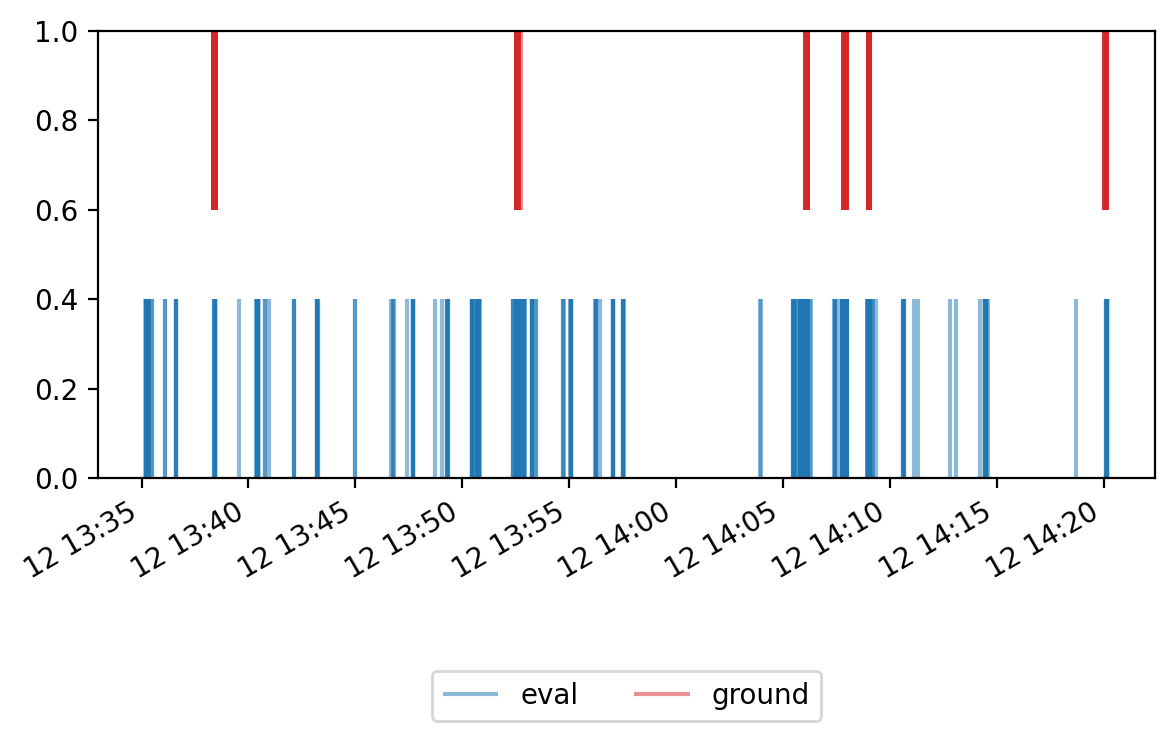

[array(['2023-09-12T13:34:16.252557443', '2023-09-12T13:34:16.258123443',
        '2023-09-12T13:34:16.258123443', ...,
        '2023-09-12T14:21:31.354077443', '2023-09-12T14:21:31.354077443',
        '2023-09-12T14:21:31.354077443'], dtype='datetime64[ns]'),
 array(['2023-09-12T13:34:16.252996578', '2023-09-12T13:34:16.258282578',
        '2023-09-12T13:34:16.258282578', ...,
        '2023-09-12T14:21:31.354246578', '2023-09-12T14:21:31.360234578',
        '2023-09-12T14:21:31.360234578'], dtype='datetime64[ns]'),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [29]:
x1x2_yg1yg2yg_y1y2y_specific1 = []
# for s in list(it.combinations(filepaths, 2))[:1]:
for s in list(it.combinations(filepaths, 2)):
    # print(s[0][0][77:81], s[1][0][77:81])
    print(s[0][0][83:87], s[1][0][83:87])
    
    ho_df1 = pd.read_csv(s[0][0], parse_dates=['start'])[['type', 'start']]
    dl_df1 = pd.read_csv(s[0][1], parse_dates=['xmit_time', 'arr_time'])[['seq', 'lost', 'excl', 'xmit_time', 'arr_time']]
    ho_df2 = pd.read_csv(s[1][0], parse_dates=['start'])[['type', 'start']]
    dl_df2 = pd.read_csv(s[1][1], parse_dates=['xmit_time', 'arr_time'])[['seq', 'lost', 'excl', 'xmit_time', 'arr_time']]
    
    df = pd.merge(dl_df1, dl_df2, on='seq', how='outer')
    # display(df)
    
    splr_ground_truth = (df['lost_x'] & df['lost_y']).mean() * 100
    
    X1 = df['arr_time_x'].to_numpy()
    X2 = df['arr_time_y'].to_numpy()
    
    x1x2_yg1yg2yg_y1y2y_specific1.append(X1)
    x1x2_yg1yg2yg_y1y2y_specific1.append(X2)
    x1x2_yg1yg2yg_y1y2y_specific1.append(df['lost_x'].to_numpy())
    x1x2_yg1yg2yg_y1y2y_specific1.append(df['lost_y'].to_numpy())
    x1x2_yg1yg2yg_y1y2y_specific1.append((df['lost_x'] & df['lost_y']).to_numpy())
    
    C1 = ho_df1['start'].to_numpy()
    C2 = ho_df2['start'].to_numpy()
    T1 = ho_df1['type'].to_numpy()
    T2 = ho_df2['type'].to_numpy()
    
    Z1 = [(X1 - c) / np.timedelta64(1, 's') for c in C1]
    Z2 = [(X2 - c) / np.timedelta64(1, 's') for c in C2]
    
    Yp1 = []
    for i in range(len(C1)):
        # print(i, T1[i])
        if T1[i] not in coef_dl_lost.index.to_list():
            y = np.zeros(len(Z1))
            continue
        y = poly_approx(coef_dl_lost.copy(), Z1[i], T1[i])
        Yp1.append(y)
    
    Yp2 = []   
    for i in range(len(C2)):
        # print(i, T2[i])
        if T2[i] not in coef_dl_lost.index.to_list():
            y = np.zeros(len(Z2))
            continue
        y = poly_approx(coef_dl_lost.copy(), Z2[i], T2[i])
        Yp2.append(y)
    
    Y1 = [sum(s)/100 for s in zip(*Yp1)]
    Y2 = [sum(s)/100 for s in zip(*Yp2)]
    
    # Y1 = [s if s > stable_dl_plr else stable_dl_plr for s in Y1]
    # Y2 = [s if s > stable_dl_plr else stable_dl_plr for s in Y2]
    # Y = [y1*y2 for y1, y2 in zip(Y1, Y2)]
    
    random.seed(2023)
    Y1 = np.array([generate_random_boolean(s) for s in Y1])
    Y2 = np.array([generate_random_boolean(s) for s in Y2])
    # inst = [generate_random_boolean(s) for s in Y]
    Y = np.logical_and(Y1, Y2)
    
    x1x2_yg1yg2yg_y1y2y_specific1.append(Y1)
    x1x2_yg1yg2yg_y1y2y_specific1.append(Y2)
    x1x2_yg1yg2yg_y1y2y_specific1.append(Y)
    
    splr = sum(Y)/len(Y) * 100
    # splr = sum(inst)/len(inst) * 100
    
    print('eval_value', '|', 'ground_truth')
    print(splr, '|', splr_ground_truth)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    x1 = [ts for ts, bo in zip(X1, Y) if bo]
    ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
    x2 = [ts for ts, bo in zip(X1, (df['lost_x'] & df['lost_y']).to_numpy()) if bo]
    ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
    ax.set_ylim(0, 1)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

x1x2_yg1yg2yg_y1y2y_specific1

## Another

In [30]:
# data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/UDP_Bandlock_All_RM500Q"
# devices = ['qc00', 'qc02', 'qc03']
# trips = ['#01', '#02', '#03', '#04']

# filepaths = []
# for tr in trips:
#     for dev in devices:
#         filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
#             os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
#     break

# filepaths

data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown"
devices = ['sm02',]
trips = ['#01',]

filepaths = []
for tr in trips:
    for dev in devices:
        filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
    break

filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_uplk_loss_latency.csv']]

In [31]:
Category_scope = {
    'dl_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'ul_lost': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'dl_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)},
    'ul_excl': {'HO': (-5.0, 5.0), 'RLF': (-10.0, 10.0)}
}

In [32]:
columns = ['stage', 'category', 'crossover', 'type', 'cause', 'index', 'inter-eNB', 'inter-Freq', 'band_cng']
sp_col = 'type'
lookup = {
    'LTEH': 'HO',
    'ENBH': 'HO',
    'MCGH': 'HO',
    'MNBH': 'HO',
    'SCGM': 'HO',
    'SCGA': 'HO',
    'SCGR-I': 'HO',
    'SCGR-II': 'HO',
    'SCGC-I': 'HO',
    'SCGC-II': 'HO',
    'MCGF': 'RLF',
    'NASR': 'RLF',
    'SCGF': 'RLF',
}

scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

pprint(scope, sort_dicts=False)

{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-10.0, 10.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-10.0, 10.0)},
 'ul_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             'MCGH': (-5.0, 5.0),
             'MNBH': (-5.0, 5.0),
             'SCGM': (-5.0, 5.0),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-5.0, 5.0),
             'MCGF': (-10.0, 10.0),
             'NASR': (-10.0, 10.0),
             'SCGF': (-10.0, 10.0)},
 'dl_excl': {'LTEH': (-5.0, 5.0),
             'ENBH': (-5.0, 5.0),
             '

In [33]:
D = {mm: {tag: {'tables': [], 'intrs': [], 'count': []} for tag in scope[mm].keys()} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}
E = {mm: {'stable_miss': [], 'stable_pkt': [], 'stable_duration': [], 'total_duration': []} for mm in ['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']}

N = len(filepaths)
for i, (ho_filepath, dl_filepath, ul_filepath) in enumerate(filepaths):
    print(f'{i}/{N}', ho_filepath); print(f'{i}/{N}', dl_filepath); print(f'{i}/{N}', ul_filepath)
    df_ho = pd.read_csv(ho_filepath, parse_dates=['start', 'end'])
    df_dl = set_data(pd.read_csv(dl_filepath))
    df_ul = set_data(pd.read_csv(ul_filepath))
    
    for mode, df in zip(['dl', 'ul'], [df_dl, df_ul]):
        for mets in ['lost', 'excl']:
            A, stable_miss, stable_pkt, stable_miss_rate, stable_duration, total_duration, stable_proportion  = \
                setup_profile(df=df, df_ho=df_ho, mode=mode, mets=mets, sp_col=sp_col, scope=scope[f'{mode}_{mets}'])
            
            # Merge instances for each event's profile in a trace
            for tag in scope[f'{mode}_{mets}'].keys():
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'], mets=mets)
                D[f'{mode}_{mets}'][tag]['tables'].append(table)
                D[f'{mode}_{mets}'][tag]['intrs'] = [*D[f'{mode}_{mets}'][tag]['intrs'], *A[tag]['intrs']]
                D[f'{mode}_{mets}'][tag]['count'].append(len(A[tag]['tables']))
                
                E[f'{mode}_{mets}']['stable_miss'].append(stable_miss)
                E[f'{mode}_{mets}']['stable_pkt'].append(stable_pkt)
                E[f'{mode}_{mets}']['stable_duration'].append(stable_duration)
                E[f'{mode}_{mets}']['total_duration'].append(total_duration)
    # if i > 5:     
    #     break

HOType_D = D.copy()
HOType_E = E.copy()

0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv
0/1 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_uplk_loss_latency.csv
Overlapping event occurs!!
197 2023-09-12 14:05:53.590864 2023-09-12 14:05:54.097161 MCGH nan
198 2023-09-12 14:05:53.978330 2023-09-12 14:05:54.056682 MCGF handoverFailure (1)
Overlapping event occurs!!
197 2023-09-12 14:05:53.590864 2023-09-12 14:05:54.097161 MCGH nan
198 2023-09-12 14:05:53.978330 2023-09-12 14:05:54.056682 MCGF handoverFailure (1)
Overlapping event occurs!!
197 2023-09-12 14:05:53.590864 2023-09-12 14:05:54.097161 MCGH nan
198 2023-09-12 14:05:53.978330 2023-09-12 14:05:54.056682 MCGF handoverFailure (1)
Overlapping event occurs!!
197 2023-09-12 14:05:53.590864 2023-09-12 14:05:54.097161 MCGH na

LTEH
Number of Event: 9
Average Duration: 0.015662444444444444 seconds


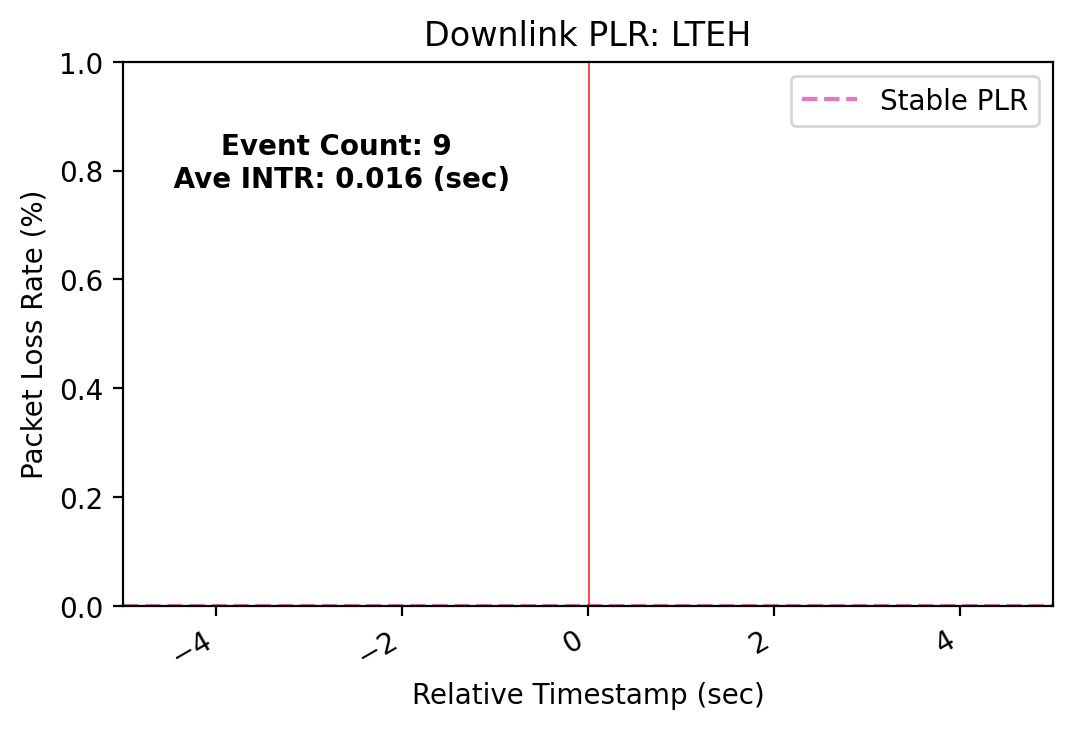

Number of Event: 9
Average Duration: 0.015662444444444444 seconds
[(-0.1, 1.0)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.1, 1.0) 0.847


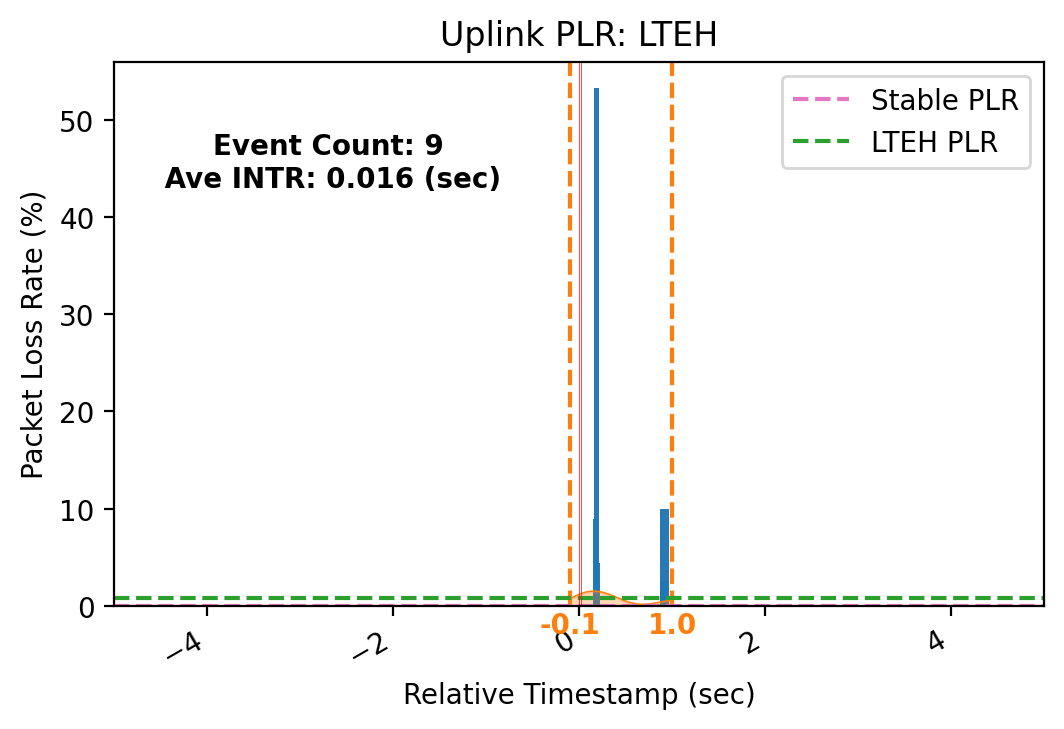

Number of Event: 9
Average Duration: 0.015662444444444444 seconds
[(-3.7, 0.4)]
Downlink Stable ELR: 0.9078
Downlink ELR (-3.7, 0.4) 0.217


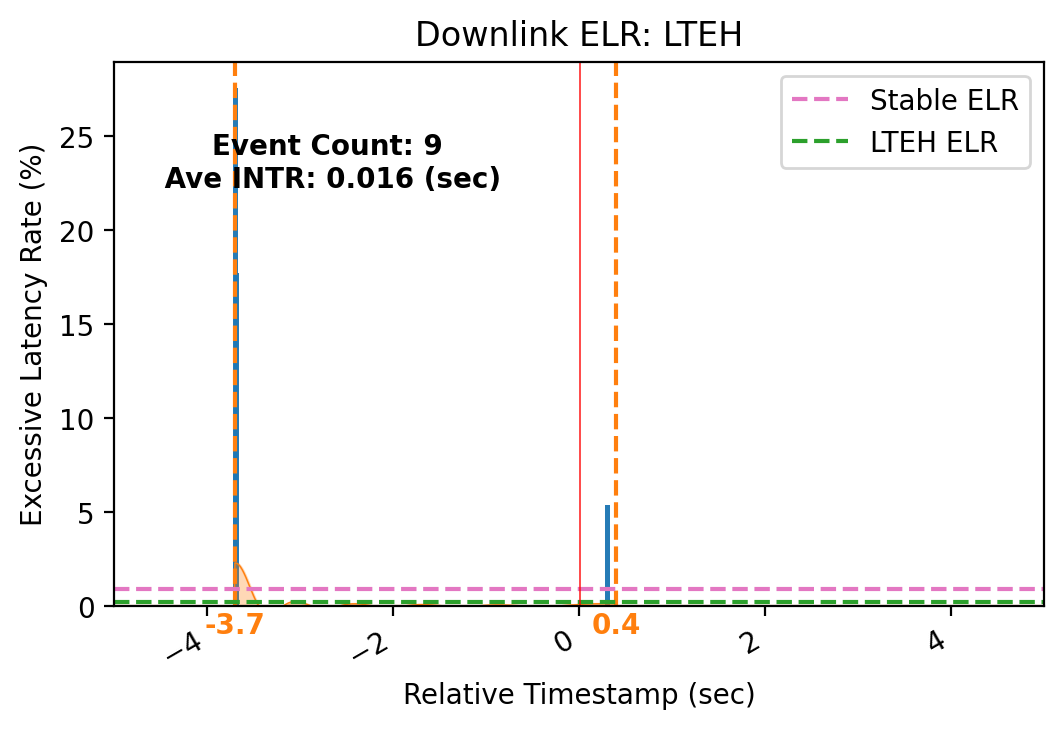

Number of Event: 9
Average Duration: 0.015662444444444444 seconds
[(-0.1, 0.3)]
Uplink Stable ELR: 2.283
Uplink ELR (-0.1, 0.3) 1.944


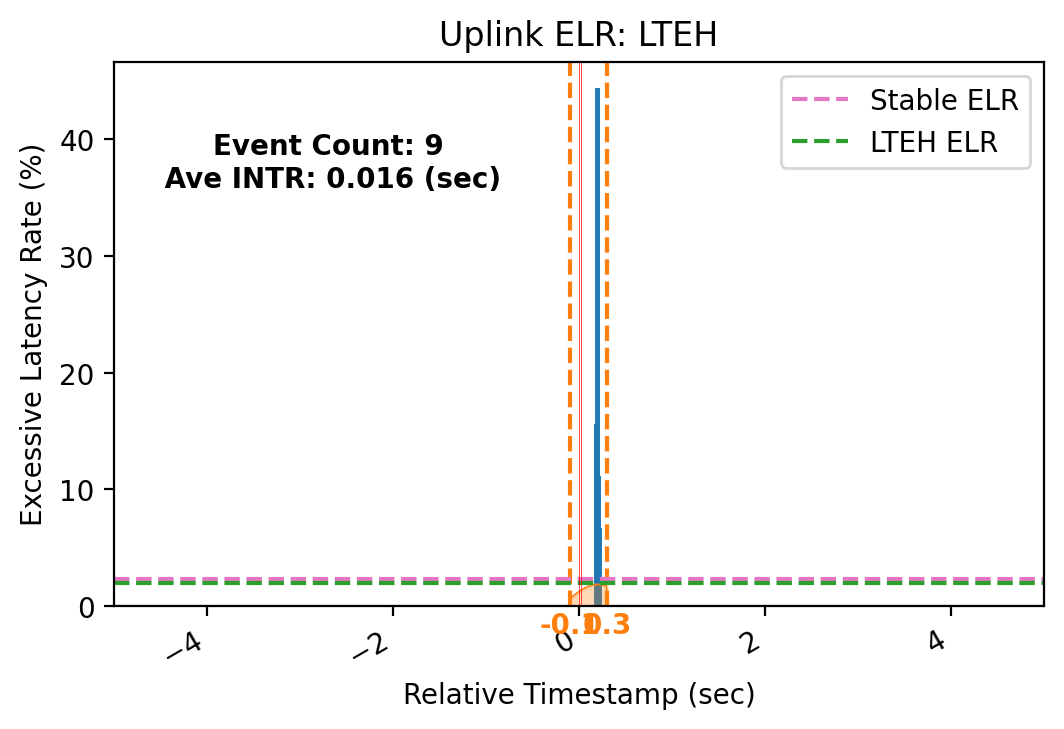

ENBH
Number of Event: 45
Average Duration: 0.016302466666666668 seconds
[(-2.7, 0.3)]
Downlink Stable PLR: 0.0002
Downlink PLR (-2.7, 0.3) 2.243


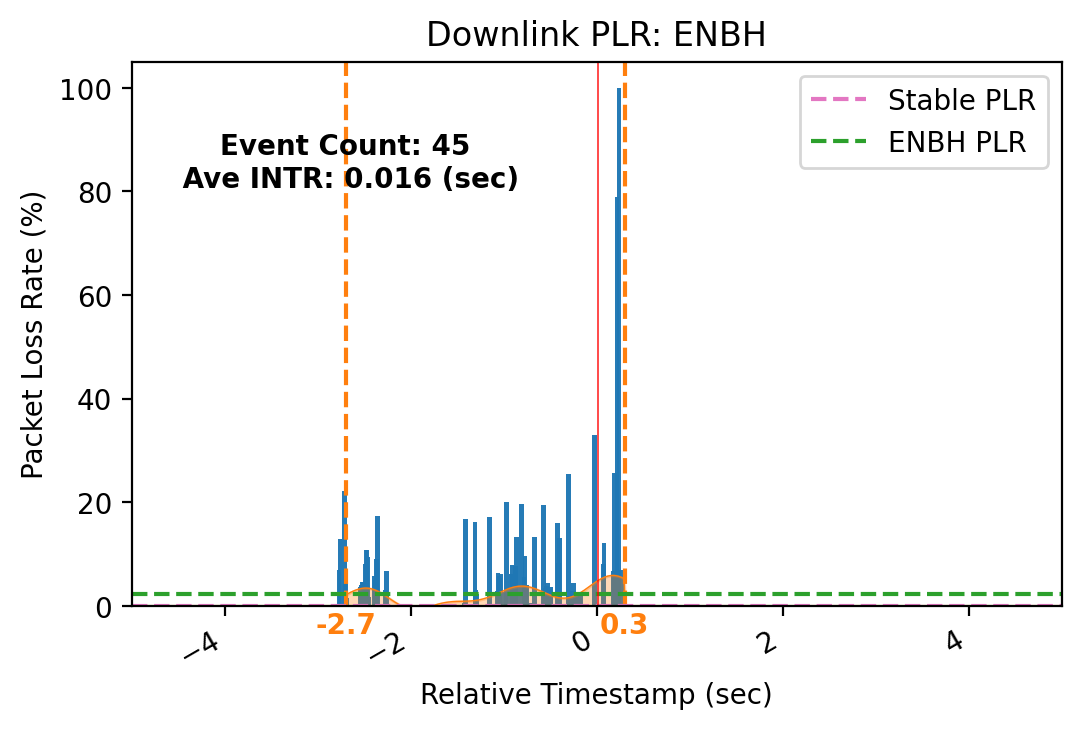

Number of Event: 45
Average Duration: 0.016302466666666668 seconds
[(-2.0, 0.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-2.0, 0.2) 1.521


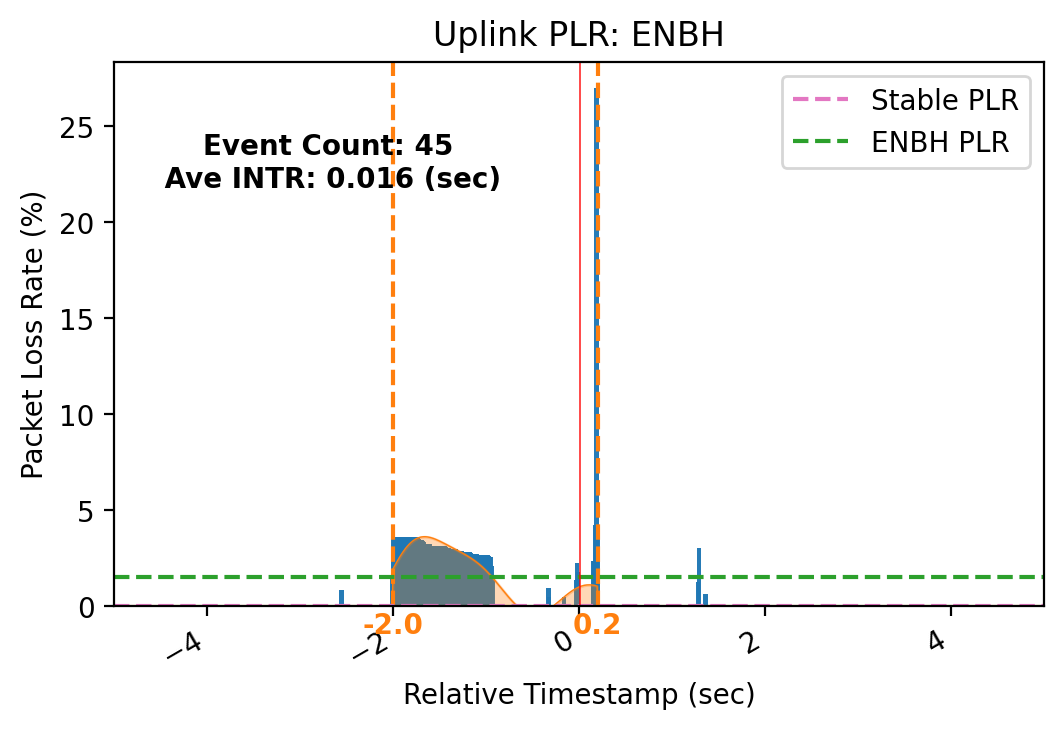

Number of Event: 45
Average Duration: 0.016302466666666668 seconds
[(-5.0, 3.7)]
Downlink Stable ELR: 0.9078
Downlink ELR (-5.0, 3.7) 4.265


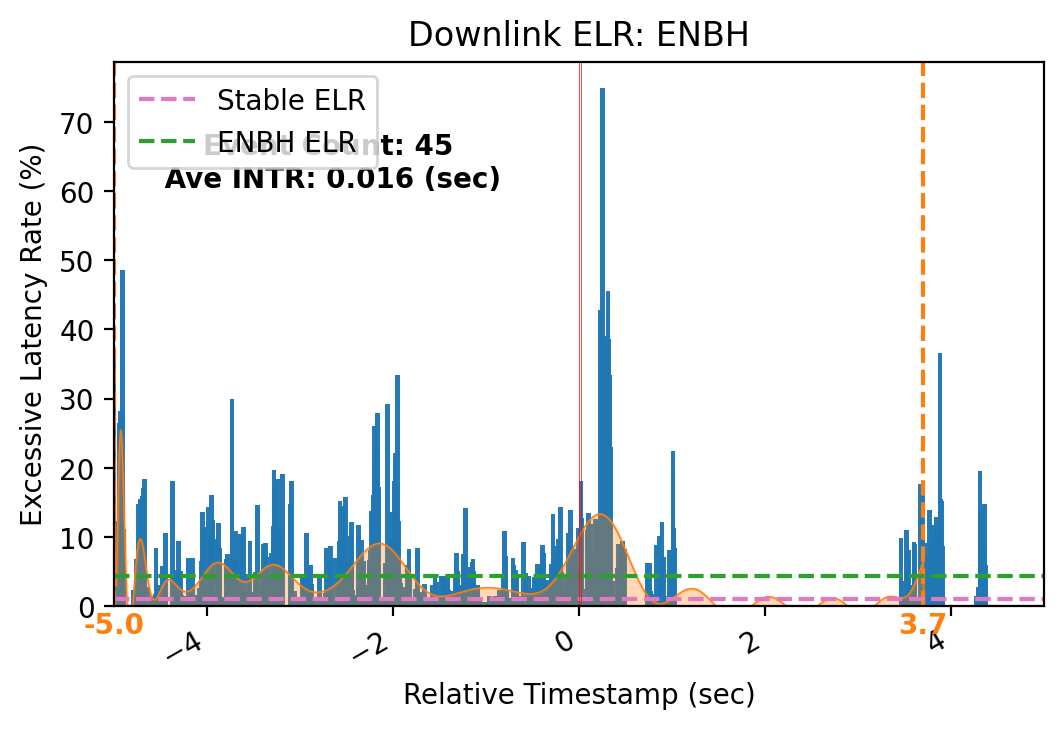

Number of Event: 45
Average Duration: 0.016302466666666668 seconds
[(-5.0, 3.3), (-4.9, 3.4), (-4.8, 3.5), (-4.7, 3.6), (-4.5, 3.8)]
Uplink Stable ELR: 2.283
Uplink ELR (-5.0, 3.3) 5.57


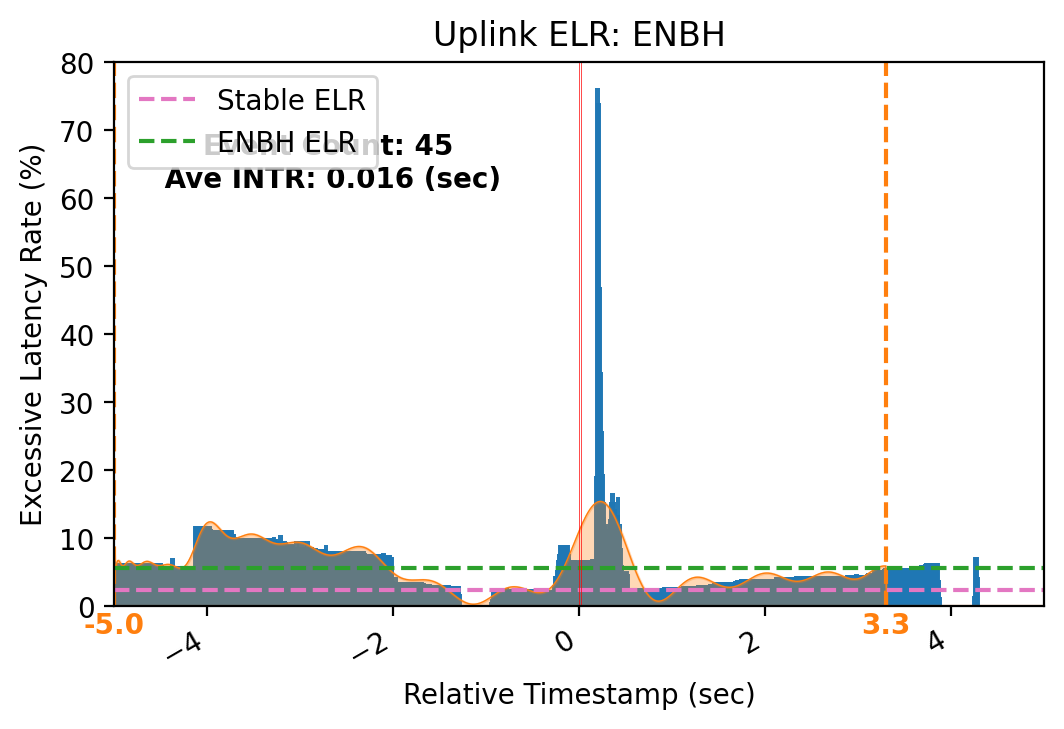

MCGH
Number of Event: 29
Average Duration: 0.016671896551724137 seconds
[(-0.2, 0.3)]
Downlink Stable PLR: 0.0002
Downlink PLR (-0.2, 0.3) 3.614


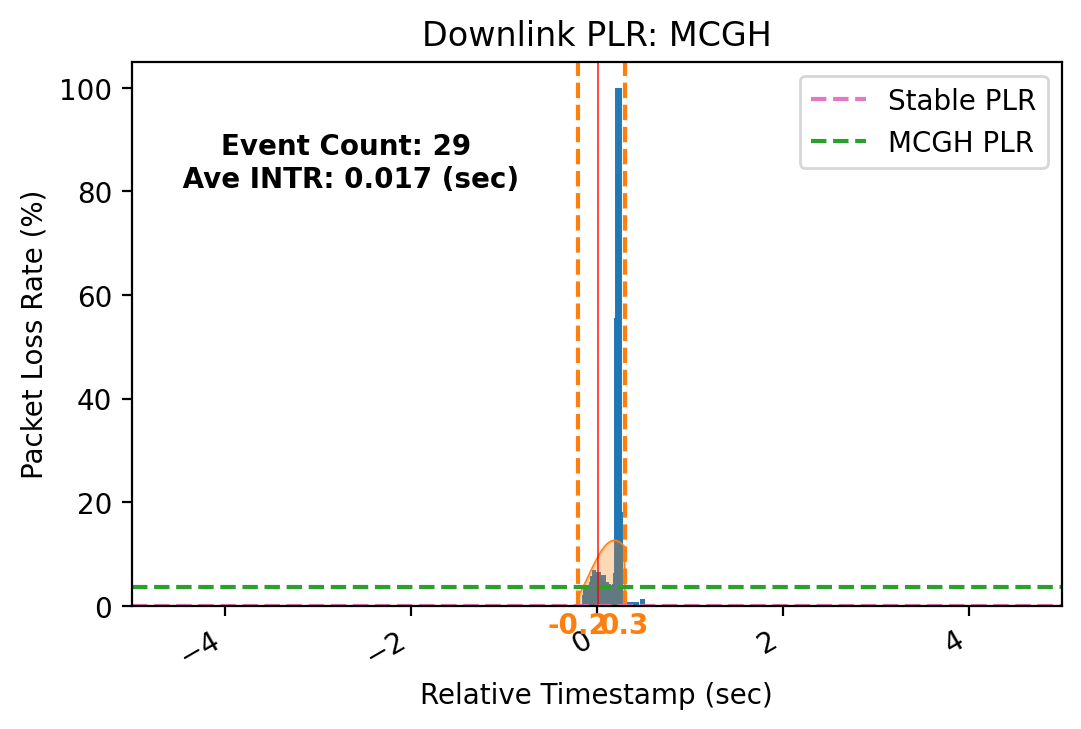

Number of Event: 29
Average Duration: 0.016671896551724137 seconds
[(-0.1, 0.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.1, 0.2) 0.748


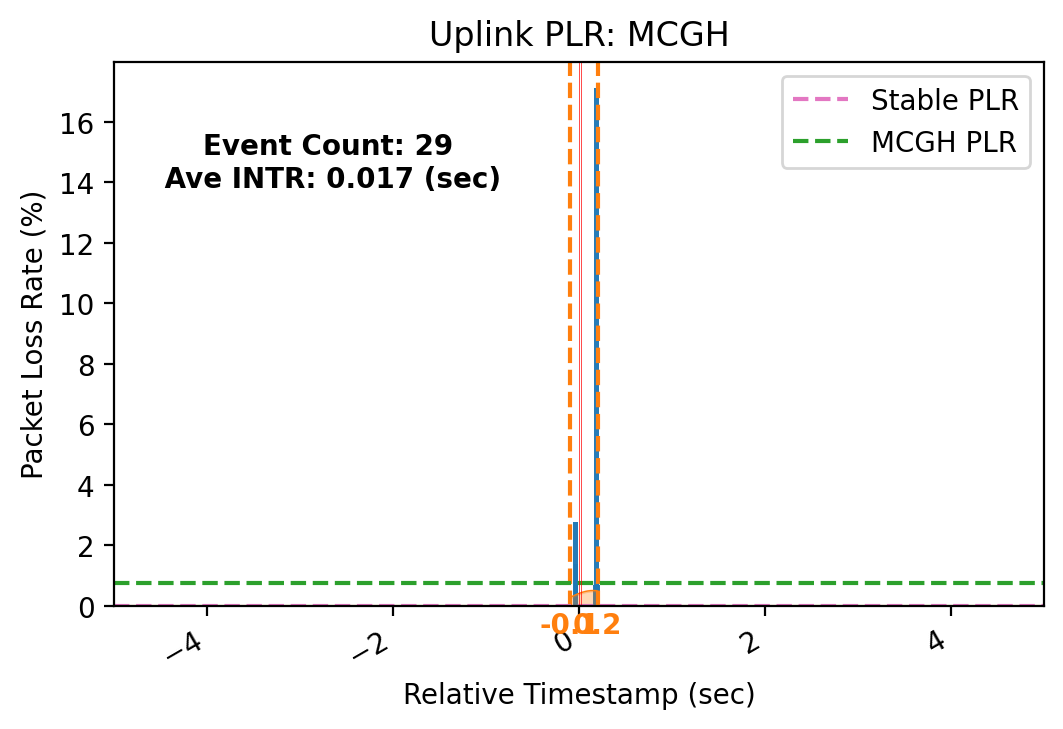

Number of Event: 29
Average Duration: 0.016671896551724137 seconds
[(-0.2, 0.7)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.2, 0.7) 4.317


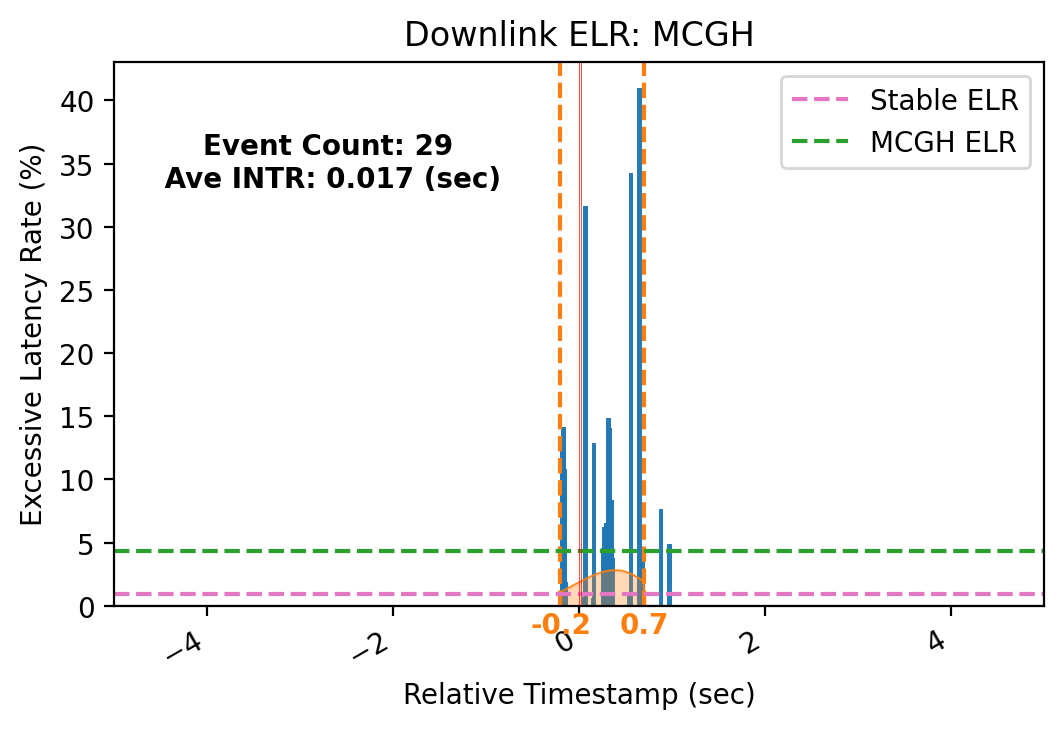

Number of Event: 29
Average Duration: 0.016671896551724137 seconds
[(-0.1, 0.3)]
Uplink Stable ELR: 2.283
Uplink ELR (-0.1, 0.3) 3.841


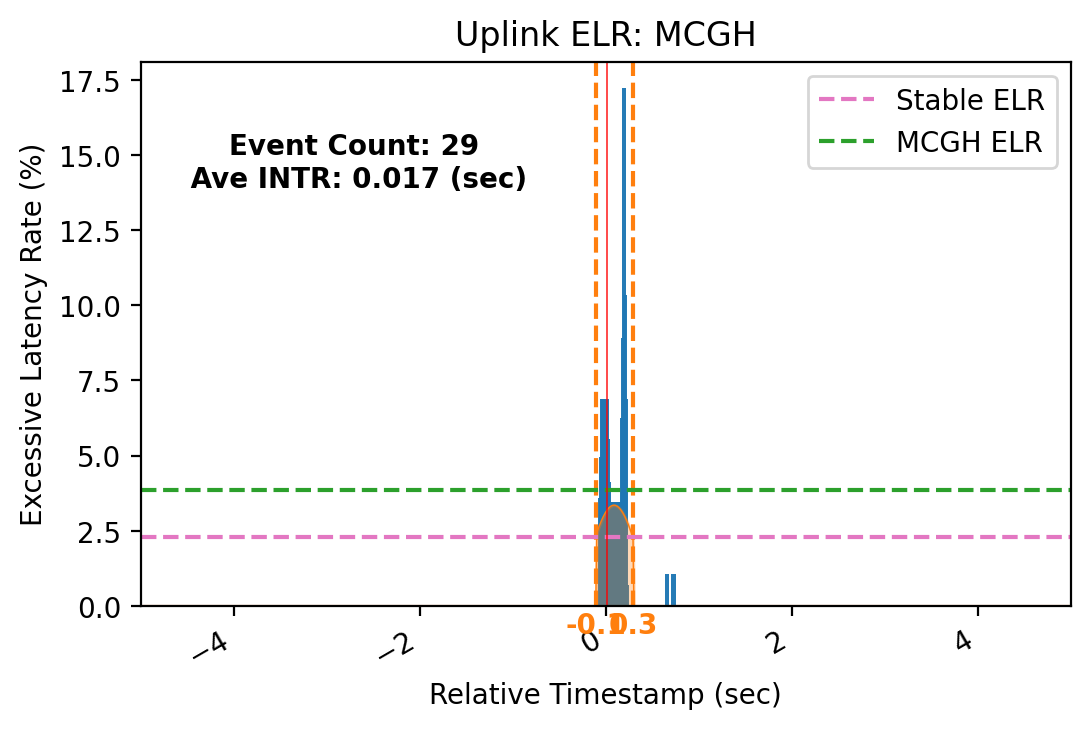

MNBH
Number of Event: 82
Average Duration: 0.02090812195121951 seconds
[(-0.9, 0.3)]
Downlink Stable PLR: 0.0002
Downlink PLR (-0.9, 0.3) 3.815


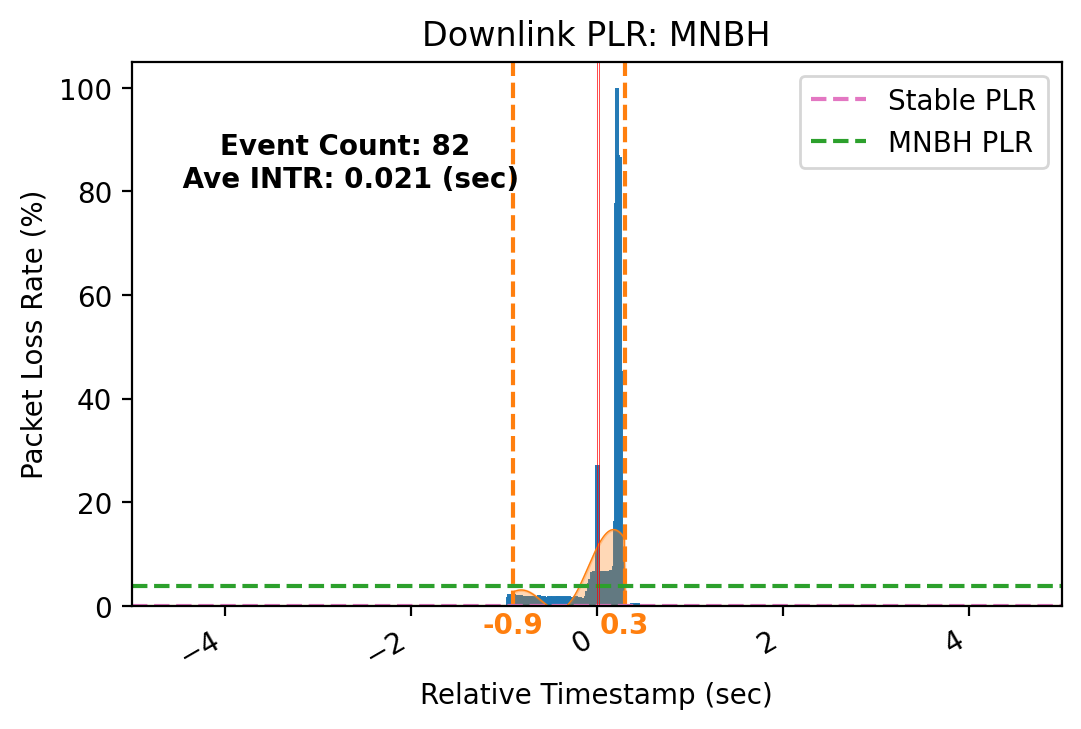

Number of Event: 82
Average Duration: 0.02090812195121951 seconds
[(-0.2, 0.3)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.2, 0.3) 0.674


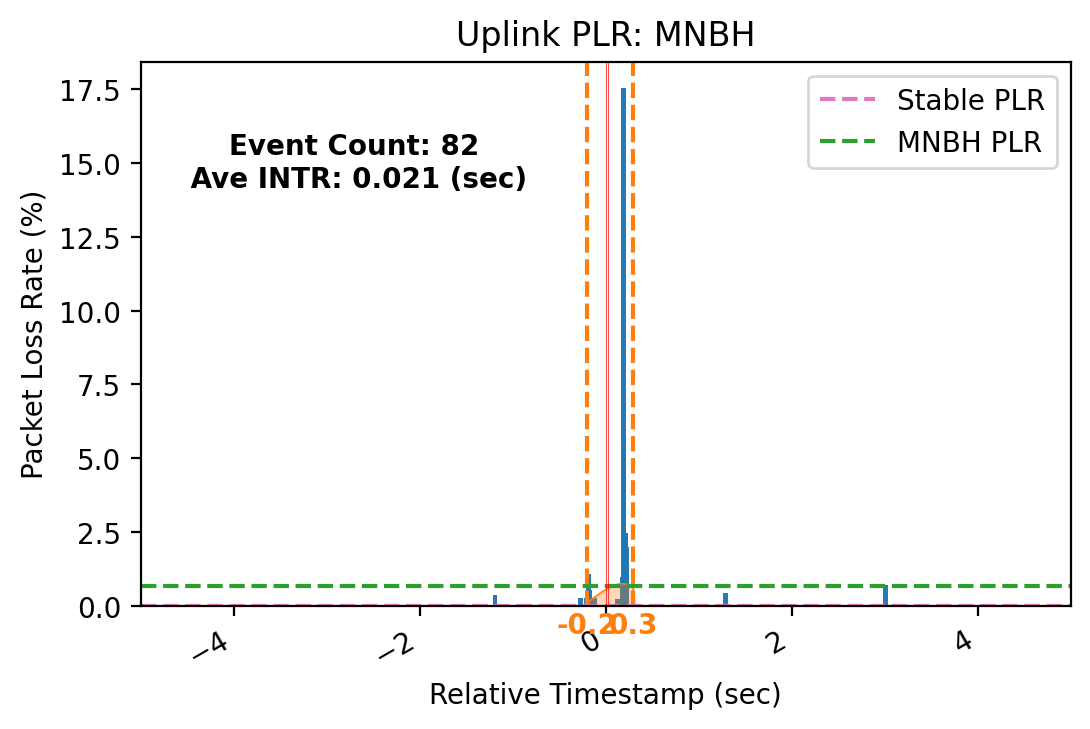

Number of Event: 82
Average Duration: 0.02090812195121951 seconds
[(-0.3, 0.5), (-0.2, 0.6)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.3, 0.5) 4.443


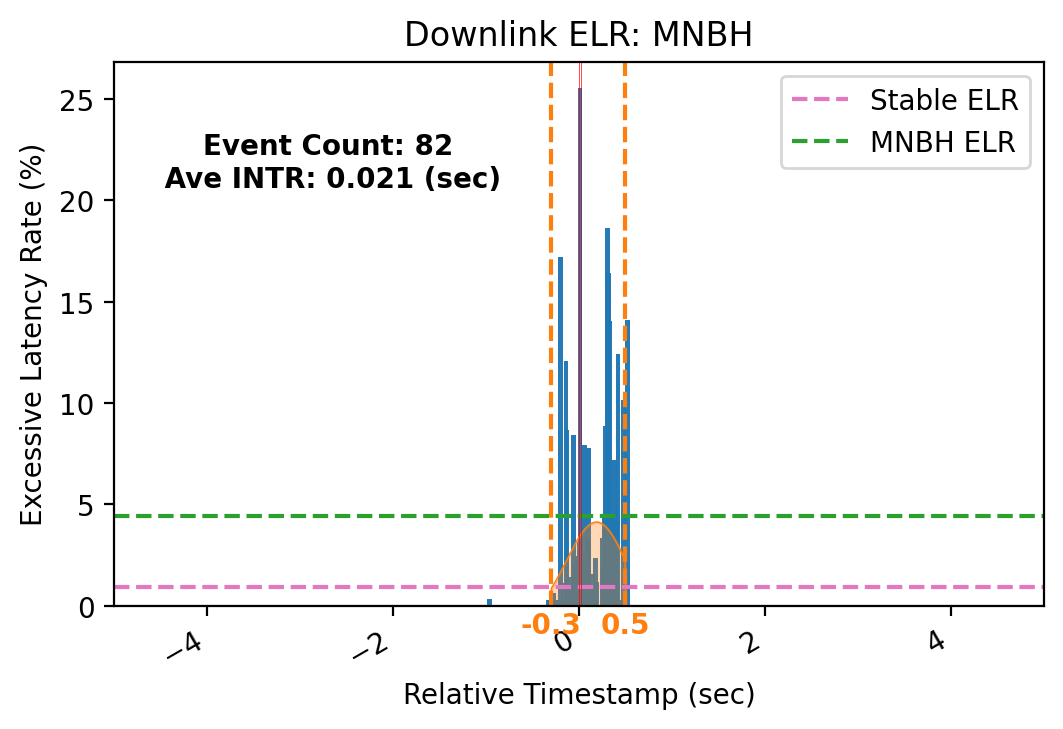

Number of Event: 82
Average Duration: 0.02090812195121951 seconds
[(-5.0, 4.2), (-4.9, 4.3)]
Uplink Stable ELR: 2.283
Uplink ELR (-5.0, 4.2) 9.449


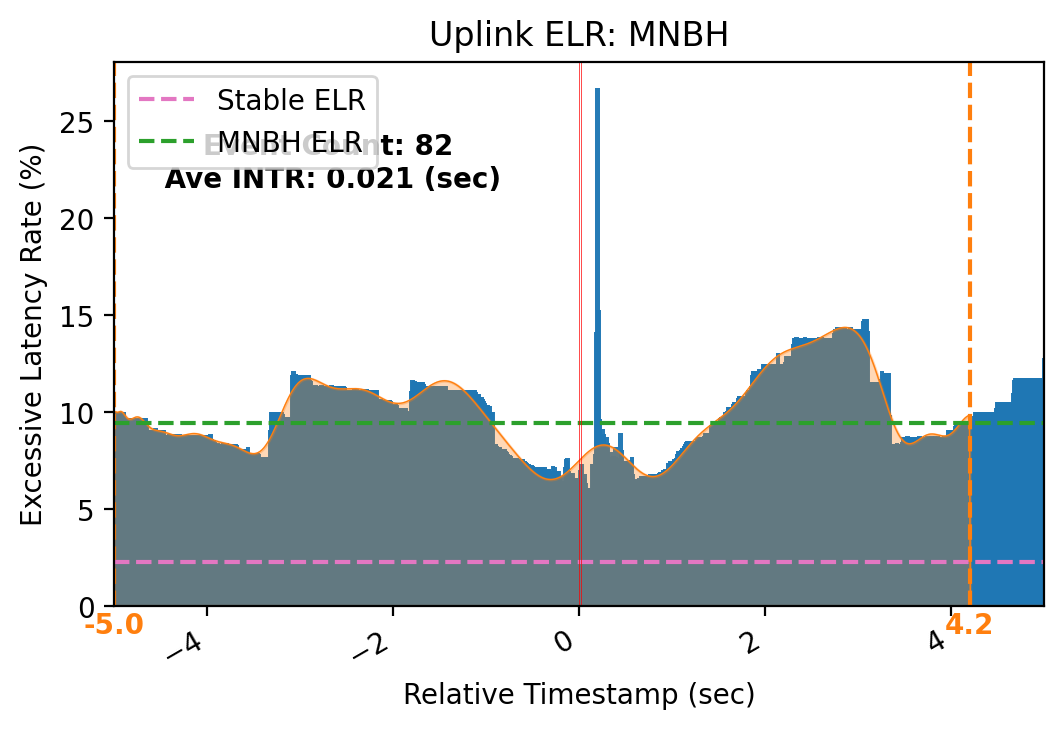

SCGM
Number of Event: 99
Average Duration: 0.01702309090909091 seconds
[(-0.8, 0.3)]
Downlink Stable PLR: 0.0002
Downlink PLR (-0.8, 0.3) 0.528


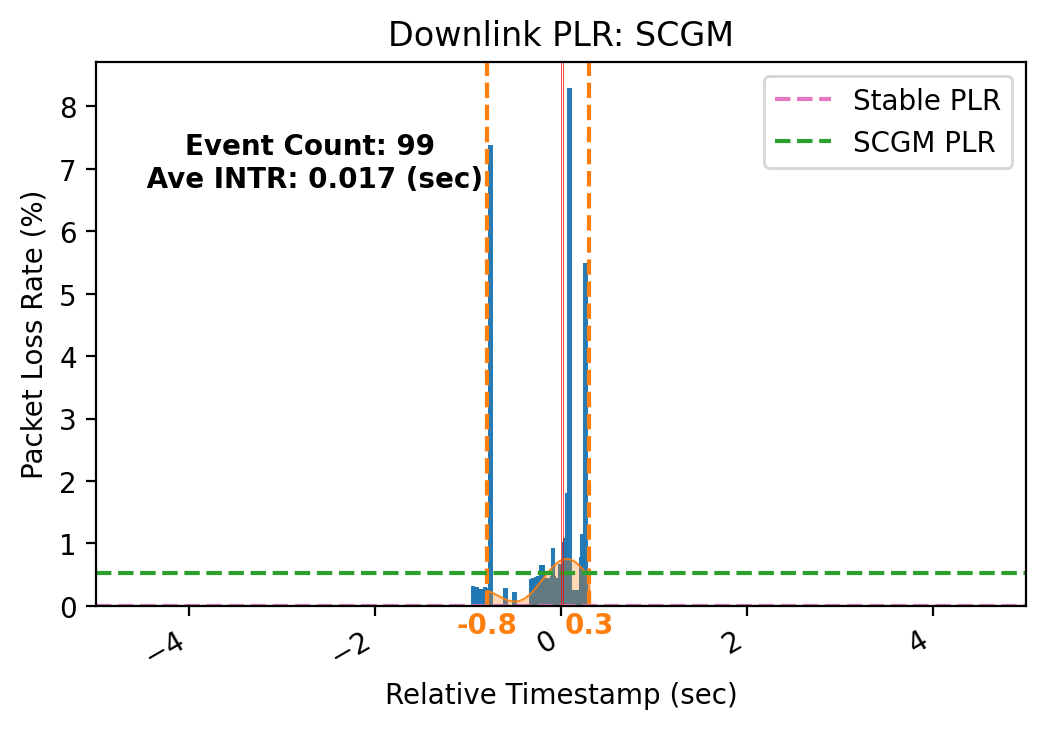

Number of Event: 99
Average Duration: 0.01702309090909091 seconds
[(-0.6, 0.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.6, 0.2) 0.199


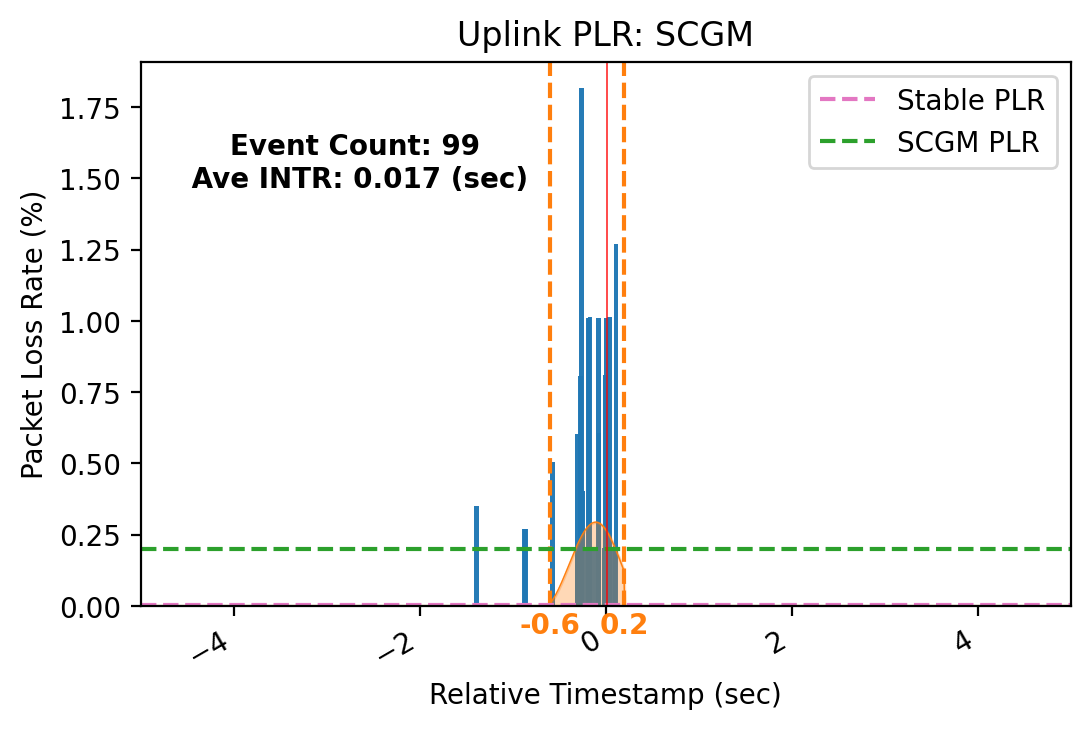

Number of Event: 99
Average Duration: 0.01702309090909091 seconds
[(-0.7, 0.3)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.7, 0.3) 2.773


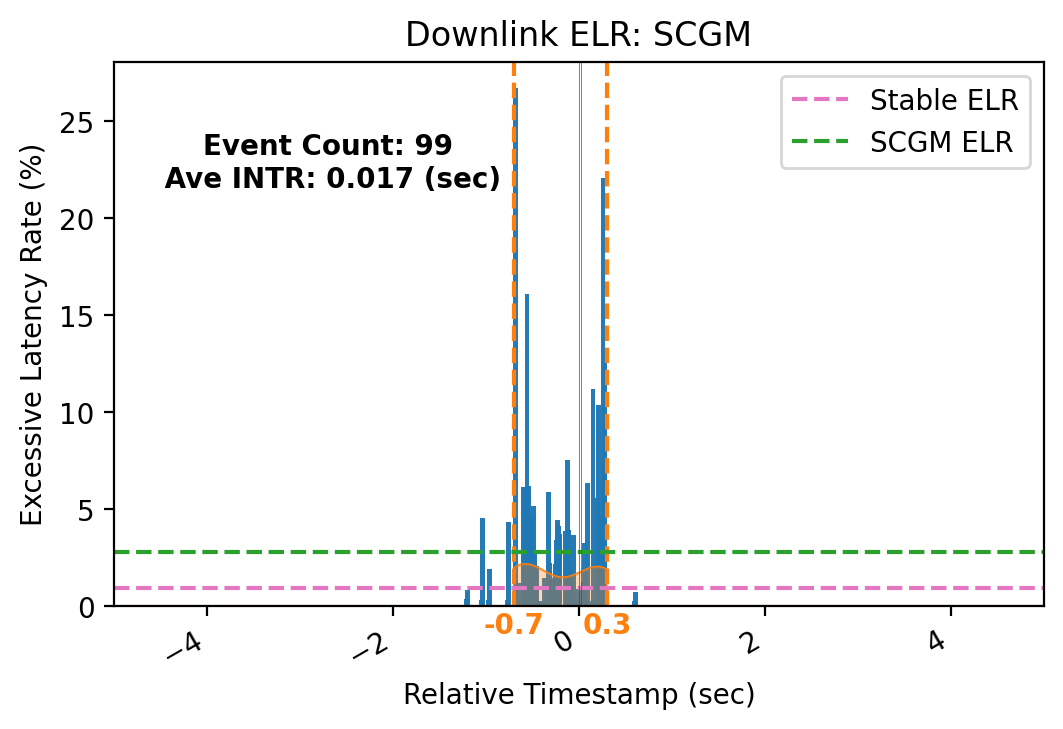

Number of Event: 99
Average Duration: 0.01702309090909091 seconds
[(-2.4, 1.9), (-2.3, 2.0)]
Uplink Stable ELR: 2.283
Uplink ELR (-2.4, 1.9) 4.023


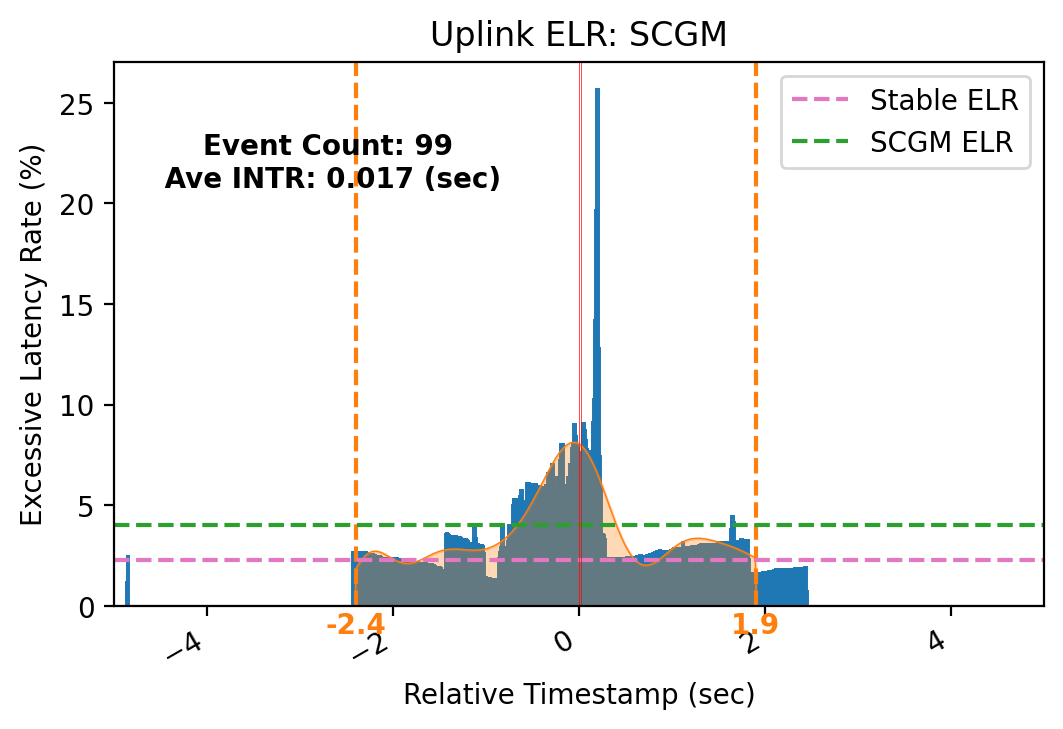

SCGA
Number of Event: 4
Average Duration: 0.03549975 seconds


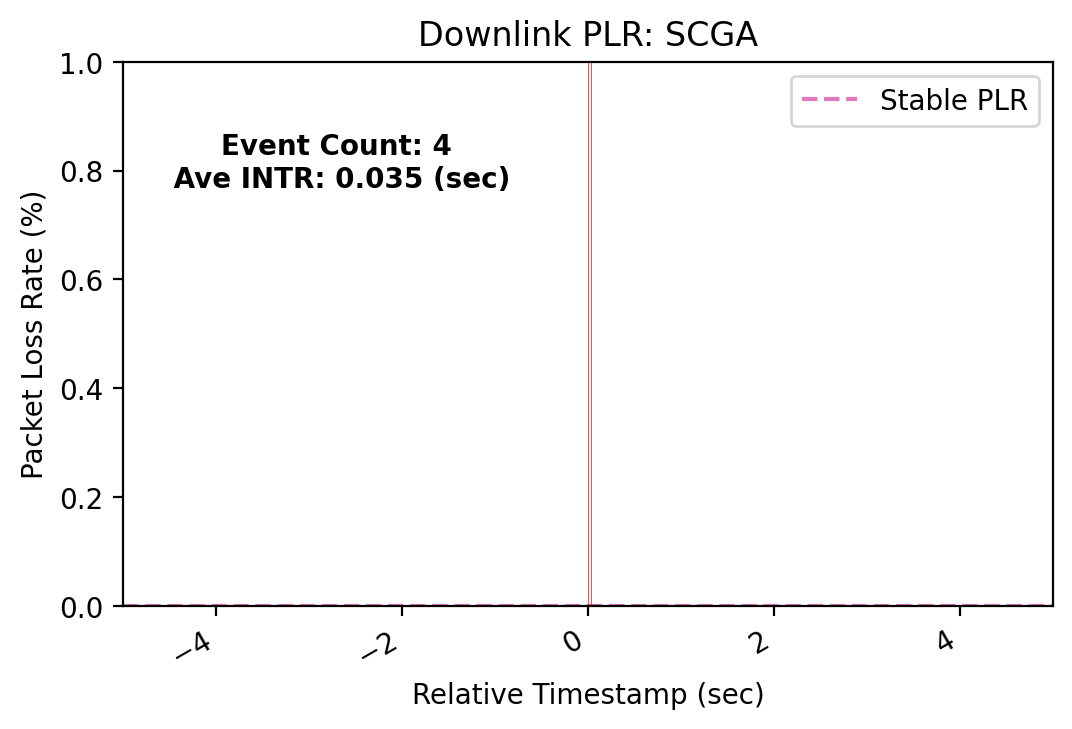

Number of Event: 4
Average Duration: 0.03549975 seconds
[(-0.1, 0.3)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.1, 0.3) 0.694


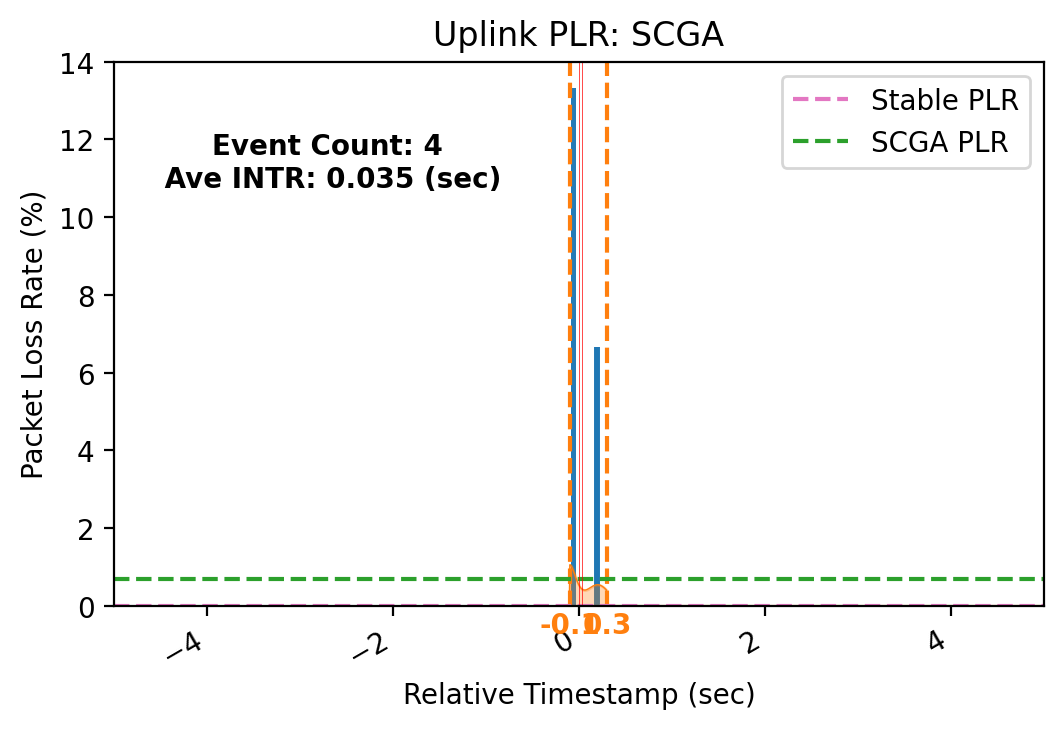

Number of Event: 4
Average Duration: 0.03549975 seconds
[(-0.2, 0.2)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.2, 0.2) 52.487


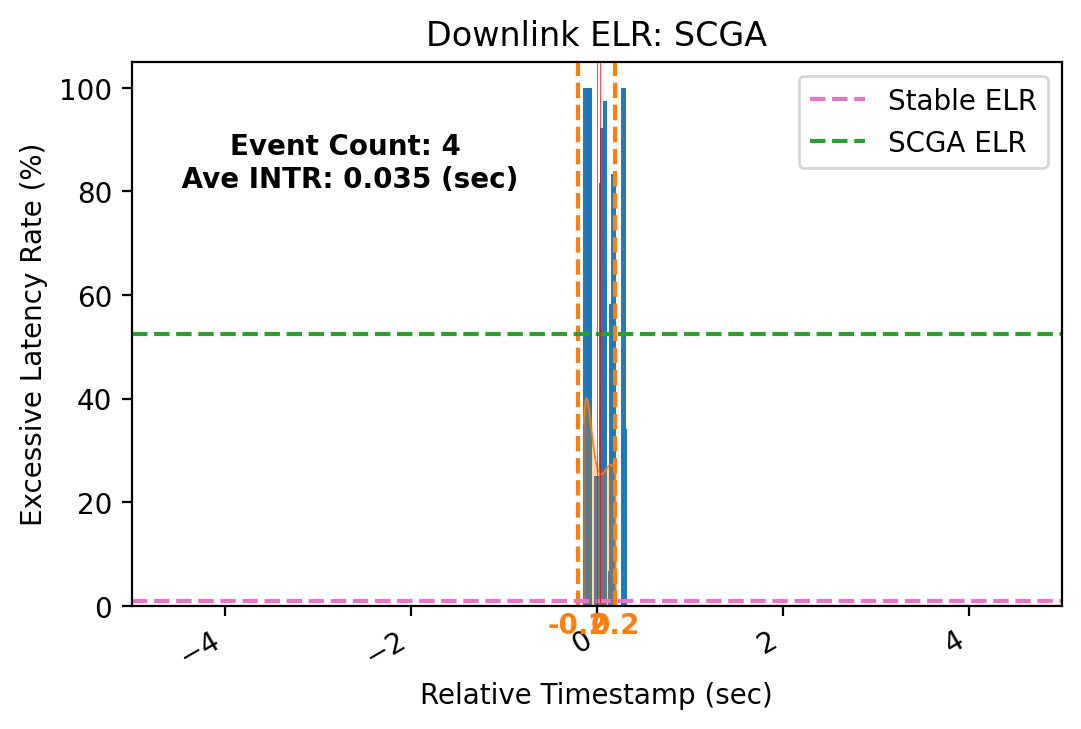

Number of Event: 4
Average Duration: 0.03549975 seconds
[(-0.2, 0.3)]
Uplink Stable ELR: 2.283
Uplink ELR (-0.2, 0.3) 42.902


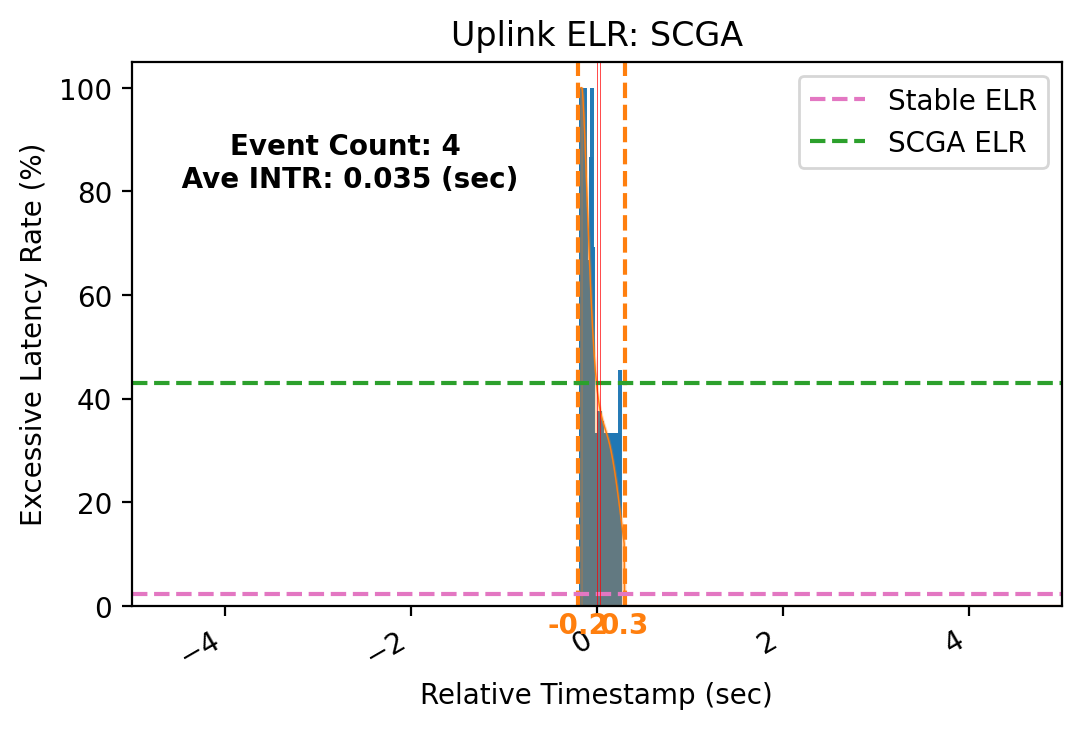

SCGR-I
Number of Event: 2
Average Duration: 0.032691 seconds


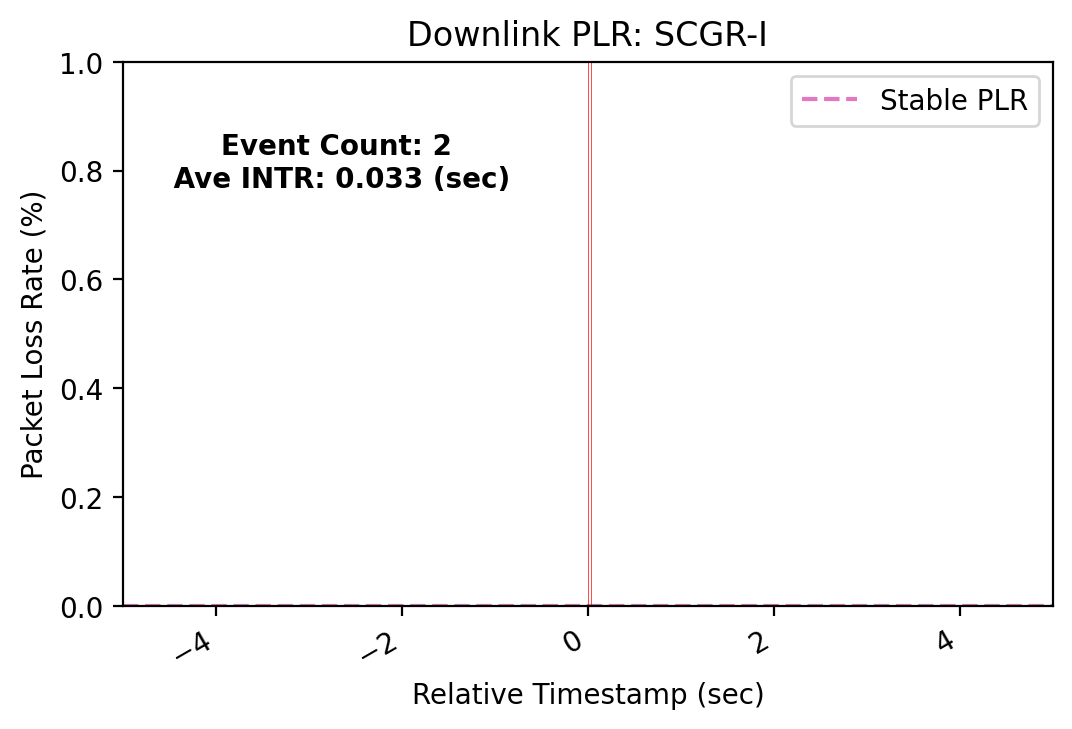

Number of Event: 2
Average Duration: 0.032691 seconds
[(-0.5, 0.1)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.5, 0.1) 0.5


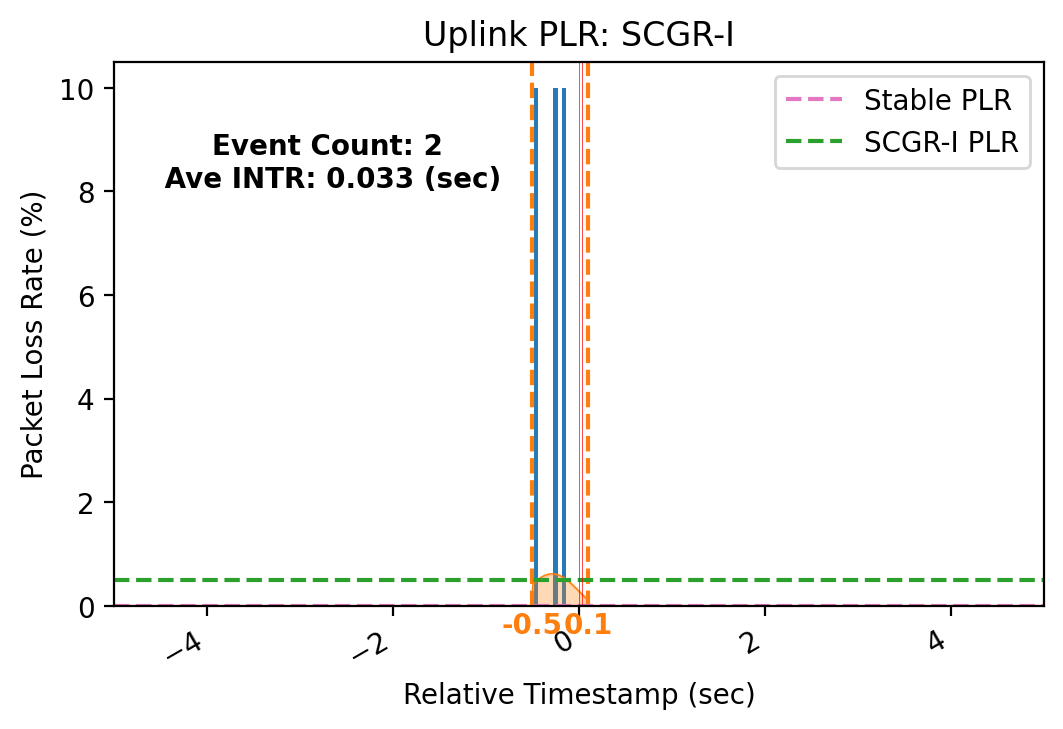

Number of Event: 2
Average Duration: 0.032691 seconds
[(-0.1, 0.5)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.1, 0.5) 13.712


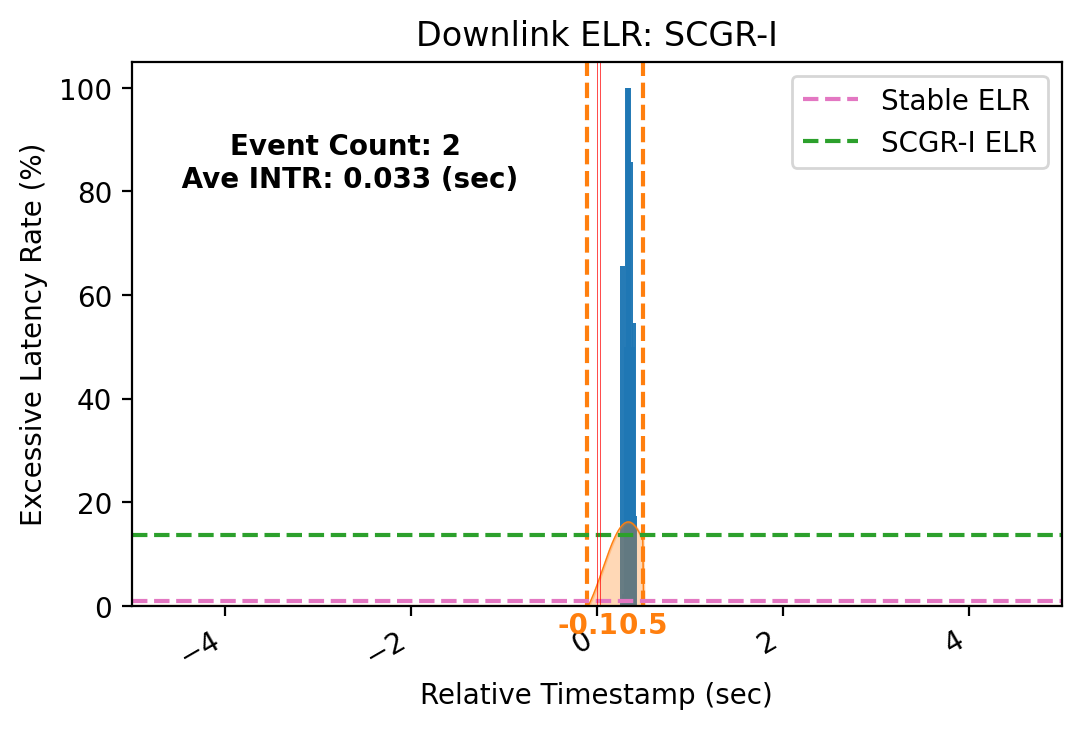

Number of Event: 2
Average Duration: 0.032691 seconds
[(-5.0, 4.6), (-4.8, 4.8), (-4.6, 5.0)]
Uplink Stable ELR: 2.283
Uplink ELR (-5.0, 4.6) 66.275


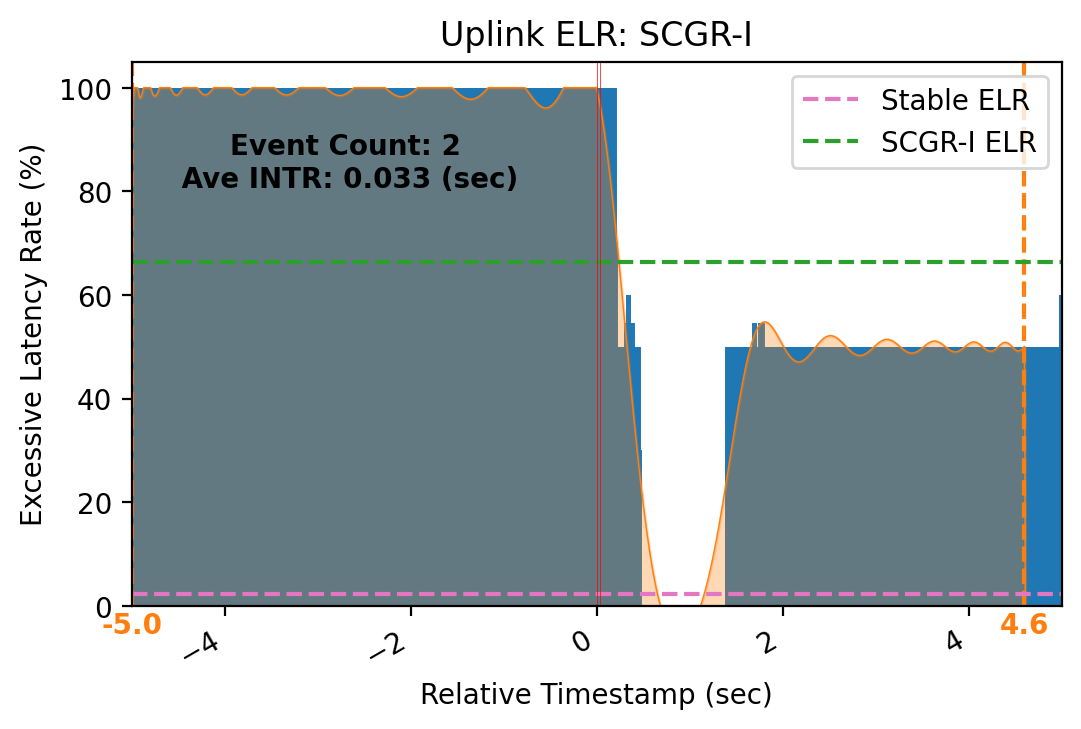

SCGR-II
Number of Event: 1
Average Duration: 0.032227 seconds


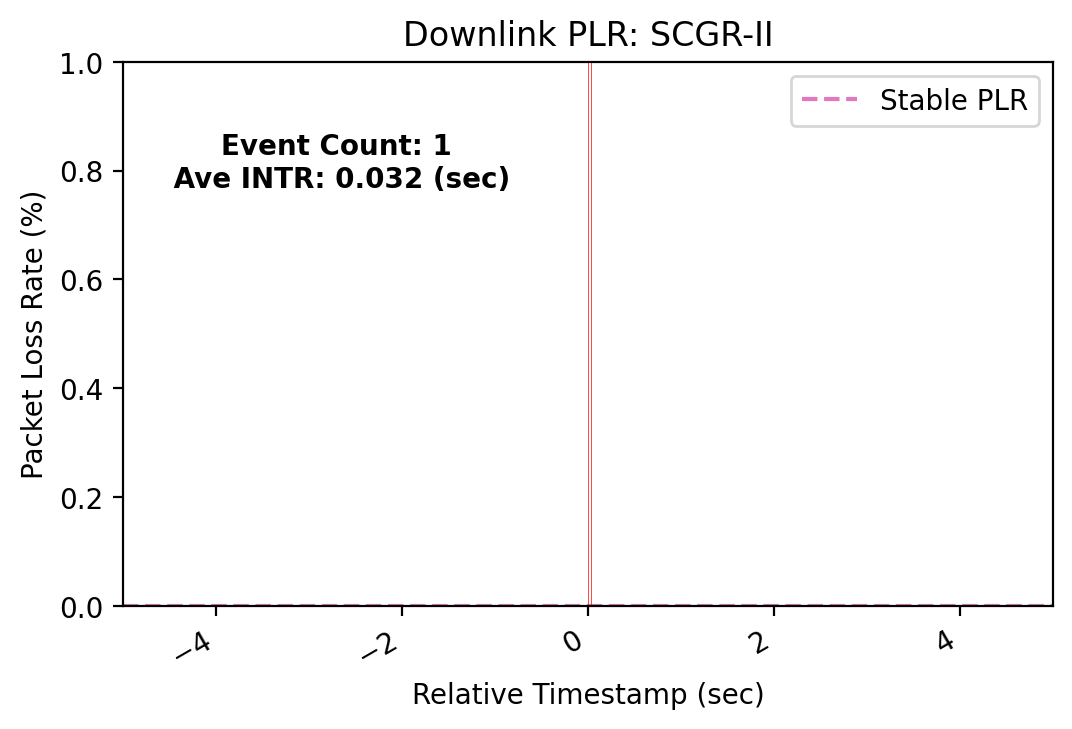

Number of Event: 1
Average Duration: 0.032227 seconds
[(-0.1, 0.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.1, 0.2) 2.609


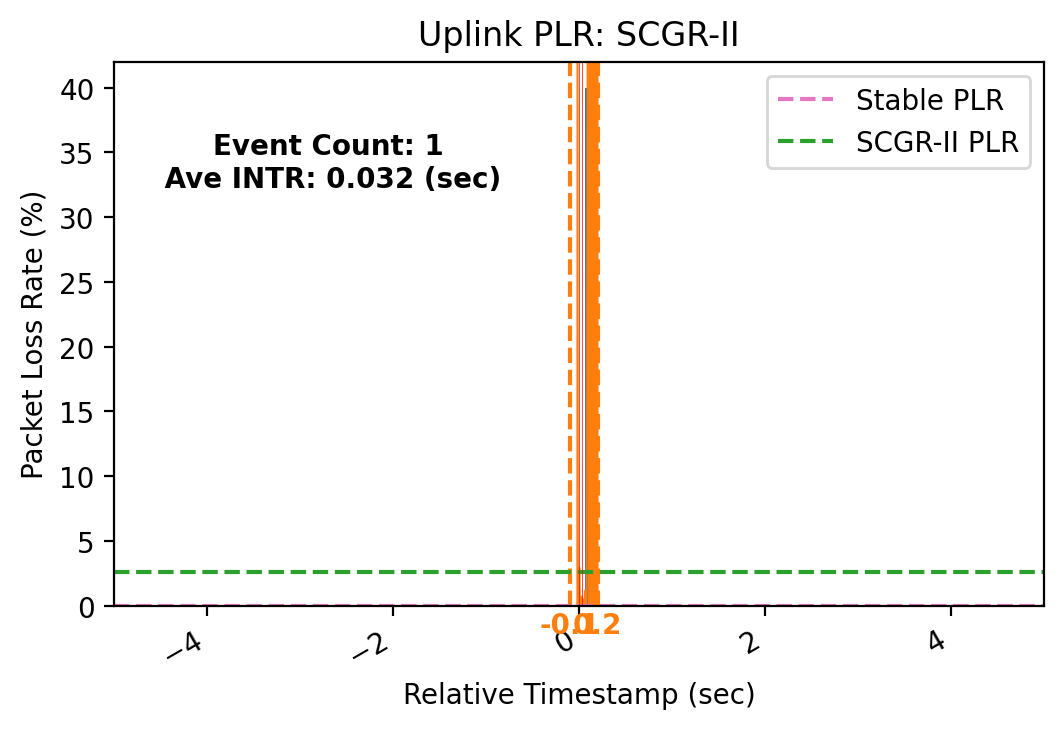

Number of Event: 1
Average Duration: 0.032227 seconds


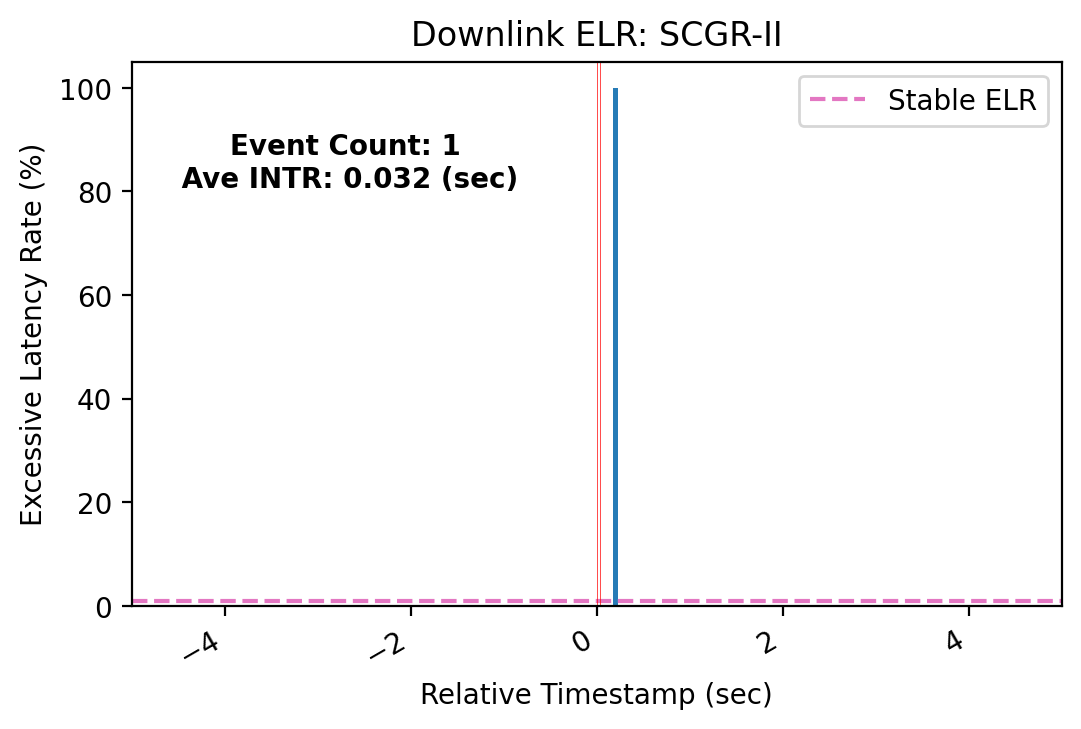

Number of Event: 1
Average Duration: 0.032227 seconds


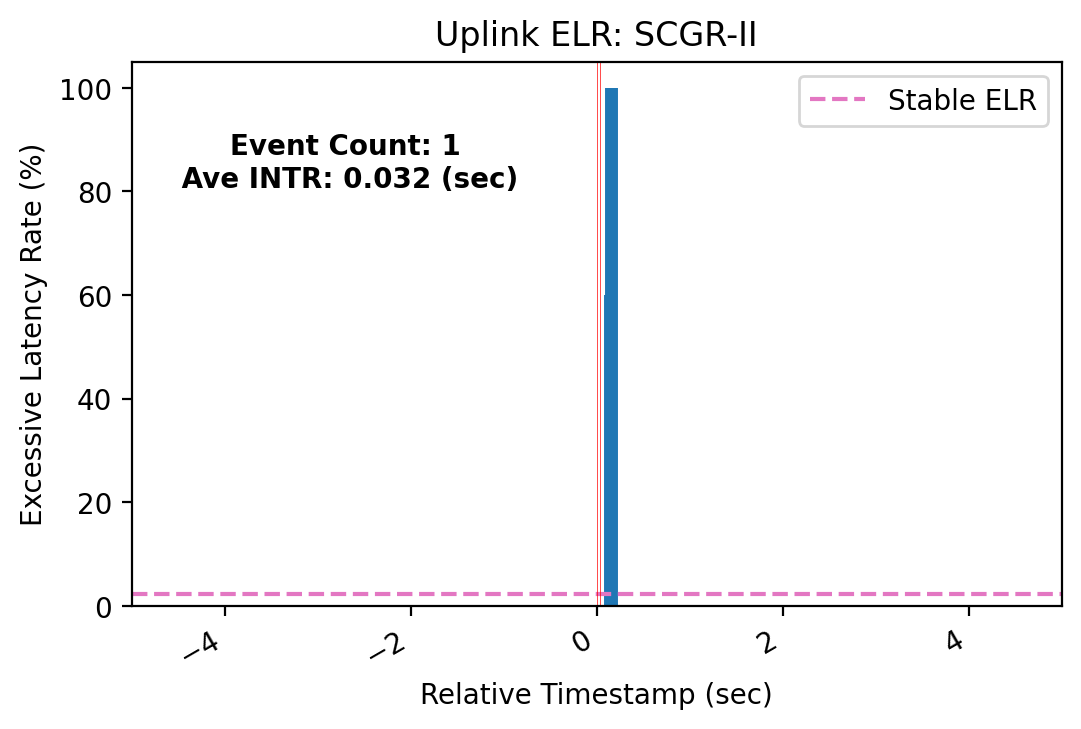

SCGC-II
Number of Event: 8
Average Duration: 0.394392125 seconds
[(-0.1, 1.3)]
Downlink Stable PLR: 0.0002
Downlink PLR (-0.1, 1.3) 21.492


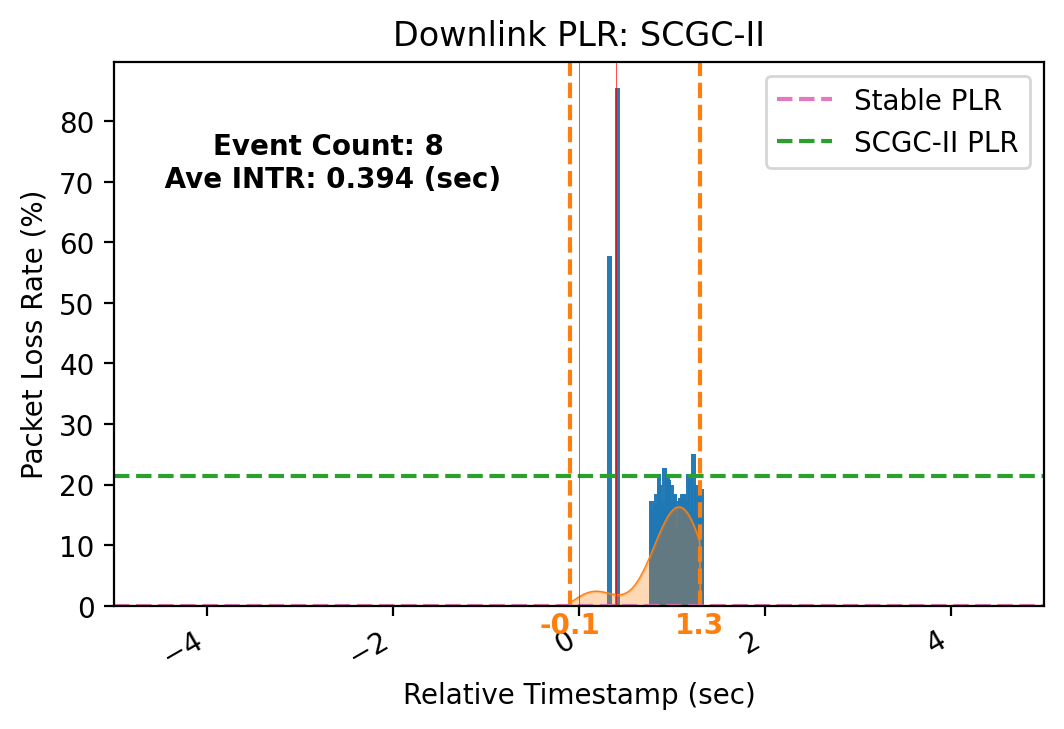

Number of Event: 8
Average Duration: 0.394392125 seconds
[(-0.7, 0.4)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.7, 0.4) 10.161


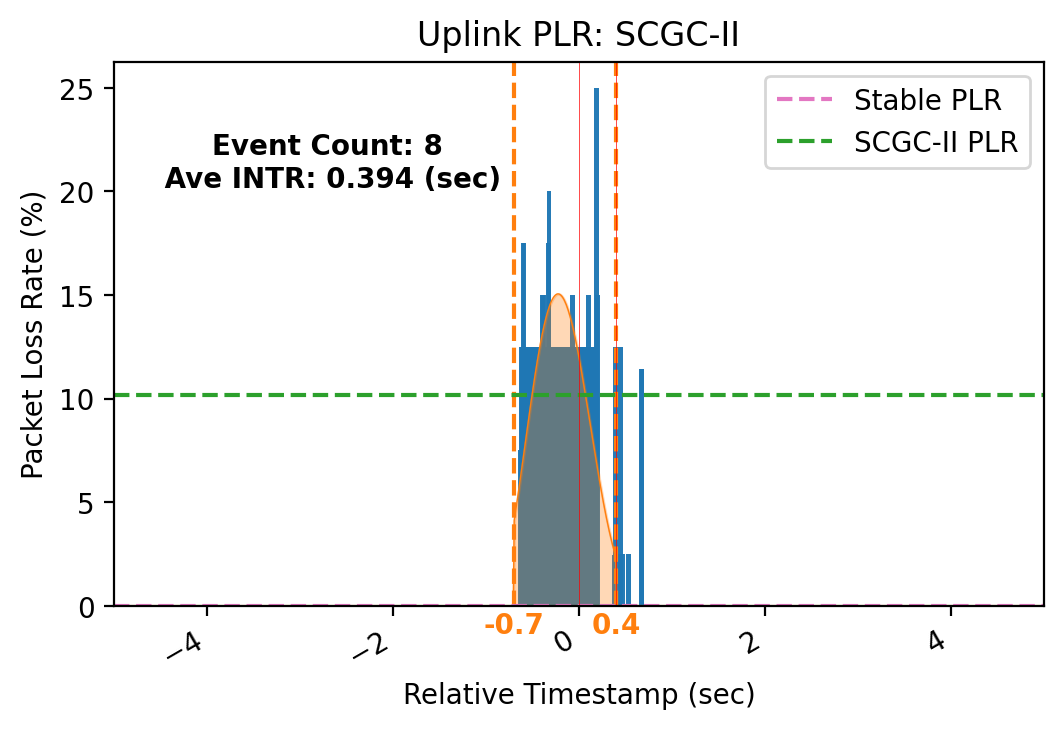

Number of Event: 8
Average Duration: 0.394392125 seconds
[(-0.1, 1.1)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.1, 1.1) 12.289


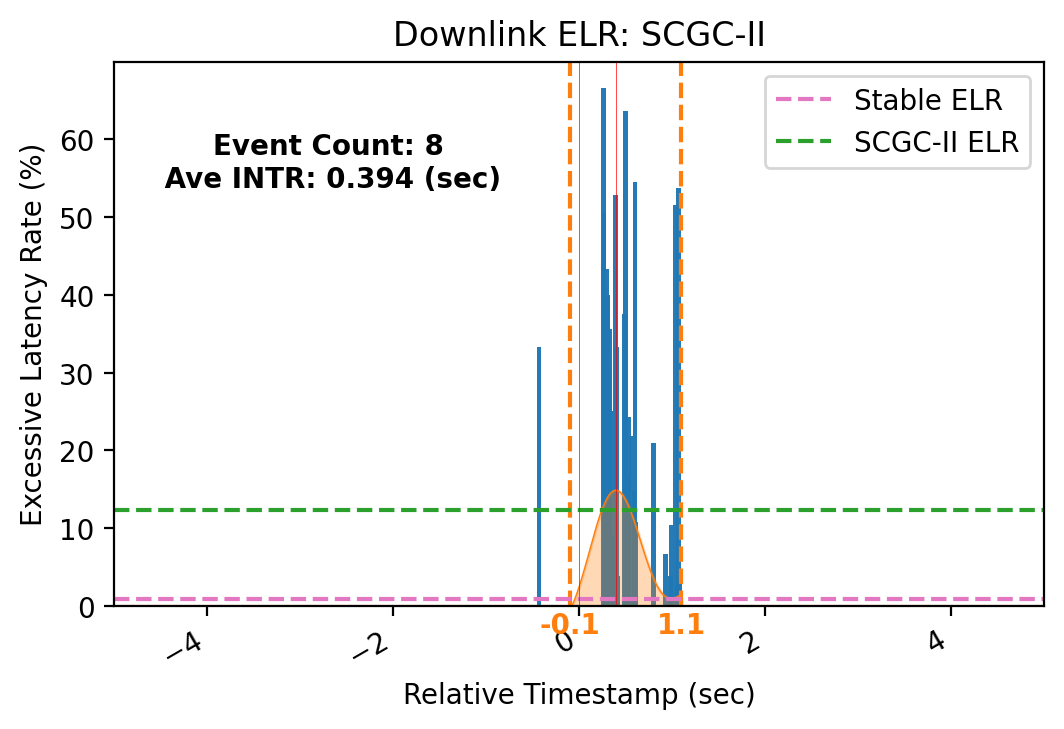

Number of Event: 8
Average Duration: 0.394392125 seconds
[(-0.2, 0.9), (-0.1, 1.0)]
Uplink Stable ELR: 2.283
Uplink ELR (-0.2, 0.9) 16.51


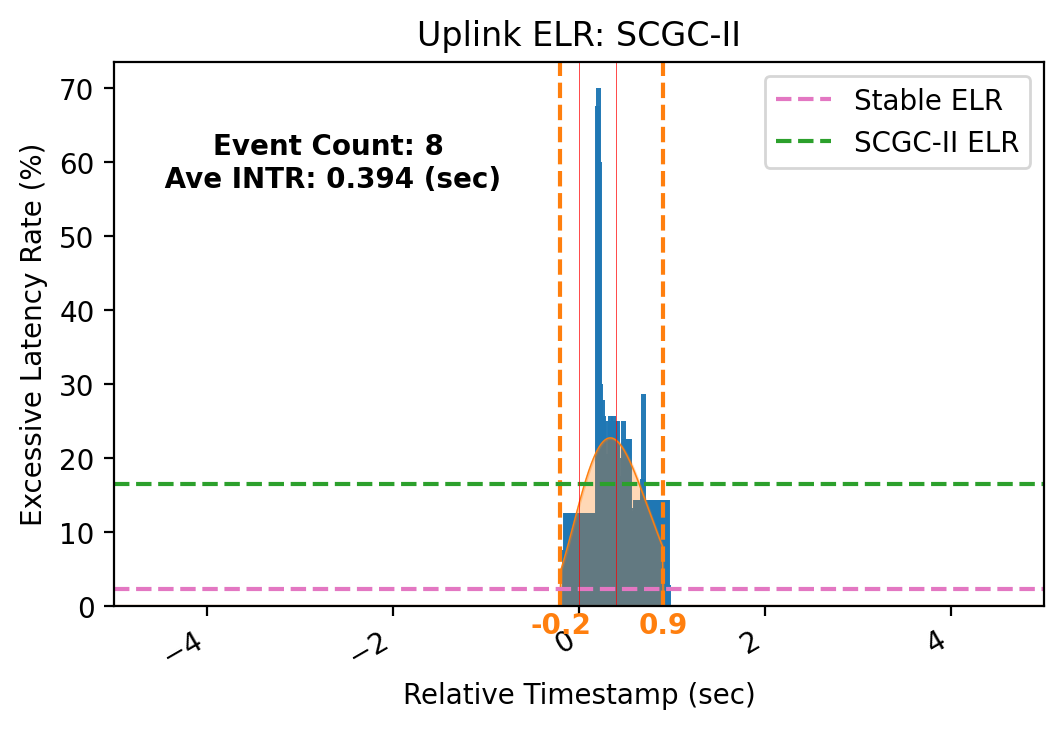

MCGF
Number of Event: 17
Average Duration: 0.08016594117647058 seconds
[(-1.7, 0.5)]
Downlink Stable PLR: 0.0002
Downlink PLR (-1.7, 0.5) 54.519


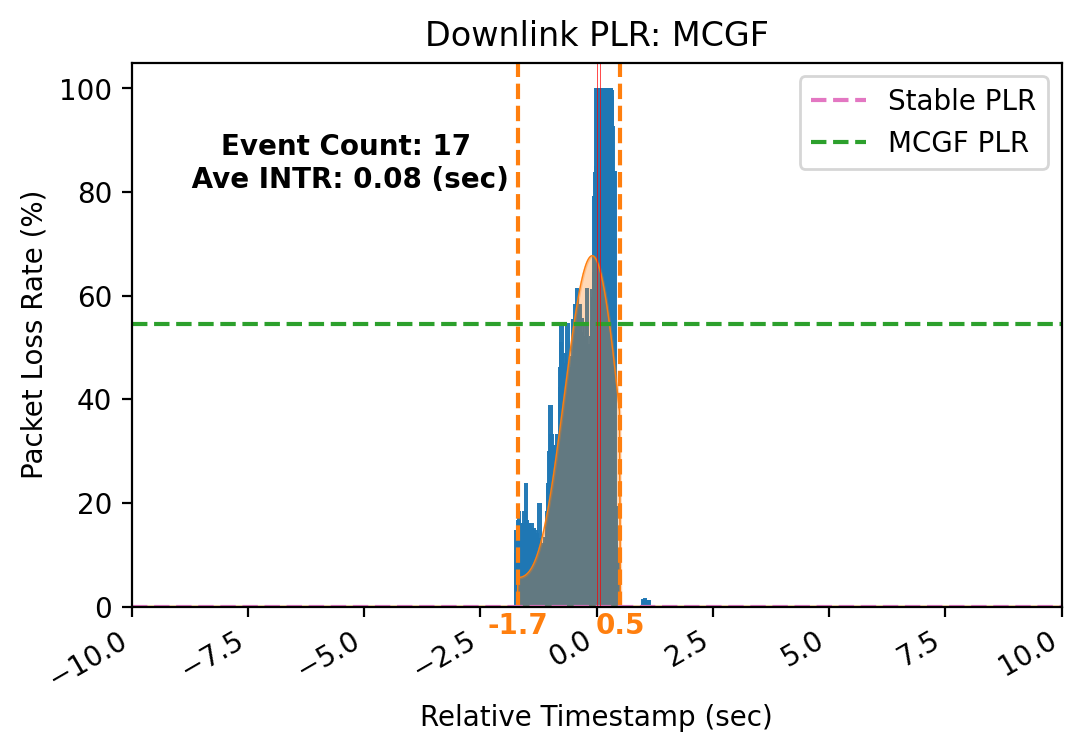

Number of Event: 17
Average Duration: 0.08016594117647058 seconds
[(-3.6, 5.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-3.6, 5.2) 3.971


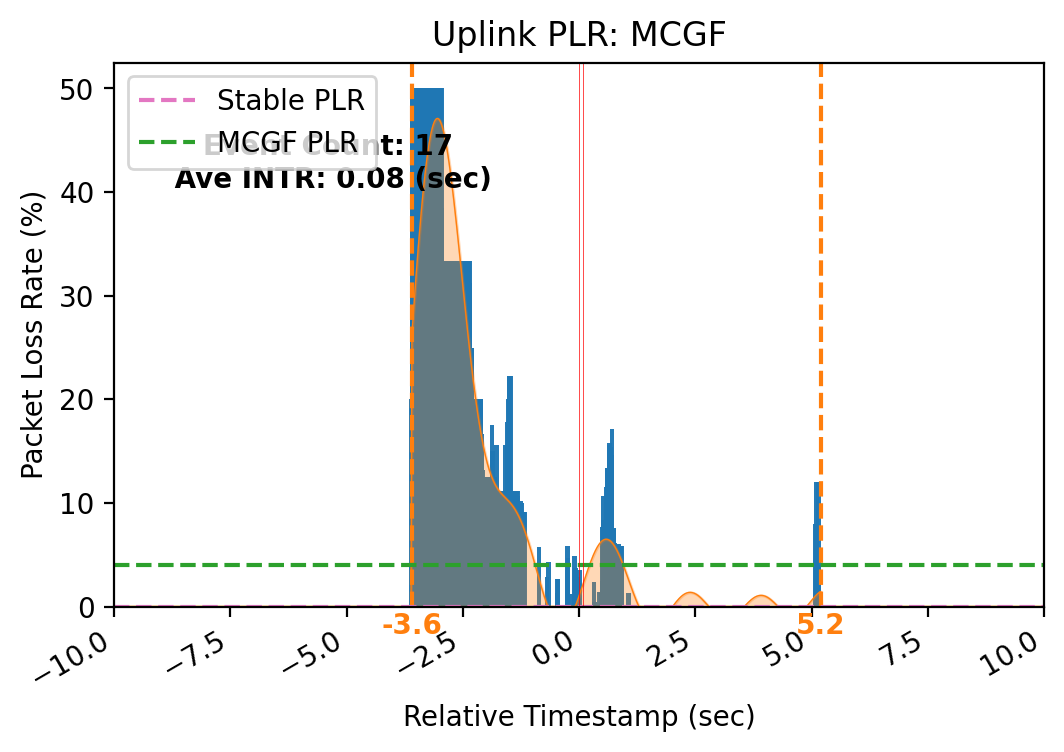

Number of Event: 17
Average Duration: 0.08016594117647058 seconds
[(-7.5, 7.1)]
Downlink Stable ELR: 0.9078
Downlink ELR (-7.5, 7.1) 2.156


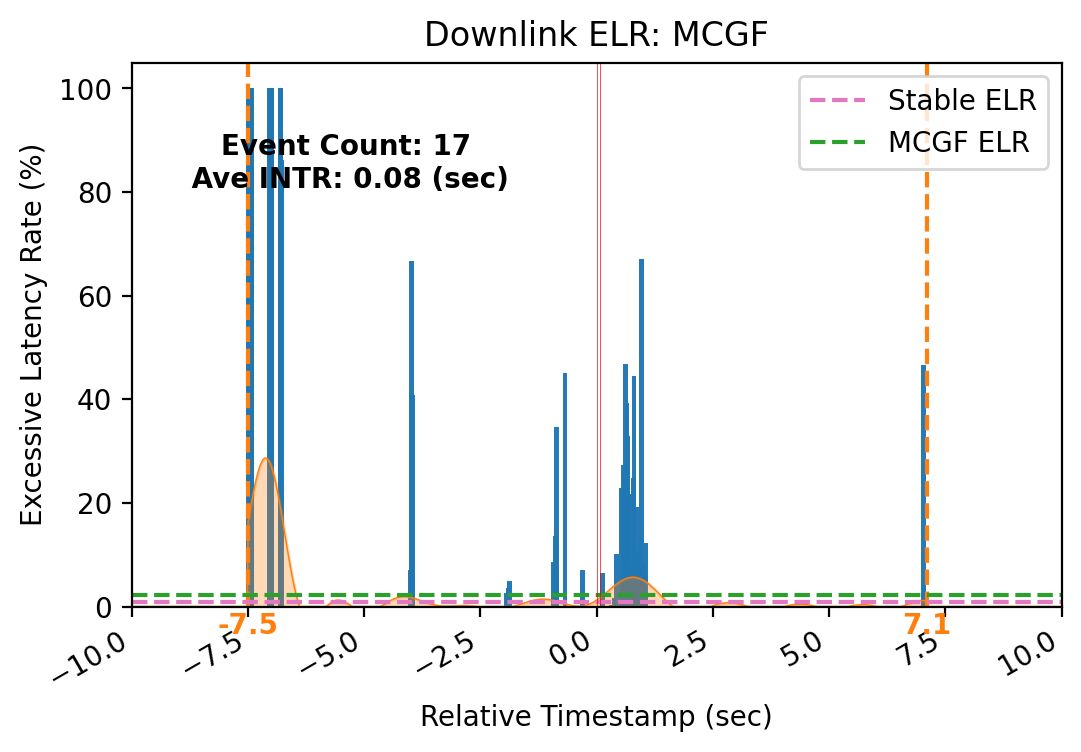

Number of Event: 17
Average Duration: 0.08016594117647058 seconds
[(-2.0, 0.8)]
Uplink Stable ELR: 2.283
Uplink ELR (-2.0, 0.8) 34.178


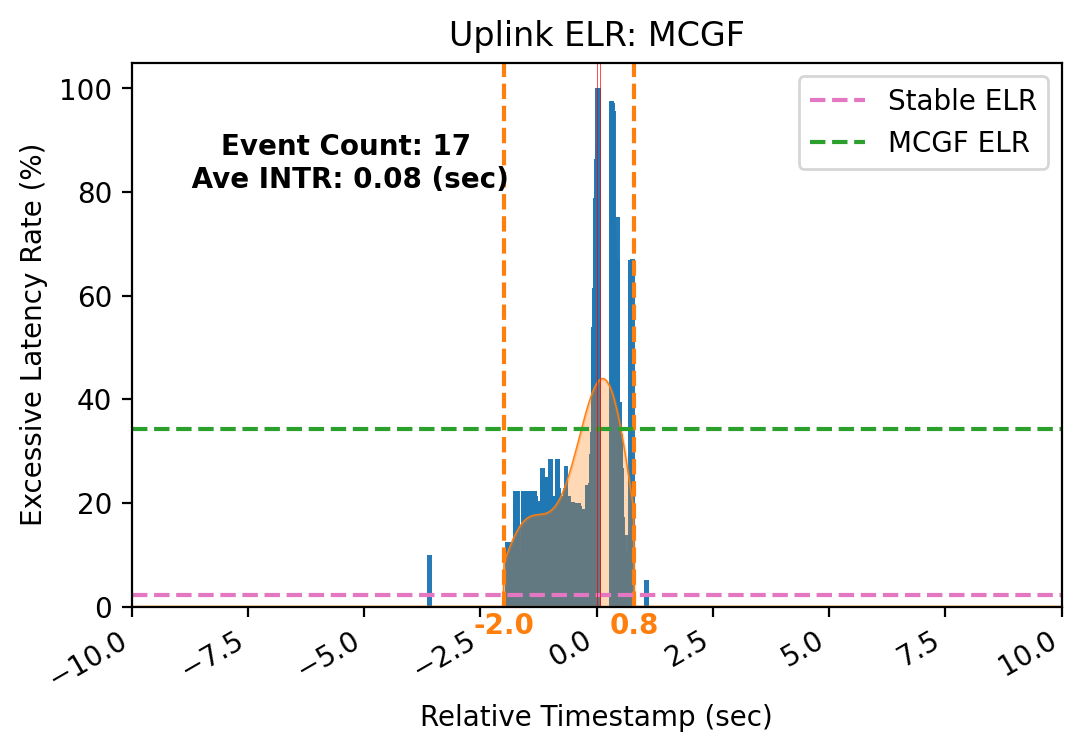

SCGF
Number of Event: 1
Average Duration: 0.067118 seconds


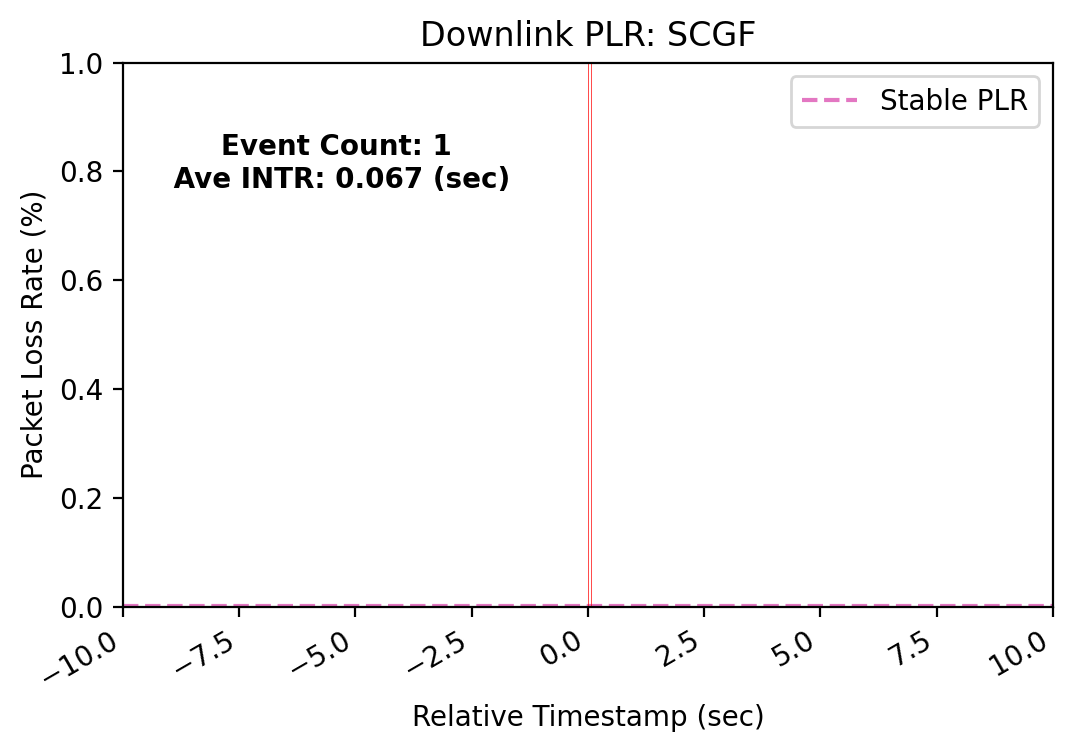

Number of Event: 1
Average Duration: 0.067118 seconds
[(-0.1, 0.2)]
Uplink Stable PLR: 0.0033
Uplink PLR (-0.1, 0.2) 0.667


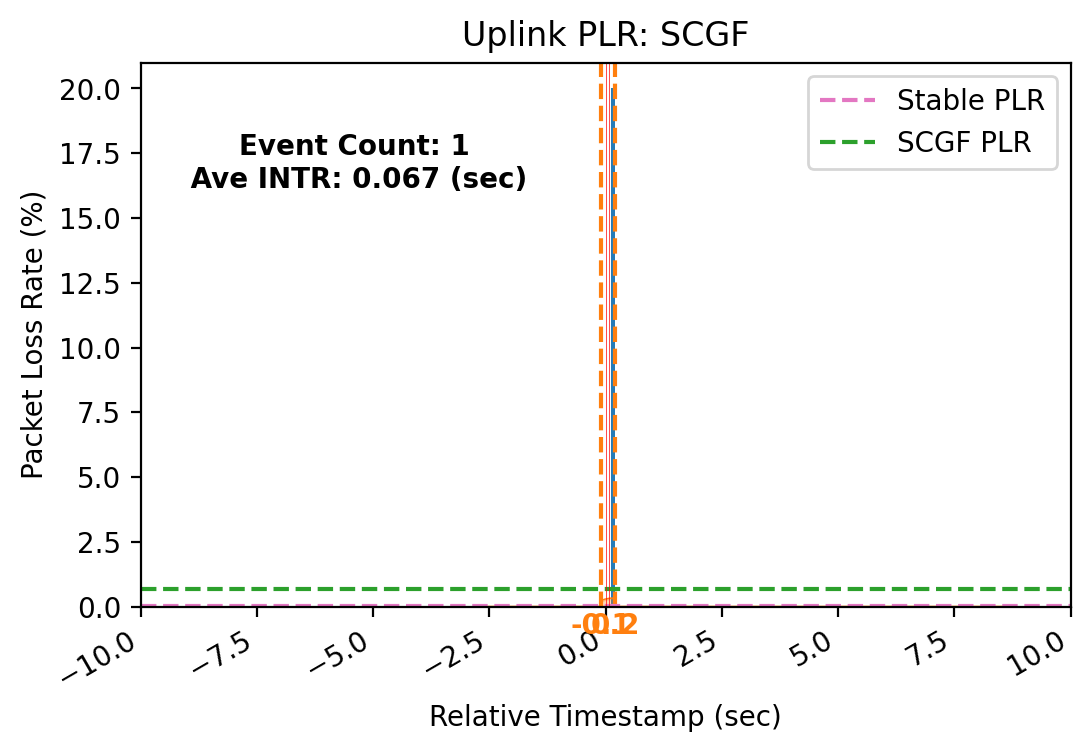

Number of Event: 1
Average Duration: 0.067118 seconds
[(-0.1, 0.4)]
Downlink Stable ELR: 0.9078
Downlink ELR (-0.1, 0.4) 18.952


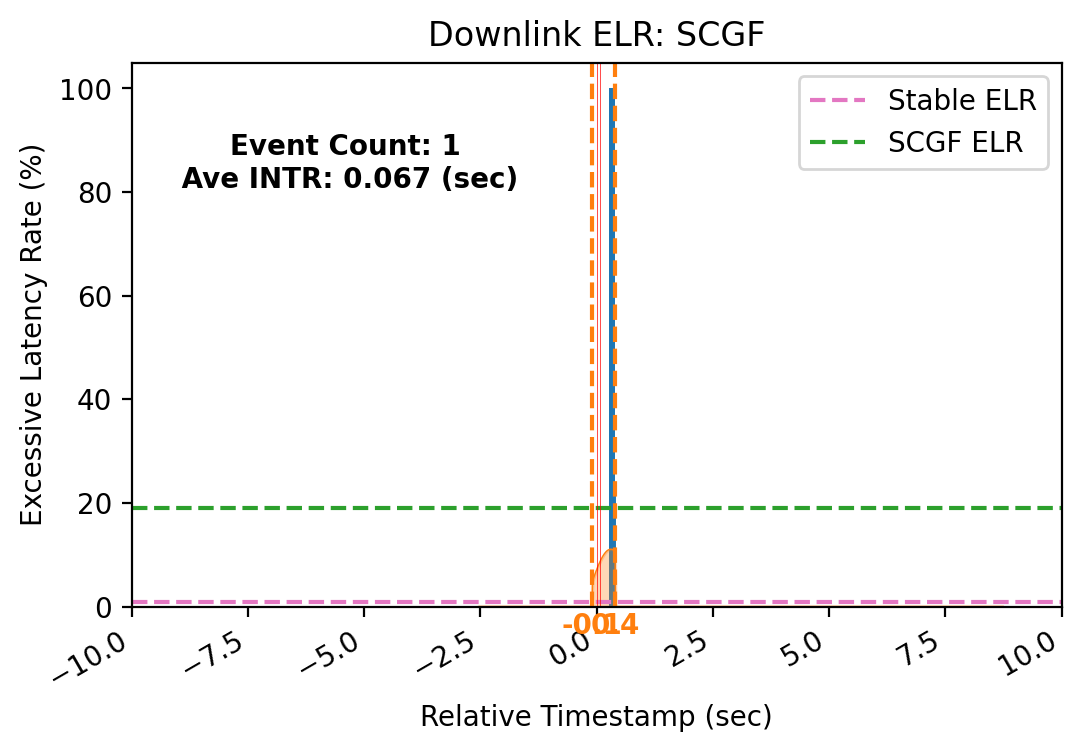

Number of Event: 1
Average Duration: 0.067118 seconds
[(-0.1, 0.3)]
Uplink Stable ELR: 2.283
Uplink ELR (-0.1, 0.3) 29.0


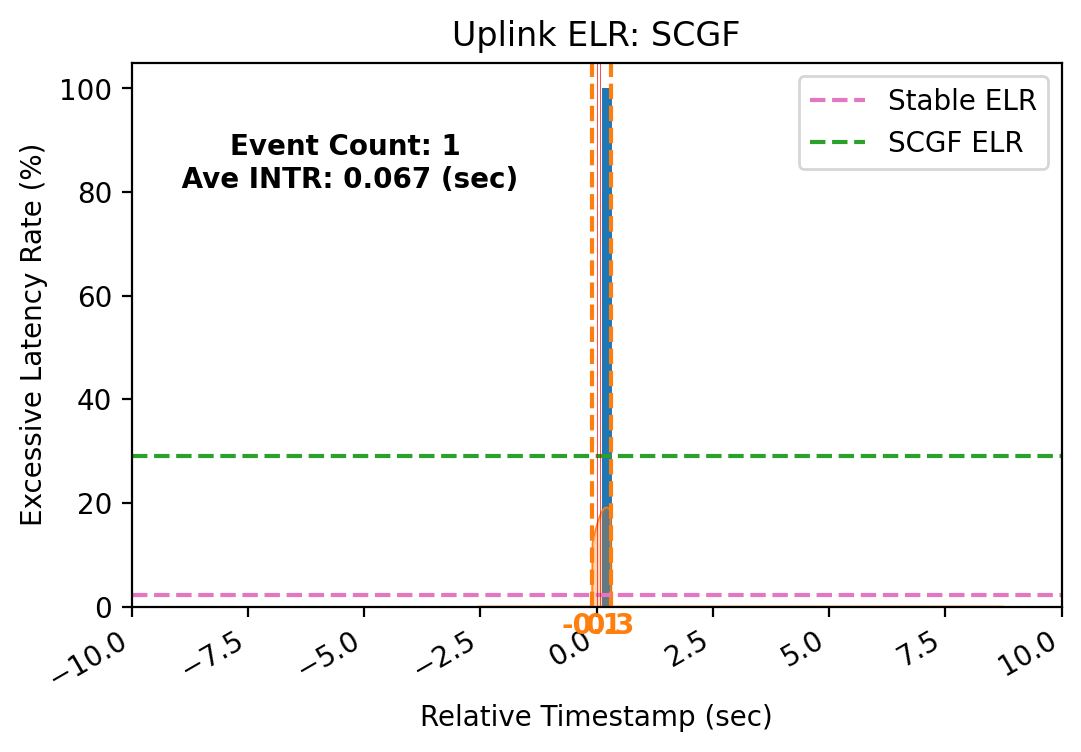

{'dl_lost': {'LTEH': (-5.0, 5.0),
             'ENBH': (-2.7, 0.3),
             'MCGH': (-0.2, 0.3),
             'MNBH': (-0.9, 0.3),
             'SCGM': (-0.8, 0.3),
             'SCGA': (-5.0, 5.0),
             'SCGR-I': (-5.0, 5.0),
             'SCGR-II': (-5.0, 5.0),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-0.1, 1.3),
             'MCGF': (-1.7, 0.5),
             'NASR': (-10.0, 10.0),
             'SCGF': (-10.0, 10.0)},
 'ul_lost': {'LTEH': (-0.1, 1.0),
             'ENBH': (-2.0, 0.2),
             'MCGH': (-0.1, 0.2),
             'MNBH': (-0.2, 0.3),
             'SCGM': (-0.6, 0.2),
             'SCGA': (-0.1, 0.3),
             'SCGR-I': (-0.5, 0.1),
             'SCGR-II': (-0.1, 0.2),
             'SCGC-I': (-5.0, 5.0),
             'SCGC-II': (-0.7, 0.4),
             'MCGF': (-3.6, 5.2),
             'NASR': (-10.0, 10.0),
             'SCGF': (-0.1, 0.2)},
 'dl_excl': {'LTEH': (-3.7, 0.4),
             'ENBH': (-5.0, 3.7),
             'MCGH':

In [34]:
# de-comment while not running the first time
D = HOType_D.copy()
E = HOType_E.copy()
scope = { mets: {
    tag: Category_scope[mets][category] for tag, category in lookup.items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

# *******************************************************************************************

import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

coef_dl_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_lost = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_dl_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])
coef_ul_excl = pd.DataFrame(columns=['lower_bd', 'upper_bd', *list(range(71))])

new_scope = { mets: {
    tag: scp for tag, scp in scope[mets].items()
} for mets in ['dl_lost', 'ul_lost', 'dl_excl', 'ul_excl'] }

for tag in scope['dl_lost'].keys():
    if len(D[f'dl_lost'][tag]['intrs']) == 0 or len(D[f'ul_lost'][tag]['intrs']) == 0:
            continue
    print('===========================================================================================')
    print(tag)
        
    for mets in ['lost', 'excl']:
        for mode in ['dl', 'ul']:
            if mets == 'lost':
                stable_PLR = round(sum(E[f'{mode}_lost']['stable_miss']) / (sum(E[f'{mode}_lost']['stable_pkt']) + 1e-9) * 100, 4)
            elif mets == 'excl':
                stable_ELR = round(sum(E[f'{mode}_excl']['stable_miss']) / (sum(E[f'{mode}_excl']['stable_pkt']) + 1e-9) * 100, 4)
                
            table, intr = merge_profile(D[f'{mode}_{mets}'][tag]['tables'], D[f'{mode}_{mets}'][tag]['intrs'], mets=mets)
            
            print('Number of Event:', sum(D[f'{mode}_{mets}'][tag]['count']))
            print('Average Duration:', intr, 'seconds')
            
            if mets == 'lost':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_PLR)
            elif mets == 'excl':
                min_scope = approx_scope(table=table.copy(), mets=mets, evt_type=lookup[tag], stable_miss_rate=stable_ELR)
            
            if min_scope != 0:
                new_scope[f'{mode}_{mets}'][tag] = min_scope
                
            fig, ax = plt.subplots(figsize=(6, 4))
            
            # # *********************************************************
            # min_scope = HOType_scope[f'{mode}_{mets}'][tag]
            # new_scope[f'{mode}_{mets}'][tag] = min_scope
            # # *********************************************************
            
            left = scope[f'{mode}_{mets}'][tag][0]
            right = scope[f'{mode}_{mets}'][tag][1]
            bound = math.ceil(max(abs(right), abs(left)))
            left = -bound; right = bound
            ax.set_xlim(left, right)
            
            # width = 0.015 * (right- left)
            width = 0.005 * (right- left)
            if mets == 'lost':
                ax.bar(table['cat_id'], table['PLR'], width=width, alpha=0.97)
            elif mets == 'excl':
                ax.bar(table['cat_id'], table['ELR'], width=width, alpha=0.97)
                
            ax.set_ylim(0, max(1, ax.get_ylim()[1]))
            bottom, top = ax.get_ylim()

            if min_scope != 0:
                ax.axvline(min_scope[0], color='tab:orange', linestyle='--')
                ax.text(min_scope[0], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[0]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                ax.axvline(min_scope[1], color='tab:orange', linestyle='--')
                ax.text(min_scope[1], bottom-0.05*(top-bottom), '{:.1f}'.format(min_scope[1]), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
                
                bleft = min_scope[0]
                bright = min_scope[1]
                
                x = np.asarray(table['cat_id'], dtype=np.float64)
                if mets == 'lost':
                    y = np.asarray(table['PLR'], dtype=np.float64)
                elif mets == 'excl':
                    y = np.asarray(table['ELR'], dtype=np.float64)
                    
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', np.RankWarning)
                    z = np.polyfit(x, y, 70)
                    p = np.poly1d(z)
                xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
                
                coef = p.coefficients
                
                if mode == 'dl':
                    if mets == 'lost':
                        coef_dl_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_dl_excl.loc[tag] = [bleft, bright, *list(coef)]
                elif mode == 'ul':
                    if mets == 'lost':
                        coef_ul_lost.loc[tag] = [bleft, bright, *list(coef)]
                    elif mets == 'excl':
                        coef_ul_excl.loc[tag] = [bleft, bright, *list(coef)]
                
                ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
                ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
            
            if mets == 'lost':
                ax.axhline(stable_PLR, color='tab:pink', linestyle='--', label='Stable PLR')
                # ax.text(1.078*right, stable_PLR, '{:.4f}'.format(stable_PLR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    PLR = round(sum(_table['lost']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable PLR:', stable_PLR)
                        print('Downlink PLR', min_scope, PLR)
                    elif mode == 'ul':
                        print('Uplink Stable PLR:', stable_PLR)
                        print('Uplink PLR', min_scope, PLR)
                    ax.axhline(PLR, color='tab:green', linestyle='--', label=f'{tag} PLR')
                    # ax.text(1.078*left, PLR, '{:.3f}'.format(PLR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
            elif mets == 'excl':
                ax.axhline(stable_ELR, color='tab:pink', linestyle='--', label='Stable ELR')
                # ax.text(1.078*right, stable_ELR, '{:.4f}'.format(stable_ELR), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
                if min_scope != 0:
                    _table = table[(table['cat_id'] >= min_scope[0]) & (table['cat_id'] < min_scope[1])].copy()
                    ELR = round(sum(_table['excl']) / (sum(_table['tx_count']) + 1e-9) * 100, 3)
                    if mode == 'dl':
                        print('Downlink Stable ELR:', stable_ELR)
                        print('Downlink ELR', min_scope, ELR)
                    elif mode == 'ul':
                        print('Uplink Stable ELR:', stable_ELR)
                        print('Uplink ELR', min_scope, ELR)
                    ax.axhline(ELR, color='tab:green', linestyle='--', label=f'{tag} ELR')
                    # ax.text(1.078*left, ELR, '{:.3f}'.format(ELR), ha='center', fontweight='bold', fontsize=10, color='tab:green')
                    
            count = sum(D[f'{mode}_{mets}'][tag]['count'])
            intr = round(intr, 3)
            ax.axvline(0, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.axvline(intr, color='red', alpha=1, linestyle='-', linewidth=0.25)
            ax.text(left+0.23*(right-left), bottom+0.77*(top-bottom), f'Event Count: {count}\n Ave INTR: {intr} (sec)', ha='center', fontweight='bold', fontsize=10)
            
            if mode == 'dl':
                if mets == 'lost':
                    ax.set_title(f'Downlink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Downlink ELR: {tag}')
            elif mode == 'ul':
                if mets == 'lost':
                    ax.set_title(f'Uplink PLR: {tag}')
                elif mets == 'excl':
                    ax.set_title(f'Uplink ELR: {tag}')
            
            if mets == 'lost':
                ax.set_ylabel('Packet Loss Rate (%)')
            elif mets == 'excl':
                ax.set_ylabel('Excessive Latency Rate (%)')
            ax.set_xlabel('Relative Timestamp (sec)')
            ax.legend()
            
            plt.gcf().autofmt_xdate()
            plt.show()

pprint(new_scope, sort_dicts=False)

# HOType_D = D.copy()
# HOType_E = E.copy()
HOType_scope = new_scope.copy()

In [35]:
coef_dl_lost_sample = coef_dl_lost.copy()
coef_ul_lost_sample = coef_ul_lost.copy()
coef_dl_excl_sample = coef_dl_excl.copy()
coef_ul_excl_sample = coef_ul_excl.copy()

### Evaluation

In [36]:
coef_dl_lost = coef_dl_lost_sample.copy()
# coef_dl_lost = coef_dl_lost_sample.copy()
# coef_ul_lost = coef_ul_lost_sample.copy()
# coef_dl_excl = coef_dl_excl_sample.copy()
# coef_ul_excl = coef_ul_excl_sample.copy()

lookup = { t: i for i, t in zip(range(10), ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGC-I', 'SCGC-II', 'MCGF', 'SCGF', ]) }
print(lookup)
display(coef_dl_lost)

stable_dl_plr = 0.0043

{'LTEH': 0, 'ENBH': 1, 'MCGH': 2, 'MNBH': 3, 'SCGM': 4, 'SCGA': 5, 'SCGC-I': 6, 'SCGC-II': 7, 'MCGF': 8, 'SCGF': 9}


lower_bd  upper_bd             0             1             2  \
ENBH         -2.7       0.3  3.612008e-40 -1.664119e-38 -4.585816e-38   
MCGH         -0.2       0.3  1.537799e-39 -4.480561e-38 -1.745614e-37   
MNBH         -0.9       0.3  3.113501e-39 -5.237876e-38 -3.490414e-37   
SCGM         -0.8       0.3  9.547239e-40 -1.130868e-39 -1.058428e-37   
SCGC-II      -0.1       1.3 -7.156036e-39 -4.306859e-38  7.767033e-37   
MCGF         -1.7       0.5 -1.092689e-59 -3.285191e-59  4.189804e-57   

                    3             4             5             6             7  \
ENBH     1.776957e-36  1.775729e-36 -5.226826e-35 -2.033597e-36 -3.643363e-34   
MCGH     4.757905e-36  5.762888e-36 -1.384829e-34  1.780656e-35 -1.010744e-33   
MNBH     5.563225e-36  1.127882e-35 -1.619823e-34  4.220378e-35 -1.180491e-33   
SCGM     1.205951e-37  3.353429e-36 -3.537354e-36  1.459286e-35 -2.499949e-35   
SCGC-II  4.579220e-36 -2.365852e-35 -1.335554e-34 -1.327424e-34 -9.678203e-34   
MCGF     1.387135e-56 -3.886558e-55 -1.598160e-54 -2.356407e-53 -4.848553e-53   

                    8             9            10            11            12  \
ENBH    -9.493064e-34  2.464726e-32 -6.787197e-33  4.609144e-31  4.734500e-31   
MCGH    -2.856901e-33  6.482869e-32 -3.636248e-32  1.246712e-30  1.094997e-30   
MNBH    -5.531741e-33  7.584977e-32 -7.568907e-32  1.457356e-30  2.013153e-30   
SCGM    -1.628040e-33  1.665104e-33 -2.375344e-32  3.141887e-32  5.624091e-31   
SCGC-II  1.124189e-32  6.261731e-32  1.859527e-31  1.199323e-30 -3.439735e-30   
MCGF     2.392883e-51  1.186605e-50  3.322021e-49  9.346956e-49  2.672996e-48   

                   13            14            15            16            17  \
ENBH    -6.703744e-30  1.212043e-29 -3.857322e-28 -6.394433e-29 -3.803676e-27   
MCGH    -1.689853e-29  3.967882e-29 -1.020471e-27  1.103460e-28 -1.065391e-26   
MNBH    -1.980080e-29  7.807043e-29 -1.193766e-27  3.174682e-28 -1.244056e-26   
SCGM    -4.479892e-31  2.331955e-29 -2.611697e-29  1.224053e-28 -2.618106e-28   
SCGC-II -1.641711e-29 -1.661699e-28 -9.854376e-28 -1.276430e-27 -1.022802e-26   
MCGF    -4.739692e-47 -2.808658e-45 -1.197964e-44 -2.781916e-43 -5.255222e-43   

                   18            19            20            21            22  \
ENBH    -9.040926e-27  1.493762e-25 -1.548289e-25  5.609169e-24  2.465241e-24   
MCGH    -2.168355e-26  3.800074e-25 -5.299975e-25  1.485977e-23  1.940327e-24   
MNBH    -4.024041e-26  4.451083e-25 -1.053875e-24  1.738293e-23  1.821339e-24   
SCGM    -1.135198e-26  9.992411e-27 -3.177392e-25  3.799732e-25 -3.130634e-27   
SCGC-II  7.112800e-26  3.687094e-25  2.308738e-24  1.436135e-23  8.067622e-24   
MCGF     2.275233e-43  6.860890e-41  2.704285e-39  1.115113e-38  2.673357e-37   

                   23            24            25            26            27  \
ENBH     3.407372e-23  1.574393e-22 -2.723672e-21  1.855462e-21 -8.166688e-20   
MCGH     1.014465e-22  3.754188e-22 -6.923141e-21  6.860914e-21 -2.168160e-19   
MNBH     1.182657e-22  6.966396e-22 -8.109172e-21  1.388209e-20 -2.536235e-19   
SCGM     2.397307e-24  1.964960e-22 -1.820178e-22  4.248505e-21 -5.537245e-21   
SCGC-II  9.722127e-23 -1.230481e-21 -6.716488e-21 -3.181026e-20 -2.097643e-19   
MCGF     3.360237e-37  1.964735e-38 -7.967623e-35 -2.663770e-33 -1.041669e-32   

                   28            29            30            31            32  \
ENBH    -6.570510e-20 -2.448877e-20 -2.629581e-18  5.183052e-17 -6.832491e-18   
MCGH    -9.740194e-20 -2.864722e-19 -6.403303e-18  1.323091e-16 -5.671822e-17   
MNBH    -1.523270e-19 -3.275712e-19 -1.196805e-17  1.549556e-16 -1.262063e-16   
SCGM    -3.474415e-20 -3.636904e-21 -3.400160e-18  3.469292e-18 -4.163020e-17   
SCGC-II  8.898288e-20 -2.676049e-19  2.167040e-17  1.282757e-16  3.552901e-16   
MCGF    -2.585885e-31 -9.659117e-32  2.778096e-30  9.760995e-29  2.895980e-27   

                   33            34            35            36            37  \
ENBH    

In [37]:
data_dir = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown"
devices = ['sm01', 'sm02']
trips = ['#01',]

filepaths = []
for tr in trips:
    for dev in devices:
        filepaths.append([os.path.join(data_dir, dev, tr, 'data', 'handover_info_log.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_dnlk_loss_latency.csv'), \
            os.path.join(data_dir, dev, tr, 'data', 'udp_uplk_loss_latency.csv'),])
    break

filepaths

[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_uplk_loss_latency.csv']]

sm01 sm02
eval_value | ground_truth
0.057919238993404544 | 0.1549921657350911


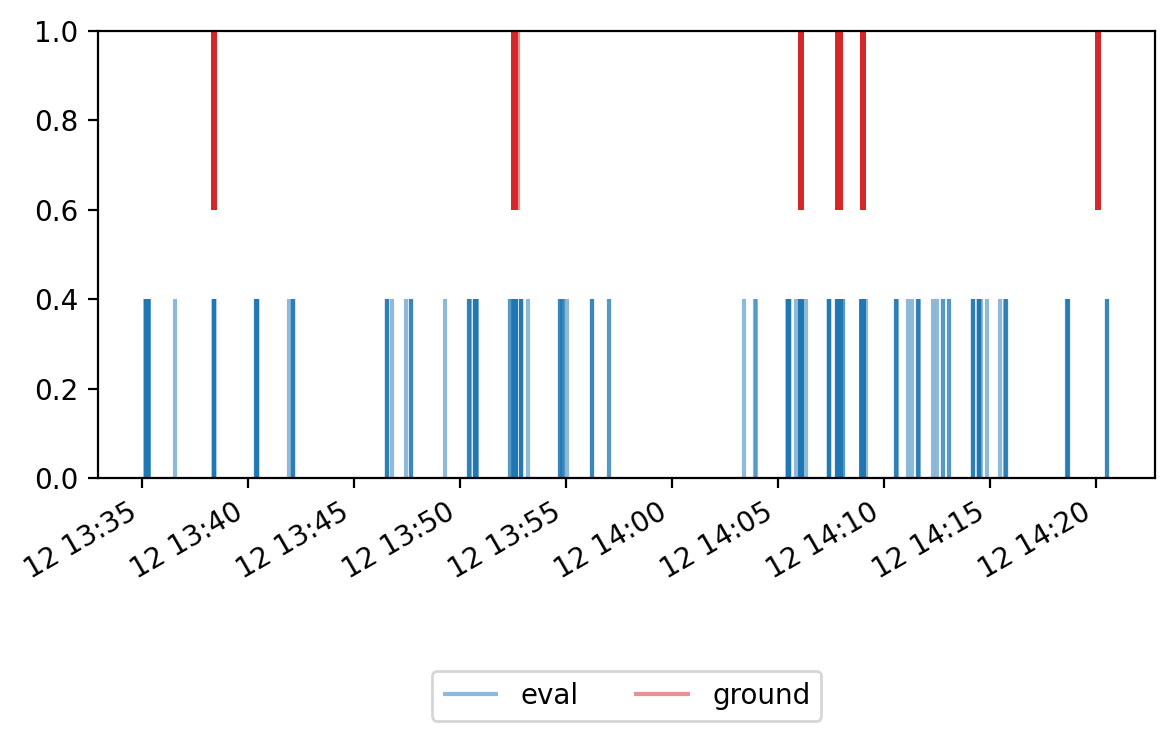

[array(['2023-09-12T13:34:16.252557443', '2023-09-12T13:34:16.258123443',
        '2023-09-12T13:34:16.258123443', ...,
        '2023-09-12T14:21:31.354077443', '2023-09-12T14:21:31.354077443',
        '2023-09-12T14:21:31.354077443'], dtype='datetime64[ns]'),
 array(['2023-09-12T13:34:16.252996578', '2023-09-12T13:34:16.258282578',
        '2023-09-12T13:34:16.258282578', ...,
        '2023-09-12T14:21:31.354246578', '2023-09-12T14:21:31.360234578',
        '2023-09-12T14:21:31.360234578'], dtype='datetime64[ns]'),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [38]:
x1x2_yg1yg2yg_y1y2y_specific2 = []
# for s in list(it.combinations(filepaths, 2))[:1]:
for s in list(it.combinations(filepaths, 2)):
    # print(s[0][0][77:81], s[1][0][77:81])
    print(s[0][0][83:87], s[1][0][83:87])
    
    ho_df1 = pd.read_csv(s[0][0], parse_dates=['start'])[['type', 'start']]
    dl_df1 = pd.read_csv(s[0][1], parse_dates=['xmit_time', 'arr_time'])[['seq', 'lost', 'excl', 'xmit_time', 'arr_time']]
    ho_df2 = pd.read_csv(s[1][0], parse_dates=['start'])[['type', 'start']]
    dl_df2 = pd.read_csv(s[1][1], parse_dates=['xmit_time', 'arr_time'])[['seq', 'lost', 'excl', 'xmit_time', 'arr_time']]
    
    df = pd.merge(dl_df1, dl_df2, on='seq', how='outer')
    # display(df)
    
    splr_ground_truth = (df['lost_x'] & df['lost_y']).mean() * 100
    
    X1 = df['arr_time_x'].to_numpy()
    X2 = df['arr_time_y'].to_numpy()
    
    x1x2_yg1yg2yg_y1y2y_specific2.append(X1)
    x1x2_yg1yg2yg_y1y2y_specific2.append(X2)
    x1x2_yg1yg2yg_y1y2y_specific2.append(df['lost_x'].to_numpy())
    x1x2_yg1yg2yg_y1y2y_specific2.append(df['lost_y'].to_numpy())
    x1x2_yg1yg2yg_y1y2y_specific2.append((df['lost_x'] & df['lost_y']).to_numpy())
    
    C1 = ho_df1['start'].to_numpy()
    C2 = ho_df2['start'].to_numpy()
    T1 = ho_df1['type'].to_numpy()
    T2 = ho_df2['type'].to_numpy()
    
    Z1 = [(X1 - c) / np.timedelta64(1, 's') for c in C1]
    Z2 = [(X2 - c) / np.timedelta64(1, 's') for c in C2]
    
    Yp1 = []
    for i in range(len(C1)):
        # print(i, T1[i])
        if T1[i] not in coef_dl_lost.index.to_list():
            y = np.zeros(len(Z1))
            continue
        y = poly_approx(coef_dl_lost.copy(), Z1[i], T1[i])
        Yp1.append(y)
    
    Yp2 = []   
    for i in range(len(C2)):
        # print(i, T2[i])
        if T2[i] not in coef_dl_lost.index.to_list():
            y = np.zeros(len(Z2))
            continue
        y = poly_approx(coef_dl_lost.copy(), Z2[i], T2[i])
        Yp2.append(y)
    
    Y1 = [sum(s)/100 for s in zip(*Yp1)]
    Y2 = [sum(s)/100 for s in zip(*Yp2)]
    
    # Y1 = [s if s > stable_dl_plr else stable_dl_plr for s in Y1]
    # Y2 = [s if s > stable_dl_plr else stable_dl_plr for s in Y2]
    # Y = [y1*y2 for y1, y2 in zip(Y1, Y2)]
    
    random.seed(2023)
    Y1 = np.array([generate_random_boolean(s) for s in Y1])
    Y2 = np.array([generate_random_boolean(s) for s in Y2])
    # inst = [generate_random_boolean(s) for s in Y]
    Y = np.logical_and(Y1, Y2)
    
    x1x2_yg1yg2yg_y1y2y_specific2.append(Y1)
    x1x2_yg1yg2yg_y1y2y_specific2.append(Y2)
    x1x2_yg1yg2yg_y1y2y_specific2.append(Y)
    
    splr = sum(Y)/len(Y) * 100
    # splr = sum(inst)/len(inst) * 100
    
    print('eval_value', '|', 'ground_truth')
    print(splr, '|', splr_ground_truth)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    x1 = [ts for ts, bo in zip(X1, Y) if bo]
    ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
    x2 = [ts for ts, bo in zip(X1, (df['lost_x'] & df['lost_y']).to_numpy()) if bo]
    ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
    ax.set_ylim(0, 1)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

x1x2_yg1yg2yg_y1y2y_specific2

In [46]:
X1 = x1x2_yg1yg2yg_y1y2y_specific1[0].copy()
X2 = x1x2_yg1yg2yg_y1y2y_specific2[1].copy()
Yg1 = x1x2_yg1yg2yg_y1y2y_specific1[2].copy()
Yg2 = x1x2_yg1yg2yg_y1y2y_specific2[3].copy()
Y1 = x1x2_yg1yg2yg_y1y2y_specific1[5].copy()
Y2 = x1x2_yg1yg2yg_y1y2y_specific2[6].copy()
Yg = np.logical_and(Yg1, Yg2)
Y = np.logical_and(Y1, Y2)

device | eval_value | ground_truth
sm01 | 1.0725288555623986 | 0.8694940567523886
sm02 | 0.9245208611553795 | 0.9567609247607215
dual | 0.0813409044572417 | 0.1549921657350911


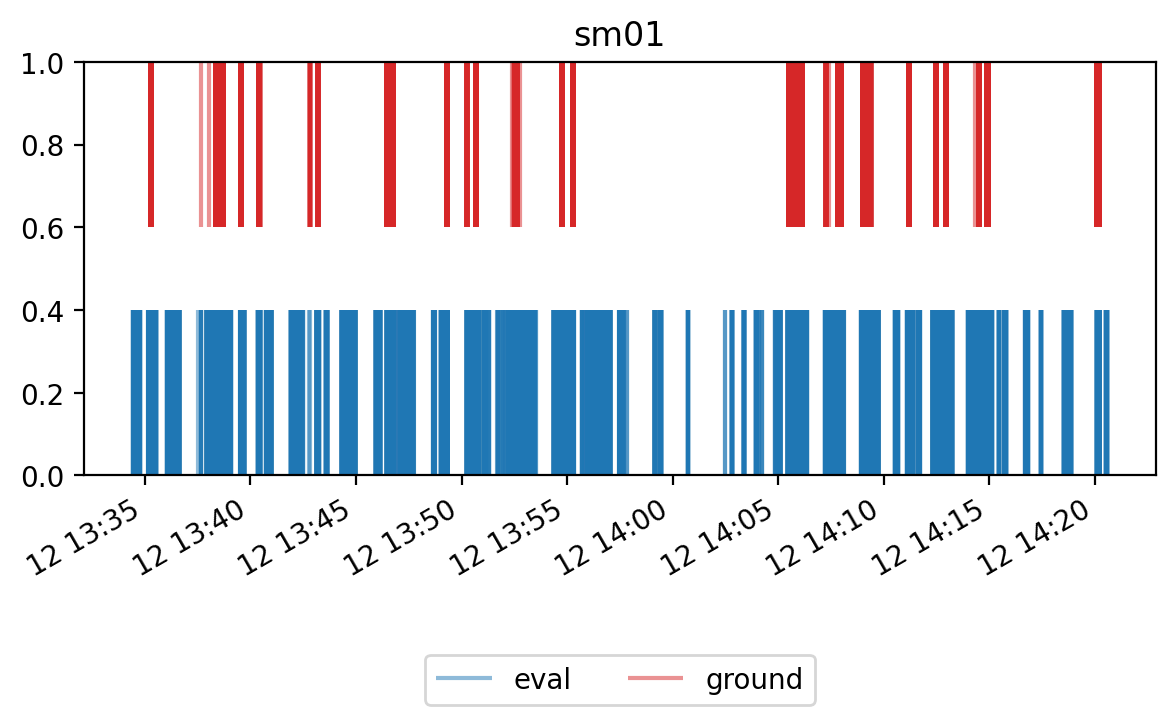

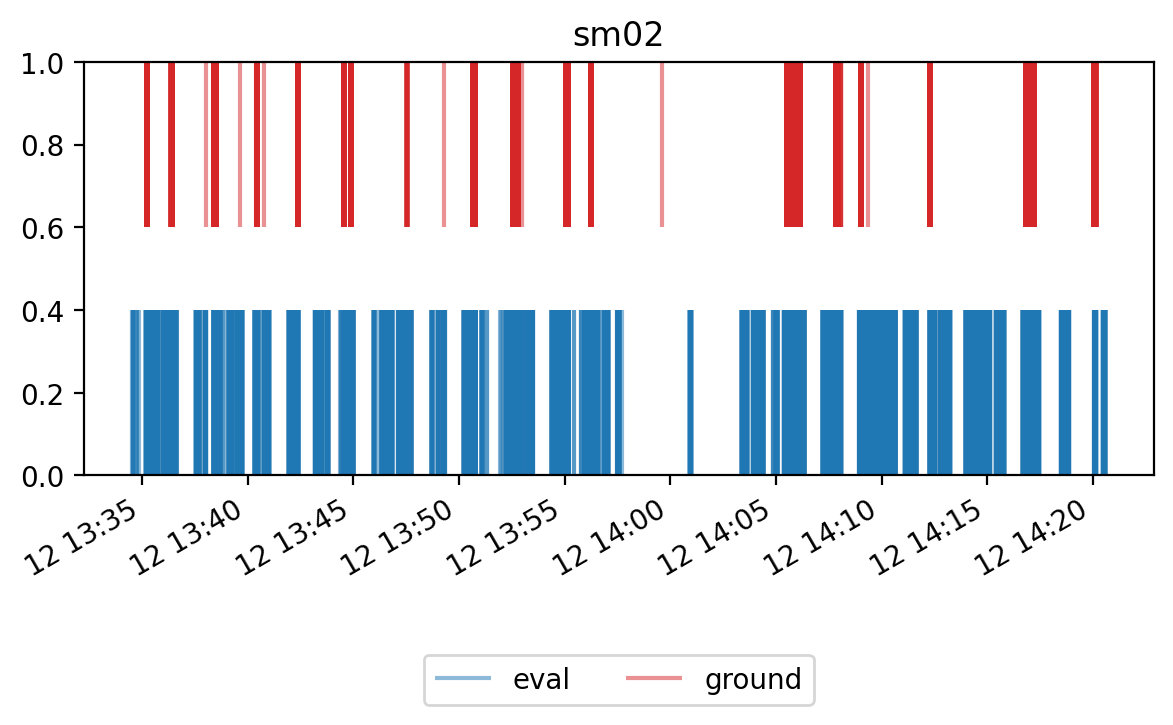

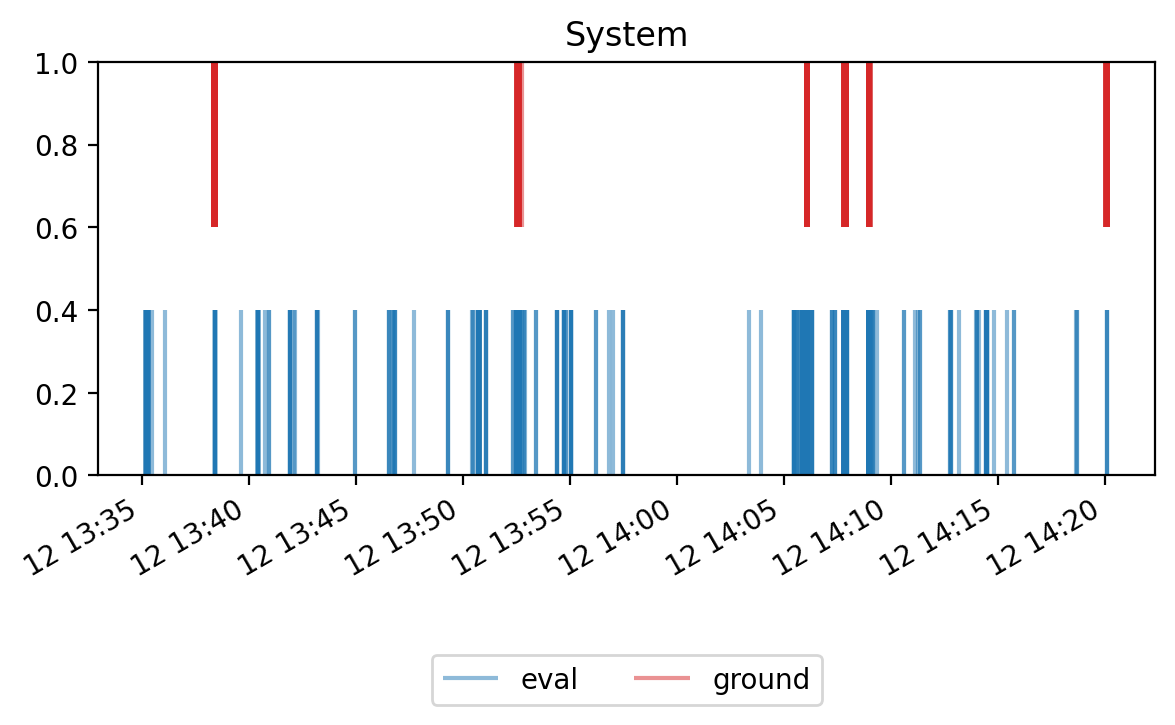

In [52]:
print('device', '|', 'eval_value', '|', 'ground_truth')
print('sm01', '|', sum(Y1)/len(Y1)*100, '|', sum(Yg1)/len(Yg1)*100)
print('sm02', '|', sum(Y2)/len(Y2)*100, '|', sum(Yg2)/len(Yg2)*100)
print('dual', '|', sum(Y)/len(Y)*100, '|', sum(Yg)/len(Yg)*100)

fig, ax = plt.subplots(figsize=(6, 4))
    
x1 = [ts for ts, bo in zip(X1, Y1) if bo]
ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
x2 = [ts for ts, bo in zip(X1, Yg1) if bo]
ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
ax.set_ylim(0, 1)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)
ax.set_title('sm01')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 4))
    
x1 = [ts for ts, bo in zip(X1, Y2) if bo]
ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
x2 = [ts for ts, bo in zip(X1, Yg2) if bo]
ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
ax.set_ylim(0, 1)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)
ax.set_title('sm02')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 4))
    
x1 = [ts for ts, bo in zip(X1, Y) if bo]
ax.vlines(x1 ,ymin=0, ymax=0.4, label='eval', color='tab:blue', alpha=0.5)
x2 = [ts for ts, bo in zip(X1, Yg) if bo]
ax.vlines(x2 ,ymin=0.6, ymax=1, label='ground', color='tab:red', alpha=0.5)
ax.set_ylim(0, 1)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)
ax.set_title('System')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()